In [17]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+r'\Covariance and Adjacency Matrix')
from DataManager import dataManager

In [18]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


In [19]:
def shuffle_train_test(variables, train_ratio = 0.7, print_summary = True):
    data_all = np.concatenate((variables["X_train"], variables["X_test"]), axis = 2)
    labels_all = np.concatenate((variables["y_train"], variables["y_test"]), axis = 1)
    indices = np.random.permutation(data_all.shape[2])
    split_ind = int(train_ratio * data_all.shape[2])
    training_idx, test_idx = indices[:split_ind], indices[split_ind:]
    #print(split_ind, training_idx.shape)
    variables["X_train"], variables["X_test"] = data_all[:,:,training_idx], data_all[:,:,test_idx]
    variables["y_train"], variables["y_test"] = labels_all[:,training_idx], labels_all[:,test_idx]
    if print_summary:
        print("X_train:", variables["X_train"].shape)
        print("X_test:", variables["X_test"].shape)
        print("y_train:", variables["y_train"].shape, "Positive labes:", np.sum(variables["y_train"]))
        print("y_test:", variables["y_test"].shape, "Positive labes:",np.sum(variables["y_test"]))
    return variables

In [20]:
#shuffle dataset
variables = shuffle_train_test(variables, train_ratio = 0.7, print_summary = True)

X_train: (640, 31, 2039)
X_test: (640, 31, 874)
y_train: (1, 2039) Positive labes: 217.0
y_test: (1, 874) Positive labes: 104.0


In [21]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
print("Indices below are removed as they are trivial data:")
print(dm.train_indices)
print(dm.test_indices)

--------data manager successfully initialized--------
Indices below are removed as they are trivial data:
[72, 155, 398, 428, 433, 625, 675, 701, 713, 1158, 1191, 1210, 1357, 1388, 1406, 1455, 1486, 1761, 1762, 1797, 1803, 1825, 1924, 1952, 2022]
[54, 68, 82, 107, 126, 227, 232, 264, 278, 405, 431, 468, 853, 865]


In [22]:
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
sys.path.insert(1, parent_dir+r'\Unsupervised GCN')
from GCN import *
from GCNutil import *

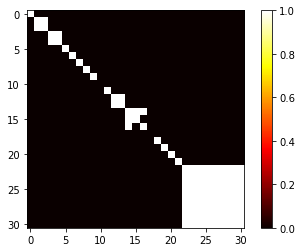

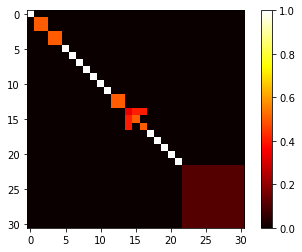

In [23]:
#first fine tune a good threshold n
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))

In [24]:
model_dir = parent_dir+r'\Unsupervised GCN\models/2layer_1epoch_Aavg_1e-3.pt'
sim_train, sim_test = get_sim_matrix_from_model(dm, model_dir)
print(sim_train.shape)
print(sim_test.shape)
sim_train_arch = sim_train
sim_test_arch = sim_test

(2014, 31, 31)
(860, 31, 31)


In [ ]:
#optional: normalize the sim_train and sim_test
mean = np.mean(sim_train)
sd = np.std(sim_train)
print(mean, sd)

sim_train = (sim_train - mean) / sd
sim_test = (sim_test - mean) / sd

average ictal


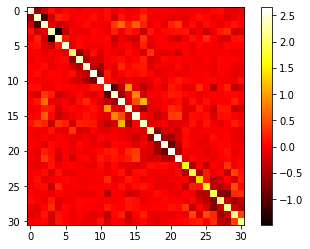

average normal


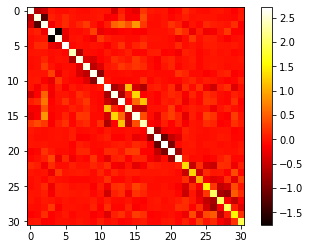

In [25]:
ictal_sum = np.zeros(sim_train[0][:,:].shape)
normal_sum = np.zeros(sim_train[0][:,:].shape)
tc = 0
ni = 0
nn = 0
for i in range(sim_train.shape[0]):
        if dm.Y_train[tc,0] == 1:
            ictal_sum = ictal_sum + sim_train[i,:,:]
            ni+=1
        else:
            normal_sum = normal_sum + sim_train[i,:,:]
            nn+=1
        tc+=1
ictal_sum = ictal_sum / ni
normal_sum = normal_sum / nn
print("average ictal")
show_heat_map(ictal_sum)
print("average normal")
show_heat_map(normal_sum)

In [26]:
from MLP import *

In [27]:
n_layers = 2
dropouts = [-1] + [round(x,1) * 0.1 for x in range(3, 8)] # 8 choices
layer_factors = [0.8, 1, 1.5, 2, 5, 10] # 5 choices
learning_rates = [3e-4]#, 1e-3, 3e-3, 1e-2, 3e-2]
print(dropouts)
print(layer_factors)

[-1, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001]
[0.8, 1, 1.5, 2, 5, 10]


In [28]:
import itertools
def get_combs(n_layers, dropouts, layer_factors):
    layer_comb = []
    for f in layer_factors:
        for r in dropouts:
            layer_comb.append([f, r])

    d = []
    for i in range(n_layers):
        d.append(layer_comb)
    d = tuple(d)
    ret =  list(itertools.product(*d))#[x for x in itertools.product(*d)] 
    return ret

In [29]:
print(get_combs(2, [1,2], [5,6,7]))
#import itertools
#print(list(itertools.permutations([1, 2, 3])))

[([5, 1], [5, 1]), ([5, 1], [5, 2]), ([5, 1], [6, 1]), ([5, 1], [6, 2]), ([5, 1], [7, 1]), ([5, 1], [7, 2]), ([5, 2], [5, 1]), ([5, 2], [5, 2]), ([5, 2], [6, 1]), ([5, 2], [6, 2]), ([5, 2], [7, 1]), ([5, 2], [7, 2]), ([6, 1], [5, 1]), ([6, 1], [5, 2]), ([6, 1], [6, 1]), ([6, 1], [6, 2]), ([6, 1], [7, 1]), ([6, 1], [7, 2]), ([6, 2], [5, 1]), ([6, 2], [5, 2]), ([6, 2], [6, 1]), ([6, 2], [6, 2]), ([6, 2], [7, 1]), ([6, 2], [7, 2]), ([7, 1], [5, 1]), ([7, 1], [5, 2]), ([7, 1], [6, 1]), ([7, 1], [6, 2]), ([7, 1], [7, 1]), ([7, 1], [7, 2]), ([7, 2], [5, 1]), ([7, 2], [5, 2]), ([7, 2], [6, 1]), ([7, 2], [6, 2]), ([7, 2], [7, 1]), ([7, 2], [7, 2])]


In [30]:
parameter_list = []
for layers in range(1, n_layers+1):
    combs = get_combs(layers, dropouts, layer_factors)
    for c in range(len(combs)):
        break
        #combs[c][0][0] = 1
        #print(c, combs[c])
        #combs[c][0][0] = 1
    
    print(len(combs))
    for c in combs:
        for lr in learning_rates:
            parameters = {
                'n_layers':layers,
                'layer_size_factor':[1]+[c[i][0] for i in range(1, len(c))], 
                'dropout':[t[1] for t in c],
                'batch_size': 128,
                'num_epochs': 250,
                'learning_rate': lr,
                'weight_decay': 5e-3,
                'betas': (0.9, 0.999), 
                'eps': 1e-08,
                'threshold': None,
                'val_acc': None,
            }
            parameter_list.append(parameters)         

36
1296


In [31]:
print(len(parameter_list))
i = 1
for p in parameter_list:
    print(i, p['layer_size_factor'],"||", p['dropout'])
    i+=1

1332
1 [1] || [-1]
2 [1] || [0.30000000000000004]
3 [1] || [0.4]
4 [1] || [0.5]
5 [1] || [0.6000000000000001]
6 [1] || [0.7000000000000001]
7 [1] || [-1]
8 [1] || [0.30000000000000004]
9 [1] || [0.4]
10 [1] || [0.5]
11 [1] || [0.6000000000000001]
12 [1] || [0.7000000000000001]
13 [1] || [-1]
14 [1] || [0.30000000000000004]
15 [1] || [0.4]
16 [1] || [0.5]
17 [1] || [0.6000000000000001]
18 [1] || [0.7000000000000001]
19 [1] || [-1]
20 [1] || [0.30000000000000004]
21 [1] || [0.4]
22 [1] || [0.5]
23 [1] || [0.6000000000000001]
24 [1] || [0.7000000000000001]
25 [1] || [-1]
26 [1] || [0.30000000000000004]
27 [1] || [0.4]
28 [1] || [0.5]
29 [1] || [0.6000000000000001]
30 [1] || [0.7000000000000001]
31 [1] || [-1]
32 [1] || [0.30000000000000004]
33 [1] || [0.4]
34 [1] || [0.5]
35 [1] || [0.6000000000000001]
36 [1] || [0.7000000000000001]
37 [1, 0.8] || [-1, -1]
38 [1, 0.8] || [-1, 0.30000000000000004]
39 [1, 0.8] || [-1, 0.4]
40 [1, 0.8] || [-1, 0.5]
41 [1, 0.8] || [-1, 0.6000000000000001]
42 

784 [1, 5] || [0.4, 0.5]
785 [1, 5] || [0.4, 0.6000000000000001]
786 [1, 5] || [0.4, 0.7000000000000001]
787 [1, 10] || [0.4, -1]
788 [1, 10] || [0.4, 0.30000000000000004]
789 [1, 10] || [0.4, 0.4]
790 [1, 10] || [0.4, 0.5]
791 [1, 10] || [0.4, 0.6000000000000001]
792 [1, 10] || [0.4, 0.7000000000000001]
793 [1, 0.8] || [0.5, -1]
794 [1, 0.8] || [0.5, 0.30000000000000004]
795 [1, 0.8] || [0.5, 0.4]
796 [1, 0.8] || [0.5, 0.5]
797 [1, 0.8] || [0.5, 0.6000000000000001]
798 [1, 0.8] || [0.5, 0.7000000000000001]
799 [1, 1] || [0.5, -1]
800 [1, 1] || [0.5, 0.30000000000000004]
801 [1, 1] || [0.5, 0.4]
802 [1, 1] || [0.5, 0.5]
803 [1, 1] || [0.5, 0.6000000000000001]
804 [1, 1] || [0.5, 0.7000000000000001]
805 [1, 1.5] || [0.5, -1]
806 [1, 1.5] || [0.5, 0.30000000000000004]
807 [1, 1.5] || [0.5, 0.4]
808 [1, 1.5] || [0.5, 0.5]
809 [1, 1.5] || [0.5, 0.6000000000000001]
810 [1, 1.5] || [0.5, 0.7000000000000001]
811 [1, 2] || [0.5, -1]
812 [1, 2] || [0.5, 0.30000000000000004]
813 [1, 2] || [0.5, 

In [32]:
#hyper_param_tuning starts here
from tqdm import tqdm
for parameters in tqdm(parameter_list):
    model, val_acc, epoch = train_MLP(dm, sim_train, sim_test, parameters, print_summary = False, verbose = False, saving = True)
    tt = 0.5
    print(type(model), val_acc)
    for i in range(5,100, 5):
        t = i/100;
        ac = eval_mlp(model, dm, sim_test, threshold = t, verbose = False)
        if ac > val_acc:
            val_acc = ac
            tt = t
    parameters["val_acc"] = val_acc
    parameters["threshold"] = tt
    print("validation accuracy: ", round(val_acc, 3), "   Trained # epochs:", int(epoch), parameters['layer_size_factor'],"||", parameters['dropout'], tt)

  0%|          | 1/1332 [01:05<24:07:14, 65.24s/it]

<class 'MLP.MLP'> 0.6666666666666667
validation accuracy:  0.667    Trained # epochs: 1413 [1] || [-1] 0.5


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
  0%|          | 2/1332 [01:48<21:41:35, 58.72s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 905 [1] || [0.30000000000000004] 0.5


  0%|          | 3/1332 [02:46<21:35:50, 58.50s/it]

<class 'MLP.MLP'> 0.6629834254143646
validation accuracy:  0.663    Trained # epochs: 1105 [1] || [0.4] 0.5


  0%|          | 4/1332 [03:33<20:18:58, 55.07s/it]

<class 'MLP.MLP'> 0.641711229946524
validation accuracy:  0.642    Trained # epochs: 1002 [1] || [0.5] 0.5


  0%|          | 5/1332 [04:15<18:49:20, 51.06s/it]

<class 'MLP.MLP'> 0.632183908045977
validation accuracy:  0.632    Trained # epochs: 882 [1] || [0.6000000000000001] 0.5


  0%|          | 6/1332 [04:58<17:57:44, 48.77s/it]

<class 'MLP.MLP'> 0.603550295857988
validation accuracy:  0.604    Trained # epochs: 921 [1] || [0.7000000000000001] 0.5


  1%|          | 7/1332 [06:03<19:42:56, 53.57s/it]

<class 'MLP.MLP'> 0.6744186046511629
validation accuracy:  0.674    Trained # epochs: 1359 [1] || [-1] 0.5


  1%|          | 8/1332 [06:50<18:57:19, 51.54s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 883 [1] || [0.30000000000000004] 0.5


  1%|          | 9/1332 [07:36<18:20:19, 49.90s/it]

<class 'MLP.MLP'> 0.655367231638418
validation accuracy:  0.655    Trained # epochs: 942 [1] || [0.4] 0.5


  1%|          | 10/1332 [08:23<17:57:38, 48.91s/it]

<class 'MLP.MLP'> 0.6455026455026455
validation accuracy:  0.646    Trained # epochs: 990 [1] || [0.5] 0.5


  1%|          | 11/1332 [09:02<16:50:43, 45.91s/it]

<class 'MLP.MLP'> 0.6231155778894472
validation accuracy:  0.623    Trained # epochs: 840 [1] || [0.6000000000000001] 0.5


  1%|          | 12/1332 [09:46<16:39:09, 45.42s/it]

<class 'MLP.MLP'> 0.6051282051282051
validation accuracy:  0.605    Trained # epochs: 927 [1] || [0.7000000000000001] 0.5


  1%|          | 13/1332 [10:47<18:20:09, 50.05s/it]

<class 'MLP.MLP'> 0.6744186046511629
validation accuracy:  0.674    Trained # epochs: 1312 [1] || [-1] 0.5


  1%|          | 14/1332 [11:35<18:07:56, 49.53s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 1024 [1] || [0.30000000000000004] 0.5


  1%|          | 15/1332 [12:32<18:55:16, 51.72s/it]

<class 'MLP.MLP'> 0.6666666666666666
validation accuracy:  0.667    Trained # epochs: 1212 [1] || [0.4] 0.5


  1%|          | 16/1332 [13:19<18:23:01, 50.29s/it]

<class 'MLP.MLP'> 0.6524064171122995
validation accuracy:  0.652    Trained # epochs: 1007 [1] || [0.5] 0.5


  1%|▏         | 17/1332 [13:59<17:17:32, 47.34s/it]

<class 'MLP.MLP'> 0.6179775280898877
validation accuracy:  0.618    Trained # epochs: 854 [1] || [0.6000000000000001] 0.5


  1%|▏         | 18/1332 [14:44<17:00:07, 46.58s/it]

<class 'MLP.MLP'> 0.6
validation accuracy:  0.6    Trained # epochs: 918 [1] || [0.7000000000000001] 0.5


  1%|▏         | 19/1332 [15:45<18:33:50, 50.90s/it]

<class 'MLP.MLP'> 0.6781609195402297
validation accuracy:  0.678    Trained # epochs: 1303 [1] || [-1] 0.5


  2%|▏         | 20/1332 [16:28<17:38:40, 48.42s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 909 [1] || [0.30000000000000004] 0.5


  2%|▏         | 21/1332 [17:16<17:39:16, 48.48s/it]

<class 'MLP.MLP'> 0.6629213483146067
validation accuracy:  0.663    Trained # epochs: 1031 [1] || [0.4] 0.5


  2%|▏         | 22/1332 [18:06<17:44:02, 48.73s/it]

<class 'MLP.MLP'> 0.6378378378378378
validation accuracy:  0.638    Trained # epochs: 1043 [1] || [0.5] 0.5


  2%|▏         | 23/1332 [18:54<17:38:38, 48.52s/it]

<class 'MLP.MLP'> 0.6171428571428571
validation accuracy:  0.617    Trained # epochs: 1016 [1] || [0.6000000000000001] 0.5


  2%|▏         | 24/1332 [19:43<17:40:13, 48.63s/it]

<class 'MLP.MLP'> 0.6030150753768845
validation accuracy:  0.603    Trained # epochs: 1042 [1] || [0.7000000000000001] 0.5


  2%|▏         | 25/1332 [20:44<19:03:21, 52.49s/it]

<class 'MLP.MLP'> 0.6744186046511629
validation accuracy:  0.674    Trained # epochs: 1326 [1] || [-1] 0.5


  2%|▏         | 26/1332 [21:32<18:32:54, 51.13s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 1025 [1] || [0.30000000000000004] 0.5


  2%|▏         | 27/1332 [22:19<18:04:04, 49.84s/it]

<class 'MLP.MLP'> 0.655367231638418
validation accuracy:  0.655    Trained # epochs: 990 [1] || [0.4] 0.5


  2%|▏         | 28/1332 [23:06<17:45:57, 49.05s/it]

<class 'MLP.MLP'> 0.6382978723404256
validation accuracy:  0.638    Trained # epochs: 994 [1] || [0.5] 0.5


  2%|▏         | 29/1332 [23:53<17:33:20, 48.50s/it]

<class 'MLP.MLP'> 0.6187845303867403
validation accuracy:  0.619    Trained # epochs: 1006 [1] || [0.6000000000000001] 0.5


  2%|▏         | 30/1332 [24:32<16:30:59, 45.67s/it]

<class 'MLP.MLP'> 0.603550295857988
validation accuracy:  0.604    Trained # epochs: 833 [1] || [0.7000000000000001] 0.5


  2%|▏         | 31/1332 [25:36<18:27:02, 51.06s/it]

<class 'MLP.MLP'> 0.6781609195402297
validation accuracy:  0.678    Trained # epochs: 1373 [1] || [-1] 0.5


  2%|▏         | 32/1332 [26:23<17:59:06, 49.80s/it]

<class 'MLP.MLP'> 0.6741573033707866
validation accuracy:  0.674    Trained # epochs: 979 [1] || [0.30000000000000004] 0.5


  2%|▏         | 33/1332 [27:10<17:39:04, 48.92s/it]

<class 'MLP.MLP'> 0.6629834254143646
validation accuracy:  0.663    Trained # epochs: 991 [1] || [0.4] 0.5


  3%|▎         | 34/1332 [27:59<17:38:36, 48.93s/it]

<class 'MLP.MLP'> 0.6455026455026455
validation accuracy:  0.646    Trained # epochs: 1059 [1] || [0.5] 0.5


  3%|▎         | 35/1332 [28:46<17:27:33, 48.46s/it]

<class 'MLP.MLP'> 0.6214689265536725
validation accuracy:  0.621    Trained # epochs: 1003 [1] || [0.6000000000000001] 0.5


  3%|▎         | 36/1332 [29:29<16:51:07, 46.81s/it]

<class 'MLP.MLP'> 0.6012269938650306
validation accuracy:  0.601    Trained # epochs: 910 [1] || [0.7000000000000001] 0.5


  3%|▎         | 37/1332 [29:55<14:35:39, 40.57s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 473 [1, 0.8] || [-1, -1] 0.5


  3%|▎         | 38/1332 [30:21<13:01:34, 36.24s/it]

<class 'MLP.MLP'> 0.7150837988826817
validation accuracy:  0.715    Trained # epochs: 451 [1, 0.8] || [-1, 0.30000000000000004] 0.5


  3%|▎         | 39/1332 [30:46<11:46:12, 32.77s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 434 [1, 0.8] || [-1, 0.4] 0.5


  3%|▎         | 40/1332 [31:06<10:25:24, 29.04s/it]

<class 'MLP.MLP'> 0.7150837988826817
validation accuracy:  0.715    Trained # epochs: 357 [1, 0.8] || [-1, 0.5] 0.5


  3%|▎         | 41/1332 [31:22<8:58:15, 25.02s/it] 

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 269 [1, 0.8] || [-1, 0.6000000000000001] 0.5


  3%|▎         | 42/1332 [31:45<8:45:45, 24.45s/it]

<class 'MLP.MLP'> 0.7191011235955057
validation accuracy:  0.719    Trained # epochs: 404 [1, 0.8] || [-1, 0.7000000000000001] 0.5


  3%|▎         | 43/1332 [32:10<8:51:54, 24.76s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 464 [1, 1] || [-1, -1] 0.5


  3%|▎         | 44/1332 [32:31<8:26:30, 23.60s/it]

<class 'MLP.MLP'> 0.7111111111111111
validation accuracy:  0.711    Trained # epochs: 361 [1, 1] || [-1, 0.30000000000000004] 0.5


  3%|▎         | 45/1332 [32:49<7:46:51, 21.76s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 311 [1, 1] || [-1, 0.4] 0.5


  3%|▎         | 46/1332 [33:08<7:32:50, 21.13s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 352 [1, 1] || [-1, 0.5] 0.5


  4%|▎         | 47/1332 [33:33<7:53:02, 22.09s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 421 [1, 1] || [-1, 0.6000000000000001] 0.5


  4%|▎         | 48/1332 [33:57<8:09:52, 22.89s/it]

<class 'MLP.MLP'> 0.7103825136612023
validation accuracy:  0.71    Trained # epochs: 440 [1, 1] || [-1, 0.7000000000000001] 0.5


  4%|▎         | 49/1332 [34:21<8:15:02, 23.15s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 432 [1, 1.5] || [-1, -1] 0.5


  4%|▍         | 50/1332 [34:49<8:41:43, 24.42s/it]

<class 'MLP.MLP'> 0.7065217391304347
validation accuracy:  0.707    Trained # epochs: 472 [1, 1.5] || [-1, 0.30000000000000004] 0.5


  4%|▍         | 51/1332 [35:12<8:35:01, 24.12s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 421 [1, 1.5] || [-1, 0.4] 0.5


  4%|▍         | 52/1332 [35:40<8:56:05, 25.13s/it]

<class 'MLP.MLP'> 0.7058823529411765
validation accuracy:  0.706    Trained # epochs: 477 [1, 1.5] || [-1, 0.5] 0.5


  4%|▍         | 53/1332 [36:04<8:52:20, 24.97s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 437 [1, 1.5] || [-1, 0.6000000000000001] 0.5


  4%|▍         | 54/1332 [36:26<8:31:41, 24.02s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 391 [1, 1.5] || [-1, 0.7000000000000001] 0.5


  4%|▍         | 55/1332 [36:59<9:27:41, 26.67s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 586 [1, 2] || [-1, -1] 0.5


  4%|▍         | 56/1332 [37:23<9:11:42, 25.94s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 442 [1, 2] || [-1, 0.30000000000000004] 0.5


  4%|▍         | 57/1332 [37:47<9:01:30, 25.48s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 427 [1, 2] || [-1, 0.4] 0.5


  4%|▍         | 58/1332 [38:12<8:54:01, 25.15s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 439 [1, 2] || [-1, 0.5] 0.5


  4%|▍         | 59/1332 [38:29<8:02:34, 22.75s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 311 [1, 2] || [-1, 0.6000000000000001] 0.5


  5%|▍         | 60/1332 [38:51<7:55:57, 22.45s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 381 [1, 2] || [-1, 0.7000000000000001] 0.5


  5%|▍         | 61/1332 [39:14<8:02:33, 22.78s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 428 [1, 5] || [-1, -1] 0.5


  5%|▍         | 62/1332 [39:40<8:21:36, 23.70s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 466 [1, 5] || [-1, 0.30000000000000004] 0.5


  5%|▍         | 63/1332 [40:03<8:15:59, 23.45s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 398 [1, 5] || [-1, 0.4] 0.5


  5%|▍         | 64/1332 [40:27<8:17:07, 23.52s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 428 [1, 5] || [-1, 0.5] 0.5


  5%|▍         | 65/1332 [40:49<8:07:46, 23.10s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 402 [1, 5] || [-1, 0.6000000000000001] 0.5


  5%|▍         | 66/1332 [41:14<8:23:07, 23.85s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 445 [1, 5] || [-1, 0.7000000000000001] 0.5


  5%|▌         | 67/1332 [41:46<9:09:14, 26.05s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 581 [1, 10] || [-1, -1] 0.5


  5%|▌         | 68/1332 [42:16<9:38:02, 27.44s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 538 [1, 10] || [-1, 0.30000000000000004] 0.5


  5%|▌         | 69/1332 [42:45<9:45:07, 27.80s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 520 [1, 10] || [-1, 0.4] 0.5


  5%|▌         | 70/1332 [43:08<9:18:10, 26.54s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 416 [1, 10] || [-1, 0.5] 0.5


  5%|▌         | 71/1332 [43:34<9:10:12, 26.18s/it]

<class 'MLP.MLP'> 0.6976744186046511
validation accuracy:  0.698    Trained # epochs: 457 [1, 10] || [-1, 0.6000000000000001] 0.5


  5%|▌         | 72/1332 [44:00<9:11:01, 26.24s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 480 [1, 10] || [-1, 0.7000000000000001] 0.5


  5%|▌         | 73/1332 [44:19<8:24:57, 24.06s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 322 [1, 0.8] || [0.30000000000000004, -1] 0.5


  6%|▌         | 74/1332 [44:46<8:41:44, 24.88s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 469 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


  6%|▌         | 75/1332 [45:05<8:01:39, 22.99s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 327 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


  6%|▌         | 76/1332 [45:30<8:17:04, 23.75s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 430 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


  6%|▌         | 77/1332 [45:46<7:26:28, 21.35s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 277 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


  6%|▌         | 78/1332 [46:09<7:38:27, 21.94s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 412 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


  6%|▌         | 79/1332 [46:31<7:39:57, 22.03s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 381 [1, 1] || [0.30000000000000004, -1] 0.5


  6%|▌         | 80/1332 [46:50<7:18:13, 21.00s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 329 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


  6%|▌         | 81/1332 [47:10<7:13:38, 20.80s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 356 [1, 1] || [0.30000000000000004, 0.4] 0.5


  6%|▌         | 82/1332 [47:33<7:27:53, 21.50s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 391 [1, 1] || [0.30000000000000004, 0.5] 0.5


  6%|▌         | 83/1332 [47:58<7:46:15, 22.40s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 434 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


  6%|▋         | 84/1332 [48:23<8:00:30, 23.10s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 435 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


  6%|▋         | 85/1332 [48:40<7:25:48, 21.45s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 305 [1, 1.5] || [0.30000000000000004, -1] 0.5


  6%|▋         | 86/1332 [49:05<7:42:54, 22.29s/it]

<class 'MLP.MLP'> 0.7473684210526317
validation accuracy:  0.747    Trained # epochs: 426 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


  7%|▋         | 87/1332 [49:24<7:26:26, 21.51s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 348 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


  7%|▋         | 88/1332 [49:49<7:43:36, 22.36s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 423 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


  7%|▋         | 89/1332 [50:05<7:03:31, 20.44s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 284 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


  7%|▋         | 90/1332 [50:28<7:20:52, 21.30s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 414 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


  7%|▋         | 91/1332 [50:45<6:55:59, 20.11s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 299 [1, 2] || [0.30000000000000004, -1] 0.5


  7%|▋         | 92/1332 [51:06<7:01:02, 20.37s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 363 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


  7%|▋         | 93/1332 [51:26<6:58:09, 20.25s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 353 [1, 2] || [0.30000000000000004, 0.4] 0.5


  7%|▋         | 94/1332 [51:54<7:46:15, 22.60s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 491 [1, 2] || [0.30000000000000004, 0.5] 0.5


  7%|▋         | 95/1332 [52:16<7:39:35, 22.29s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 383 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


  7%|▋         | 96/1332 [52:39<7:42:07, 22.43s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 403 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


  7%|▋         | 97/1332 [53:07<8:16:16, 24.11s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 496 [1, 5] || [0.30000000000000004, -1] 0.5


  7%|▋         | 98/1332 [53:37<8:54:34, 25.99s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 534 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


  7%|▋         | 99/1332 [54:05<9:04:24, 26.49s/it]

<class 'MLP.MLP'> 0.736842105263158
validation accuracy:  0.737    Trained # epochs: 485 [1, 5] || [0.30000000000000004, 0.4] 0.5


  8%|▊         | 100/1332 [54:34<9:22:34, 27.40s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 524 [1, 5] || [0.30000000000000004, 0.5] 0.5


  8%|▊         | 101/1332 [55:03<9:31:17, 27.85s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 503 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


  8%|▊         | 102/1332 [55:35<9:54:18, 28.99s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 561 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


  8%|▊         | 103/1332 [56:07<10:14:28, 30.00s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 569 [1, 10] || [0.30000000000000004, -1] 0.5


  8%|▊         | 104/1332 [56:36<10:10:16, 29.82s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 522 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


  8%|▊         | 105/1332 [57:08<10:18:53, 30.26s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 548 [1, 10] || [0.30000000000000004, 0.4] 0.5


  8%|▊         | 106/1332 [57:47<11:13:50, 32.98s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 692 [1, 10] || [0.30000000000000004, 0.5] 0.5


  8%|▊         | 107/1332 [58:17<10:58:02, 32.23s/it]

<class 'MLP.MLP'> 0.718232044198895
validation accuracy:  0.718    Trained # epochs: 531 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


  8%|▊         | 108/1332 [58:53<11:14:58, 33.09s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 630 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


  8%|▊         | 109/1332 [59:16<10:14:32, 30.15s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 397 [1, 0.8] || [0.4, -1] 0.5


  8%|▊         | 110/1332 [59:41<9:44:04, 28.68s/it] 

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 432 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


  8%|▊         | 111/1332 [1:00:07<9:25:14, 27.78s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 443 [1, 0.8] || [0.4, 0.4] 0.5


  8%|▊         | 112/1332 [1:00:28<8:45:55, 25.86s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 355 [1, 0.8] || [0.4, 0.5] 0.5


  8%|▊         | 113/1332 [1:00:50<8:23:42, 24.79s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 385 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


  9%|▊         | 114/1332 [1:01:16<8:27:25, 25.00s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 437 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


  9%|▊         | 115/1332 [1:01:36<7:58:10, 23.57s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 348 [1, 1] || [0.4, -1] 0.5


  9%|▊         | 116/1332 [1:01:55<7:27:55, 22.10s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 323 [1, 1] || [0.4, 0.30000000000000004] 0.5


  9%|▉         | 117/1332 [1:02:17<7:27:08, 22.08s/it]

<class 'MLP.MLP'> 0.768361581920904
validation accuracy:  0.768    Trained # epochs: 386 [1, 1] || [0.4, 0.4] 0.5


  9%|▉         | 118/1332 [1:02:42<7:44:20, 22.95s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 419 [1, 1] || [0.4, 0.5] 0.5


  9%|▉         | 119/1332 [1:03:06<7:53:13, 23.41s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 426 [1, 1] || [0.4, 0.6000000000000001] 0.5


  9%|▉         | 120/1332 [1:03:31<7:57:22, 23.63s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 409 [1, 1] || [0.4, 0.7000000000000001] 0.5


  9%|▉         | 121/1332 [1:03:50<7:33:13, 22.46s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 346 [1, 1.5] || [0.4, -1] 0.5


  9%|▉         | 122/1332 [1:04:08<7:03:51, 21.02s/it]

<class 'MLP.MLP'> 0.7575757575757576
validation accuracy:  0.758    Trained # epochs: 306 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


  9%|▉         | 123/1332 [1:04:32<7:21:38, 21.92s/it]

<class 'MLP.MLP'> 0.7709497206703911
validation accuracy:  0.771    Trained # epochs: 413 [1, 1.5] || [0.4, 0.4] 0.5


  9%|▉         | 124/1332 [1:04:47<6:41:10, 19.93s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 262 [1, 1.5] || [0.4, 0.5] 0.5


  9%|▉         | 125/1332 [1:05:12<7:09:20, 21.34s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 429 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


  9%|▉         | 126/1332 [1:05:34<7:16:57, 21.74s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 390 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 10%|▉         | 127/1332 [1:05:55<7:11:46, 21.50s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 368 [1, 2] || [0.4, -1] 0.5


 10%|▉         | 128/1332 [1:06:15<7:01:18, 21.00s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 346 [1, 2] || [0.4, 0.30000000000000004] 0.5


 10%|▉         | 129/1332 [1:06:42<7:37:25, 22.81s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 473 [1, 2] || [0.4, 0.4] 0.5


 10%|▉         | 130/1332 [1:07:02<7:18:57, 21.91s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 347 [1, 2] || [0.4, 0.5] 0.5


 10%|▉         | 131/1332 [1:07:23<7:10:13, 21.49s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 366 [1, 2] || [0.4, 0.6000000000000001] 0.5


 10%|▉         | 132/1332 [1:07:46<7:19:43, 21.99s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 403 [1, 2] || [0.4, 0.7000000000000001] 0.5


 10%|▉         | 133/1332 [1:08:04<6:53:52, 20.71s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 314 [1, 5] || [0.4, -1] 0.5


 10%|█         | 134/1332 [1:08:34<7:52:16, 23.65s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 539 [1, 5] || [0.4, 0.30000000000000004] 0.5


 10%|█         | 135/1332 [1:09:01<8:10:56, 24.61s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 470 [1, 5] || [0.4, 0.4] 0.5


 10%|█         | 136/1332 [1:09:30<8:40:12, 26.10s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 520 [1, 5] || [0.4, 0.5] 0.5


 10%|█         | 137/1332 [1:10:01<9:06:41, 27.45s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 530 [1, 5] || [0.4, 0.6000000000000001] 0.5


 10%|█         | 138/1332 [1:10:30<9:14:41, 27.87s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 511 [1, 5] || [0.4, 0.7000000000000001] 0.5


 10%|█         | 139/1332 [1:11:06<10:00:50, 30.22s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 628 [1, 10] || [0.4, -1] 0.5


 11%|█         | 140/1332 [1:11:43<10:45:51, 32.51s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 674 [1, 10] || [0.4, 0.30000000000000004] 0.5


 11%|█         | 141/1332 [1:12:17<10:49:02, 32.70s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 579 [1, 10] || [0.4, 0.4] 0.5


 11%|█         | 142/1332 [1:12:49<10:48:48, 32.71s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 579 [1, 10] || [0.4, 0.5] 0.5


 11%|█         | 143/1332 [1:13:23<10:54:15, 33.02s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 586 [1, 10] || [0.4, 0.6000000000000001] 0.5


 11%|█         | 144/1332 [1:14:04<11:41:30, 35.43s/it]

<class 'MLP.MLP'> 0.7261904761904762
validation accuracy:  0.726    Trained # epochs: 732 [1, 10] || [0.4, 0.7000000000000001] 0.5


 11%|█         | 145/1332 [1:14:22<9:54:15, 30.04s/it] 

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 295 [1, 0.8] || [0.5, -1] 0.5


 11%|█         | 146/1332 [1:14:38<8:30:48, 25.84s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 279 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 11%|█         | 147/1332 [1:14:59<8:04:48, 24.55s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 377 [1, 0.8] || [0.5, 0.4] 0.5


 11%|█         | 148/1332 [1:15:23<7:58:27, 24.25s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 397 [1, 0.8] || [0.5, 0.5] 0.5


 11%|█         | 149/1332 [1:15:45<7:47:58, 23.74s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 394 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 11%|█▏        | 150/1332 [1:16:09<7:47:54, 23.75s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 421 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 11%|█▏        | 151/1332 [1:16:26<7:10:01, 21.85s/it]

<class 'MLP.MLP'> 0.7675675675675675
validation accuracy:  0.768    Trained # epochs: 296 [1, 1] || [0.5, -1] 0.5


 11%|█▏        | 152/1332 [1:16:45<6:52:22, 20.97s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 333 [1, 1] || [0.5, 0.30000000000000004] 0.5


 11%|█▏        | 153/1332 [1:17:06<6:51:13, 20.93s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 371 [1, 1] || [0.5, 0.4] 0.5


 12%|█▏        | 154/1332 [1:17:31<7:10:54, 21.95s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 414 [1, 1] || [0.5, 0.5] 0.5


 12%|█▏        | 155/1332 [1:17:49<6:52:22, 21.02s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 332 [1, 1] || [0.5, 0.6000000000000001] 0.5


 12%|█▏        | 156/1332 [1:18:18<7:35:05, 23.22s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 502 [1, 1] || [0.5, 0.7000000000000001] 0.5


 12%|█▏        | 157/1332 [1:18:42<7:38:42, 23.42s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 413 [1, 1.5] || [0.5, -1] 0.5


 12%|█▏        | 158/1332 [1:19:05<7:40:05, 23.51s/it]

<class 'MLP.MLP'> 0.7604166666666667
validation accuracy:  0.76    Trained # epochs: 415 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 12%|█▏        | 159/1332 [1:19:29<7:40:44, 23.57s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 416 [1, 1.5] || [0.5, 0.4] 0.5


 12%|█▏        | 160/1332 [1:19:50<7:23:39, 22.71s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 359 [1, 1.5] || [0.5, 0.5] 0.5


 12%|█▏        | 161/1332 [1:20:16<7:41:06, 23.63s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 455 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 12%|█▏        | 162/1332 [1:20:44<8:09:33, 25.11s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 493 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 12%|█▏        | 163/1332 [1:21:09<8:06:11, 24.95s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 448 [1, 2] || [0.5, -1] 0.5


 12%|█▏        | 164/1332 [1:21:31<7:52:06, 24.25s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 401 [1, 2] || [0.5, 0.30000000000000004] 0.5


 12%|█▏        | 165/1332 [1:21:55<7:45:49, 23.95s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 404 [1, 2] || [0.5, 0.4] 0.5


 12%|█▏        | 166/1332 [1:22:16<7:28:36, 23.08s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 374 [1, 2] || [0.5, 0.5] 0.5


 13%|█▎        | 167/1332 [1:22:41<7:42:35, 23.82s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 453 [1, 2] || [0.5, 0.6000000000000001] 0.5


 13%|█▎        | 168/1332 [1:23:13<8:31:49, 26.38s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 560 [1, 2] || [0.5, 0.7000000000000001] 0.5


 13%|█▎        | 169/1332 [1:23:37<8:16:53, 25.64s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 425 [1, 5] || [0.5, -1] 0.5


 13%|█▎        | 170/1332 [1:24:08<8:47:41, 27.25s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 538 [1, 5] || [0.5, 0.30000000000000004] 0.5


 13%|█▎        | 171/1332 [1:24:36<8:50:28, 27.41s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 491 [1, 5] || [0.5, 0.4] 0.5


 13%|█▎        | 172/1332 [1:25:09<9:23:23, 29.14s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 577 [1, 5] || [0.5, 0.5] 0.5


 13%|█▎        | 173/1332 [1:25:40<9:30:50, 29.55s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 537 [1, 5] || [0.5, 0.6000000000000001] 0.5


 13%|█▎        | 174/1332 [1:26:16<10:06:59, 31.45s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 625 [1, 5] || [0.5, 0.7000000000000001] 0.5


 13%|█▎        | 175/1332 [1:26:48<10:09:20, 31.60s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 585 [1, 10] || [0.5, -1] 0.5


 13%|█▎        | 176/1332 [1:27:29<11:07:27, 34.64s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 730 [1, 10] || [0.5, 0.30000000000000004] 0.5


 13%|█▎        | 177/1332 [1:28:05<11:11:52, 34.90s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 625 [1, 10] || [0.5, 0.4] 0.5


 13%|█▎        | 178/1332 [1:28:44<11:37:16, 36.25s/it]

<class 'MLP.MLP'> 0.7344632768361581
validation accuracy:  0.734    Trained # epochs: 694 [1, 10] || [0.5, 0.5] 0.5


 13%|█▎        | 179/1332 [1:29:24<11:53:16, 37.12s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 686 [1, 10] || [0.5, 0.6000000000000001] 0.5


 14%|█▎        | 180/1332 [1:30:01<11:57:04, 37.35s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 670 [1, 10] || [0.5, 0.7000000000000001] 0.5


 14%|█▎        | 181/1332 [1:30:23<10:27:00, 32.69s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 371 [1, 0.8] || [0.6000000000000001, -1] 0.5


 14%|█▎        | 182/1332 [1:30:46<9:32:05, 29.85s/it] 

<class 'MLP.MLP'> 0.7500000000000001
validation accuracy:  0.75    Trained # epochs: 401 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 14%|█▎        | 183/1332 [1:31:10<8:53:41, 27.87s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 404 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 14%|█▍        | 184/1332 [1:31:30<8:11:46, 25.70s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 345 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 14%|█▍        | 185/1332 [1:31:58<8:25:14, 26.43s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 486 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 14%|█▍        | 186/1332 [1:32:24<8:18:29, 26.10s/it]

<class 'MLP.MLP'> 0.7469879518072289
validation accuracy:  0.747    Trained # epochs: 434 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 14%|█▍        | 187/1332 [1:32:46<7:55:19, 24.91s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 386 [1, 1] || [0.6000000000000001, -1] 0.5


 14%|█▍        | 188/1332 [1:33:11<7:56:45, 25.00s/it]

<class 'MLP.MLP'> 0.7500000000000001
validation accuracy:  0.75    Trained # epochs: 442 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 14%|█▍        | 189/1332 [1:33:29<7:17:54, 22.99s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 306 [1, 1] || [0.6000000000000001, 0.4] 0.5


 14%|█▍        | 190/1332 [1:33:56<7:39:03, 24.12s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 464 [1, 1] || [0.6000000000000001, 0.5] 0.5


 14%|█▍        | 191/1332 [1:34:22<7:46:49, 24.55s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 449 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 14%|█▍        | 192/1332 [1:34:53<8:23:03, 26.48s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 525 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 14%|█▍        | 193/1332 [1:35:15<8:00:06, 25.29s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 405 [1, 1.5] || [0.6000000000000001, -1] 0.5


 15%|█▍        | 194/1332 [1:35:41<8:04:45, 25.56s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 450 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 15%|█▍        | 195/1332 [1:36:07<8:04:13, 25.55s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 442 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 15%|█▍        | 196/1332 [1:36:32<8:01:20, 25.42s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 438 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 15%|█▍        | 197/1332 [1:37:00<8:14:57, 26.17s/it]

<class 'MLP.MLP'> 0.7544910179640718
validation accuracy:  0.754    Trained # epochs: 479 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 15%|█▍        | 198/1332 [1:37:27<8:21:56, 26.56s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 481 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 15%|█▍        | 199/1332 [1:37:50<7:58:39, 25.35s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 391 [1, 2] || [0.6000000000000001, -1] 0.5


 15%|█▌        | 200/1332 [1:38:11<7:31:52, 23.95s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 364 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 15%|█▌        | 201/1332 [1:38:35<7:36:16, 24.21s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 437 [1, 2] || [0.6000000000000001, 0.4] 0.5


 15%|█▌        | 202/1332 [1:39:01<7:45:10, 24.70s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 449 [1, 2] || [0.6000000000000001, 0.5] 0.5


 15%|█▌        | 203/1332 [1:39:32<8:19:23, 26.54s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 542 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 15%|█▌        | 204/1332 [1:40:04<8:50:03, 28.19s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 559 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 15%|█▌        | 205/1332 [1:40:30<8:38:39, 27.61s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 472 [1, 5] || [0.6000000000000001, -1] 0.5


 15%|█▌        | 206/1332 [1:41:02<8:59:14, 28.73s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 550 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 16%|█▌        | 207/1332 [1:41:32<9:06:10, 29.13s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 529 [1, 5] || [0.6000000000000001, 0.4] 0.5


 16%|█▌        | 208/1332 [1:42:02<9:14:07, 29.58s/it]

<class 'MLP.MLP'> 0.7362637362637363
validation accuracy:  0.736    Trained # epochs: 542 [1, 5] || [0.6000000000000001, 0.5] 0.5


 16%|█▌        | 209/1332 [1:42:39<9:53:16, 31.70s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 642 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 16%|█▌        | 210/1332 [1:43:21<10:52:36, 34.90s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 737 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 16%|█▌        | 211/1332 [1:43:52<10:27:52, 33.61s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 550 [1, 10] || [0.6000000000000001, -1] 0.5


 16%|█▌        | 212/1332 [1:44:32<11:03:16, 35.53s/it]

<class 'MLP.MLP'> 0.7425149700598803
validation accuracy:  0.743    Trained # epochs: 702 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 16%|█▌        | 213/1332 [1:45:12<11:29:06, 36.95s/it]

<class 'MLP.MLP'> 0.7251461988304094
validation accuracy:  0.725    Trained # epochs: 711 [1, 10] || [0.6000000000000001, 0.4] 0.5


 16%|█▌        | 214/1332 [1:45:52<11:43:59, 37.78s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 700 [1, 10] || [0.6000000000000001, 0.5] 0.5


 16%|█▌        | 215/1332 [1:46:31<11:51:48, 38.23s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 688 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 16%|█▌        | 216/1332 [1:47:15<12:19:04, 39.74s/it]

<class 'MLP.MLP'> 0.7151515151515151
validation accuracy:  0.715    Trained # epochs: 770 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 16%|█▋        | 217/1332 [1:47:36<10:38:41, 34.37s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 366 [1, 0.8] || [0.7000000000000001, -1] 0.5


 16%|█▋        | 218/1332 [1:48:03<9:51:56, 31.88s/it] 

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 454 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 16%|█▋        | 219/1332 [1:48:30<9:26:02, 30.51s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 468 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 17%|█▋        | 220/1332 [1:48:59<9:17:52, 30.10s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 504 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 17%|█▋        | 221/1332 [1:49:36<9:55:41, 32.17s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 631 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 17%|█▋        | 222/1332 [1:50:11<10:10:59, 33.03s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 604 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 17%|█▋        | 223/1332 [1:50:37<9:31:12, 30.90s/it] 

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 447 [1, 1] || [0.7000000000000001, -1] 0.5


 17%|█▋        | 224/1332 [1:51:05<9:13:37, 29.98s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 480 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 17%|█▋        | 225/1332 [1:51:34<9:09:57, 29.81s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 510 [1, 1] || [0.7000000000000001, 0.4] 0.5


 17%|█▋        | 226/1332 [1:52:06<9:18:10, 30.28s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 535 [1, 1] || [0.7000000000000001, 0.5] 0.5


 17%|█▋        | 227/1332 [1:52:36<9:16:29, 30.22s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 532 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 17%|█▋        | 228/1332 [1:53:09<9:32:50, 31.13s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 563 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 17%|█▋        | 229/1332 [1:53:32<8:50:15, 28.84s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 418 [1, 1.5] || [0.7000000000000001, -1] 0.5


 17%|█▋        | 230/1332 [1:54:00<8:41:06, 28.37s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 469 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 17%|█▋        | 231/1332 [1:54:34<9:14:12, 30.20s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 599 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 17%|█▋        | 232/1332 [1:55:04<9:13:34, 30.20s/it]

<class 'MLP.MLP'> 0.7391304347826086
validation accuracy:  0.739    Trained # epochs: 519 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 17%|█▋        | 233/1332 [1:55:40<9:41:44, 31.76s/it]

<class 'MLP.MLP'> 0.7337278106508875
validation accuracy:  0.734    Trained # epochs: 622 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 18%|█▊        | 234/1332 [1:56:15<10:02:01, 32.90s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 616 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 18%|█▊        | 235/1332 [1:56:43<9:30:26, 31.20s/it] 

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 496 [1, 2] || [0.7000000000000001, -1] 0.5


 18%|█▊        | 236/1332 [1:57:13<9:24:21, 30.90s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 528 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 18%|█▊        | 237/1332 [1:57:44<9:27:47, 31.11s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 549 [1, 2] || [0.7000000000000001, 0.4] 0.5


 18%|█▊        | 238/1332 [1:58:17<9:36:34, 31.62s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 578 [1, 2] || [0.7000000000000001, 0.5] 0.5


 18%|█▊        | 239/1332 [1:58:50<9:42:39, 31.98s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 582 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 18%|█▊        | 240/1332 [1:59:28<10:16:36, 33.88s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 674 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 18%|█▊        | 241/1332 [2:00:06<10:34:15, 34.88s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 678 [1, 5] || [0.7000000000000001, -1] 0.5


 18%|█▊        | 242/1332 [2:00:43<10:50:21, 35.80s/it]

<class 'MLP.MLP'> 0.7469879518072289
validation accuracy:  0.747    Trained # epochs: 663 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 18%|█▊        | 243/1332 [2:01:22<11:07:12, 36.76s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 687 [1, 5] || [0.7000000000000001, 0.4] 0.5


 18%|█▊        | 244/1332 [2:02:00<11:09:53, 36.94s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 661 [1, 5] || [0.7000000000000001, 0.5] 0.5


 18%|█▊        | 245/1332 [2:02:44<11:47:03, 39.03s/it]

<class 'MLP.MLP'> 0.7294117647058824
validation accuracy:  0.729    Trained # epochs: 772 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


 18%|█▊        | 246/1332 [2:03:31<12:32:52, 41.60s/it]

<class 'MLP.MLP'> 0.7251461988304094
validation accuracy:  0.725    Trained # epochs: 828 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


 19%|█▊        | 247/1332 [2:04:05<11:51:19, 39.34s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 607 [1, 10] || [0.7000000000000001, -1] 0.5


 19%|█▊        | 248/1332 [2:04:50<12:16:57, 40.79s/it]

<class 'MLP.MLP'> 0.7251461988304094
validation accuracy:  0.725    Trained # epochs: 764 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


 19%|█▊        | 249/1332 [2:05:30<12:13:44, 40.65s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 703 [1, 10] || [0.7000000000000001, 0.4] 0.5


 19%|█▉        | 250/1332 [2:06:19<13:01:07, 43.32s/it]

<class 'MLP.MLP'> 0.7231638418079097
validation accuracy:  0.723    Trained # epochs: 863 [1, 10] || [0.7000000000000001, 0.5] 0.5


 19%|█▉        | 251/1332 [2:07:08<13:30:46, 45.00s/it]

<class 'MLP.MLP'> 0.7228915662650603
validation accuracy:  0.723    Trained # epochs: 852 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


 19%|█▉        | 252/1332 [2:08:03<14:20:27, 47.80s/it]

<class 'MLP.MLP'> 0.7032967032967034
validation accuracy:  0.703    Trained # epochs: 951 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


 19%|█▉        | 253/1332 [2:08:25<12:04:31, 40.29s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 402 [1, 0.8] || [-1, -1] 0.5


 19%|█▉        | 254/1332 [2:08:53<10:54:02, 36.40s/it]

<class 'MLP.MLP'> 0.7118644067796609
validation accuracy:  0.712    Trained # epochs: 464 [1, 0.8] || [-1, 0.30000000000000004] 0.5


 19%|█▉        | 255/1332 [2:09:19<9:59:26, 33.40s/it] 

<class 'MLP.MLP'> 0.7096774193548386
validation accuracy:  0.71    Trained # epochs: 452 [1, 0.8] || [-1, 0.4] 0.5


 19%|█▉        | 256/1332 [2:09:43<9:06:32, 30.48s/it]

<class 'MLP.MLP'> 0.7159090909090909
validation accuracy:  0.716    Trained # epochs: 404 [1, 0.8] || [-1, 0.5] 0.5


 19%|█▉        | 257/1332 [2:10:03<8:11:26, 27.43s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 345 [1, 0.8] || [-1, 0.6000000000000001] 0.5


 19%|█▉        | 258/1332 [2:10:25<7:42:11, 25.82s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 376 [1, 0.8] || [-1, 0.7000000000000001] 0.5


 19%|█▉        | 259/1332 [2:10:54<7:56:12, 26.63s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 504 [1, 1] || [-1, -1] 0.5


 20%|█▉        | 260/1332 [2:11:19<7:50:29, 26.33s/it]

<class 'MLP.MLP'> 0.7111111111111111
validation accuracy:  0.711    Trained # epochs: 440 [1, 1] || [-1, 0.30000000000000004] 0.5


 20%|█▉        | 261/1332 [2:11:44<7:40:49, 25.82s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 432 [1, 1] || [-1, 0.4] 0.5


 20%|█▉        | 262/1332 [2:12:03<7:02:54, 23.71s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 322 [1, 1] || [-1, 0.5] 0.5


 20%|█▉        | 263/1332 [2:12:26<7:01:49, 23.68s/it]

<class 'MLP.MLP'> 0.7103825136612023
validation accuracy:  0.71    Trained # epochs: 404 [1, 1] || [-1, 0.6000000000000001] 0.5


 20%|█▉        | 264/1332 [2:12:46<6:39:39, 22.45s/it]

<class 'MLP.MLP'> 0.7142857142857142
validation accuracy:  0.714    Trained # epochs: 337 [1, 1] || [-1, 0.7000000000000001] 0.5


 20%|█▉        | 265/1332 [2:13:15<7:13:12, 24.36s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 496 [1, 1.5] || [-1, -1] 0.5


 20%|█▉        | 266/1332 [2:13:35<6:49:58, 23.08s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 350 [1, 1.5] || [-1, 0.30000000000000004] 0.5


 20%|██        | 267/1332 [2:13:56<6:40:41, 22.57s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 374 [1, 1.5] || [-1, 0.4] 0.5


 20%|██        | 268/1332 [2:14:17<6:32:00, 22.11s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 353 [1, 1.5] || [-1, 0.5] 0.5


 20%|██        | 269/1332 [2:14:39<6:28:40, 21.94s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 370 [1, 1.5] || [-1, 0.6000000000000001] 0.5


 20%|██        | 270/1332 [2:14:58<6:12:35, 21.05s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 331 [1, 1.5] || [-1, 0.7000000000000001] 0.5


 20%|██        | 271/1332 [2:15:33<7:24:53, 25.16s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 598 [1, 2] || [-1, -1] 0.5


 20%|██        | 272/1332 [2:15:55<7:08:11, 24.24s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 387 [1, 2] || [-1, 0.30000000000000004] 0.5


 20%|██        | 273/1332 [2:16:21<7:17:11, 24.77s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 448 [1, 2] || [-1, 0.4] 0.5


 21%|██        | 274/1332 [2:16:43<7:06:18, 24.18s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 396 [1, 2] || [-1, 0.5] 0.5


 21%|██        | 275/1332 [2:17:00<6:27:25, 21.99s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 299 [1, 2] || [-1, 0.6000000000000001] 0.5


 21%|██        | 276/1332 [2:17:22<6:25:53, 21.93s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 374 [1, 2] || [-1, 0.7000000000000001] 0.5


 21%|██        | 277/1332 [2:17:46<6:36:15, 22.54s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 417 [1, 5] || [-1, -1] 0.5


 21%|██        | 278/1332 [2:18:19<7:28:40, 25.54s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 572 [1, 5] || [-1, 0.30000000000000004] 0.5


 21%|██        | 279/1332 [2:18:39<7:02:26, 24.07s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 347 [1, 5] || [-1, 0.4] 0.5


 21%|██        | 280/1332 [2:19:01<6:52:12, 23.51s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 386 [1, 5] || [-1, 0.5] 0.5


 21%|██        | 281/1332 [2:19:29<7:14:53, 24.83s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 485 [1, 5] || [-1, 0.6000000000000001] 0.5


 21%|██        | 282/1332 [2:19:56<7:22:49, 25.30s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 450 [1, 5] || [-1, 0.7000000000000001] 0.5


 21%|██        | 283/1332 [2:20:25<7:41:58, 26.42s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 524 [1, 10] || [-1, -1] 0.5


 21%|██▏       | 284/1332 [2:20:55<8:01:02, 27.54s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 515 [1, 10] || [-1, 0.30000000000000004] 0.5


 21%|██▏       | 285/1332 [2:21:22<7:58:14, 27.41s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 482 [1, 10] || [-1, 0.4] 0.5


 21%|██▏       | 286/1332 [2:21:50<7:59:51, 27.53s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 472 [1, 10] || [-1, 0.5] 0.5


 22%|██▏       | 287/1332 [2:22:15<7:48:17, 26.89s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 447 [1, 10] || [-1, 0.6000000000000001] 0.5


 22%|██▏       | 288/1332 [2:22:46<8:09:32, 28.14s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 539 [1, 10] || [-1, 0.7000000000000001] 0.5


 22%|██▏       | 289/1332 [2:23:06<7:23:02, 25.49s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 326 [1, 0.8] || [0.30000000000000004, -1] 0.5


 22%|██▏       | 290/1332 [2:23:24<6:47:03, 23.44s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 317 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


 22%|██▏       | 291/1332 [2:23:41<6:13:58, 21.56s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 293 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


 22%|██▏       | 292/1332 [2:23:59<5:53:30, 20.39s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 283 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


 22%|██▏       | 293/1332 [2:24:23<6:10:59, 21.42s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 402 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


 22%|██▏       | 294/1332 [2:24:48<6:28:18, 22.45s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 425 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


 22%|██▏       | 295/1332 [2:25:07<6:09:42, 21.39s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 310 [1, 1] || [0.30000000000000004, -1] 0.5


 22%|██▏       | 296/1332 [2:25:30<6:20:21, 22.03s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 402 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


 22%|██▏       | 297/1332 [2:25:49<6:05:43, 21.20s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 331 [1, 1] || [0.30000000000000004, 0.4] 0.5


 22%|██▏       | 298/1332 [2:26:11<6:05:45, 21.22s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 348 [1, 1] || [0.30000000000000004, 0.5] 0.5


 22%|██▏       | 299/1332 [2:26:33<6:12:33, 21.64s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 387 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


 23%|██▎       | 300/1332 [2:26:57<6:20:15, 22.11s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 398 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


 23%|██▎       | 301/1332 [2:27:16<6:08:18, 21.43s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 331 [1, 1.5] || [0.30000000000000004, -1] 0.5


 23%|██▎       | 302/1332 [2:27:31<5:32:48, 19.39s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 248 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


 23%|██▎       | 303/1332 [2:27:48<5:17:25, 18.51s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 281 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


 23%|██▎       | 304/1332 [2:28:06<5:15:25, 18.41s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 309 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


 23%|██▎       | 305/1332 [2:28:27<5:31:50, 19.39s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 364 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


 23%|██▎       | 306/1332 [2:28:50<5:48:50, 20.40s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 393 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


 23%|██▎       | 307/1332 [2:29:06<5:24:43, 19.01s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 280 [1, 2] || [0.30000000000000004, -1] 0.5


 23%|██▎       | 308/1332 [2:29:28<5:38:55, 19.86s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 362 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


 23%|██▎       | 309/1332 [2:29:47<5:36:47, 19.75s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 334 [1, 2] || [0.30000000000000004, 0.4] 0.5


 23%|██▎       | 310/1332 [2:30:10<5:51:15, 20.62s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 385 [1, 2] || [0.30000000000000004, 0.5] 0.5


 23%|██▎       | 311/1332 [2:30:33<6:04:30, 21.42s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 390 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


 23%|██▎       | 312/1332 [2:30:54<6:01:16, 21.25s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 357 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


 23%|██▎       | 313/1332 [2:31:19<6:21:50, 22.48s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 438 [1, 5] || [0.30000000000000004, -1] 0.5


 24%|██▎       | 314/1332 [2:31:49<6:56:36, 24.55s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 503 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


 24%|██▎       | 315/1332 [2:32:19<7:26:49, 26.36s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 526 [1, 5] || [0.30000000000000004, 0.4] 0.5


 24%|██▎       | 316/1332 [2:32:49<7:44:15, 27.42s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 505 [1, 5] || [0.30000000000000004, 0.5] 0.5


 24%|██▍       | 317/1332 [2:33:19<7:57:26, 28.22s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 520 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


 24%|██▍       | 318/1332 [2:33:56<8:38:18, 30.67s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 614 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


 24%|██▍       | 319/1332 [2:34:31<8:58:49, 31.91s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 606 [1, 10] || [0.30000000000000004, -1] 0.5


 24%|██▍       | 320/1332 [2:35:07<9:21:07, 33.27s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 622 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


 24%|██▍       | 321/1332 [2:35:38<9:08:34, 32.56s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 527 [1, 10] || [0.30000000000000004, 0.4] 0.5


 24%|██▍       | 322/1332 [2:36:13<9:21:19, 33.35s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 597 [1, 10] || [0.30000000000000004, 0.5] 0.5


 24%|██▍       | 323/1332 [2:36:49<9:32:33, 34.05s/it]

<class 'MLP.MLP'> 0.7303370786516854
validation accuracy:  0.73    Trained # epochs: 612 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


 24%|██▍       | 324/1332 [2:37:27<9:54:12, 35.37s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 666 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


 24%|██▍       | 325/1332 [2:37:50<8:52:33, 31.73s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 390 [1, 0.8] || [0.4, -1] 0.5


 24%|██▍       | 326/1332 [2:38:10<7:52:47, 28.20s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 332 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


 25%|██▍       | 327/1332 [2:38:29<7:02:17, 25.21s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 305 [1, 0.8] || [0.4, 0.4] 0.5


 25%|██▍       | 328/1332 [2:38:47<6:27:26, 23.15s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 304 [1, 0.8] || [0.4, 0.5] 0.5


 25%|██▍       | 329/1332 [2:39:06<6:04:50, 21.83s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 303 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


 25%|██▍       | 330/1332 [2:39:29<6:13:43, 22.38s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 398 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


 25%|██▍       | 331/1332 [2:39:50<6:04:00, 21.82s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 352 [1, 1] || [0.4, -1] 0.5


 25%|██▍       | 332/1332 [2:40:13<6:11:51, 22.31s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 386 [1, 1] || [0.4, 0.30000000000000004] 0.5


 25%|██▌       | 333/1332 [2:40:35<6:06:18, 22.00s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 362 [1, 1] || [0.4, 0.4] 0.5


 25%|██▌       | 334/1332 [2:40:53<5:46:19, 20.82s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 306 [1, 1] || [0.4, 0.5] 0.5


 25%|██▌       | 335/1332 [2:41:11<5:31:39, 19.96s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 291 [1, 1] || [0.4, 0.6000000000000001] 0.5


 25%|██▌       | 336/1332 [2:41:35<5:55:07, 21.39s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 415 [1, 1] || [0.4, 0.7000000000000001] 0.5


 25%|██▌       | 337/1332 [2:41:54<5:42:06, 20.63s/it]

<class 'MLP.MLP'> 0.7692307692307693
validation accuracy:  0.769    Trained # epochs: 326 [1, 1.5] || [0.4, -1] 0.5


 25%|██▌       | 338/1332 [2:42:16<5:49:37, 21.10s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 370 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


 25%|██▌       | 339/1332 [2:42:41<6:04:27, 22.02s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 407 [1, 1.5] || [0.4, 0.4] 0.5


 26%|██▌       | 340/1332 [2:43:00<5:53:16, 21.37s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 331 [1, 1.5] || [0.4, 0.5] 0.5


 26%|██▌       | 341/1332 [2:43:24<6:03:53, 22.03s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 396 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


 26%|██▌       | 342/1332 [2:43:48<6:12:07, 22.55s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 401 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 26%|██▌       | 343/1332 [2:44:04<5:41:01, 20.69s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 285 [1, 2] || [0.4, -1] 0.5


 26%|██▌       | 344/1332 [2:44:25<5:41:10, 20.72s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 355 [1, 2] || [0.4, 0.30000000000000004] 0.5


 26%|██▌       | 345/1332 [2:44:44<5:32:57, 20.24s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 323 [1, 2] || [0.4, 0.4] 0.5


 26%|██▌       | 346/1332 [2:45:06<5:42:57, 20.87s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 382 [1, 2] || [0.4, 0.5] 0.5


 26%|██▌       | 347/1332 [2:45:28<5:46:55, 21.13s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 366 [1, 2] || [0.4, 0.6000000000000001] 0.5


 26%|██▌       | 348/1332 [2:45:55<6:12:53, 22.74s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 457 [1, 2] || [0.4, 0.7000000000000001] 0.5


 26%|██▌       | 349/1332 [2:46:25<6:51:00, 25.09s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 523 [1, 5] || [0.4, -1] 0.5


 26%|██▋       | 350/1332 [2:46:53<7:02:08, 25.79s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 469 [1, 5] || [0.4, 0.30000000000000004] 0.5


 26%|██▋       | 351/1332 [2:47:18<6:59:52, 25.68s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 437 [1, 5] || [0.4, 0.4] 0.5


 26%|██▋       | 352/1332 [2:47:47<7:16:24, 26.72s/it]

<class 'MLP.MLP'> 0.7362637362637363
validation accuracy:  0.736    Trained # epochs: 499 [1, 5] || [0.4, 0.5] 0.5


 27%|██▋       | 353/1332 [2:48:12<7:04:37, 26.02s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 420 [1, 5] || [0.4, 0.6000000000000001] 0.5


 27%|██▋       | 354/1332 [2:48:47<7:51:17, 28.91s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 609 [1, 5] || [0.4, 0.7000000000000001] 0.5


 27%|██▋       | 355/1332 [2:49:11<7:24:58, 27.33s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 411 [1, 10] || [0.4, -1] 0.5


 27%|██▋       | 356/1332 [2:49:42<7:41:15, 28.36s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 523 [1, 10] || [0.4, 0.30000000000000004] 0.5


 27%|██▋       | 357/1332 [2:50:21<8:32:22, 31.53s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 675 [1, 10] || [0.4, 0.4] 0.5


 27%|██▋       | 358/1332 [2:50:51<8:28:13, 31.31s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 524 [1, 10] || [0.4, 0.5] 0.5


 27%|██▋       | 359/1332 [2:51:25<8:41:21, 32.15s/it]

<class 'MLP.MLP'> 0.7292817679558011
validation accuracy:  0.729    Trained # epochs: 592 [1, 10] || [0.4, 0.6000000000000001] 0.5


 27%|██▋       | 360/1332 [2:52:04<9:13:03, 34.14s/it]

<class 'MLP.MLP'> 0.7272727272727274
validation accuracy:  0.727    Trained # epochs: 664 [1, 10] || [0.4, 0.7000000000000001] 0.5


 27%|██▋       | 361/1332 [2:52:23<7:58:50, 29.59s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 327 [1, 0.8] || [0.5, -1] 0.5


 27%|██▋       | 362/1332 [2:52:48<7:34:18, 28.10s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 408 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 27%|██▋       | 363/1332 [2:53:10<7:04:55, 26.31s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 370 [1, 0.8] || [0.5, 0.4] 0.5


 27%|██▋       | 364/1332 [2:53:35<6:56:05, 25.79s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 414 [1, 0.8] || [0.5, 0.5] 0.5


 27%|██▋       | 365/1332 [2:54:01<6:59:01, 26.00s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 429 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 27%|██▋       | 366/1332 [2:54:28<7:02:29, 26.24s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 445 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 28%|██▊       | 367/1332 [2:54:51<6:45:31, 25.21s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 390 [1, 1] || [0.5, -1] 0.5


 28%|██▊       | 368/1332 [2:55:10<6:16:49, 23.45s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 312 [1, 1] || [0.5, 0.30000000000000004] 0.5


 28%|██▊       | 369/1332 [2:55:33<6:16:35, 23.46s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 397 [1, 1] || [0.5, 0.4] 0.5


 28%|██▊       | 370/1332 [2:55:55<6:08:24, 22.98s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 367 [1, 1] || [0.5, 0.5] 0.5


 28%|██▊       | 371/1332 [2:56:24<6:36:25, 24.75s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 479 [1, 1] || [0.5, 0.6000000000000001] 0.5


 28%|██▊       | 372/1332 [2:56:50<6:41:58, 25.12s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 439 [1, 1] || [0.5, 0.7000000000000001] 0.5


 28%|██▊       | 373/1332 [2:57:12<6:26:06, 24.16s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 362 [1, 1.5] || [0.5, -1] 0.5


 28%|██▊       | 374/1332 [2:57:34<6:16:24, 23.57s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 373 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 28%|██▊       | 375/1332 [2:57:58<6:16:58, 23.63s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 405 [1, 1.5] || [0.5, 0.4] 0.5


 28%|██▊       | 376/1332 [2:58:25<6:33:58, 24.73s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 458 [1, 1.5] || [0.5, 0.5] 0.5


 28%|██▊       | 377/1332 [2:58:53<6:47:21, 25.59s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 466 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 28%|██▊       | 378/1332 [2:59:22<7:02:32, 26.57s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 482 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 28%|██▊       | 379/1332 [2:59:44<6:42:17, 25.33s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 391 [1, 2] || [0.5, -1] 0.5


 29%|██▊       | 380/1332 [3:00:06<6:25:52, 24.32s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 375 [1, 2] || [0.5, 0.30000000000000004] 0.5


 29%|██▊       | 381/1332 [3:00:35<6:48:42, 25.79s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 491 [1, 2] || [0.5, 0.4] 0.5


 29%|██▊       | 382/1332 [3:01:01<6:47:07, 25.71s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 434 [1, 2] || [0.5, 0.5] 0.5


 29%|██▉       | 383/1332 [3:01:25<6:37:54, 25.16s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 404 [1, 2] || [0.5, 0.6000000000000001] 0.5


 29%|██▉       | 384/1332 [3:01:58<7:16:55, 27.65s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 565 [1, 2] || [0.5, 0.7000000000000001] 0.5


 29%|██▉       | 385/1332 [3:02:23<7:01:17, 26.69s/it]

<class 'MLP.MLP'> 0.757396449704142
validation accuracy:  0.757    Trained # epochs: 415 [1, 5] || [0.5, -1] 0.5


 29%|██▉       | 386/1332 [3:02:52<7:12:43, 27.45s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 492 [1, 5] || [0.5, 0.30000000000000004] 0.5


 29%|██▉       | 387/1332 [3:03:25<7:39:02, 29.15s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 567 [1, 5] || [0.5, 0.4] 0.5


 29%|██▉       | 388/1332 [3:04:00<8:04:47, 30.81s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 591 [1, 5] || [0.5, 0.5] 0.5


 29%|██▉       | 389/1332 [3:04:30<8:01:04, 30.61s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 518 [1, 5] || [0.5, 0.6000000000000001] 0.5


 29%|██▉       | 390/1332 [3:05:06<8:26:31, 32.26s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 619 [1, 5] || [0.5, 0.7000000000000001] 0.5


 29%|██▉       | 391/1332 [3:05:38<8:25:14, 32.22s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 549 [1, 10] || [0.5, -1] 0.5


 29%|██▉       | 392/1332 [3:06:13<8:35:52, 32.93s/it]

<class 'MLP.MLP'> 0.7337278106508875
validation accuracy:  0.734    Trained # epochs: 589 [1, 10] || [0.5, 0.30000000000000004] 0.5


 30%|██▉       | 393/1332 [3:06:52<9:05:28, 34.85s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 665 [1, 10] || [0.5, 0.4] 0.5


 30%|██▉       | 394/1332 [3:07:34<9:37:16, 36.93s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 724 [1, 10] || [0.5, 0.5] 0.5


 30%|██▉       | 395/1332 [3:08:13<9:46:34, 37.56s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 668 [1, 10] || [0.5, 0.6000000000000001] 0.5


 30%|██▉       | 396/1332 [3:08:49<9:37:30, 37.02s/it]

<class 'MLP.MLP'> 0.7252747252747251
validation accuracy:  0.725    Trained # epochs: 612 [1, 10] || [0.5, 0.7000000000000001] 0.5


 30%|██▉       | 397/1332 [3:09:11<8:28:38, 32.64s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 376 [1, 0.8] || [0.6000000000000001, -1] 0.5


 30%|██▉       | 398/1332 [3:09:32<7:31:40, 29.02s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 351 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 30%|██▉       | 399/1332 [3:09:54<6:59:42, 26.99s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 371 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 30%|███       | 400/1332 [3:10:16<6:37:58, 25.62s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 362 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 30%|███       | 401/1332 [3:10:40<6:30:07, 25.14s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 405 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 30%|███       | 402/1332 [3:11:13<7:04:25, 27.38s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 536 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 30%|███       | 403/1332 [3:11:30<6:17:52, 24.41s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 304 [1, 1] || [0.6000000000000001, -1] 0.5


 30%|███       | 404/1332 [3:11:54<6:12:48, 24.10s/it]

<class 'MLP.MLP'> 0.7575757575757576
validation accuracy:  0.758    Trained # epochs: 401 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 30%|███       | 405/1332 [3:12:17<6:06:25, 23.72s/it]

<class 'MLP.MLP'> 0.7512690355329948
validation accuracy:  0.751    Trained # epochs: 359 [1, 1] || [0.6000000000000001, 0.4] 0.5


 30%|███       | 406/1332 [3:12:41<6:07:13, 23.79s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 405 [1, 1] || [0.6000000000000001, 0.5] 0.5


 31%|███       | 407/1332 [3:13:09<6:25:59, 25.04s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 462 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 31%|███       | 408/1332 [3:13:37<6:42:54, 26.16s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 480 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 31%|███       | 409/1332 [3:13:55<6:03:43, 23.64s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 307 [1, 1.5] || [0.6000000000000001, -1] 0.5


 31%|███       | 410/1332 [3:14:18<6:00:17, 23.45s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 372 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 31%|███       | 411/1332 [3:14:35<5:31:31, 21.60s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 288 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 31%|███       | 412/1332 [3:14:59<5:41:53, 22.30s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 407 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 31%|███       | 413/1332 [3:15:28<6:09:06, 24.10s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 475 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 31%|███       | 414/1332 [3:16:02<6:54:55, 27.12s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 592 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 31%|███       | 415/1332 [3:16:23<6:28:07, 25.39s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 372 [1, 2] || [0.6000000000000001, -1] 0.5


 31%|███       | 416/1332 [3:16:47<6:22:27, 25.05s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 425 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 31%|███▏      | 417/1332 [3:17:09<6:06:45, 24.05s/it]

<class 'MLP.MLP'> 0.7446808510638298
validation accuracy:  0.745    Trained # epochs: 385 [1, 2] || [0.6000000000000001, 0.4] 0.5


 31%|███▏      | 418/1332 [3:17:38<6:26:50, 25.39s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 493 [1, 2] || [0.6000000000000001, 0.5] 0.5


 31%|███▏      | 419/1332 [3:18:09<6:55:43, 27.32s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 552 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 32%|███▏      | 420/1332 [3:18:43<7:24:52, 29.27s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 593 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 32%|███▏      | 421/1332 [3:19:10<7:14:07, 28.59s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 486 [1, 5] || [0.6000000000000001, -1] 0.5


 32%|███▏      | 422/1332 [3:19:43<7:32:37, 29.84s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 569 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 32%|███▏      | 423/1332 [3:20:19<8:00:18, 31.70s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 640 [1, 5] || [0.6000000000000001, 0.4] 0.5


 32%|███▏      | 424/1332 [3:20:53<8:10:42, 32.43s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 594 [1, 5] || [0.6000000000000001, 0.5] 0.5


 32%|███▏      | 425/1332 [3:21:32<8:41:15, 34.48s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 694 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 32%|███▏      | 426/1332 [3:22:19<9:34:12, 38.03s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 810 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 32%|███▏      | 427/1332 [3:22:49<8:56:52, 35.59s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 532 [1, 10] || [0.6000000000000001, -1] 0.5


 32%|███▏      | 428/1332 [3:23:26<9:04:22, 36.13s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 659 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 32%|███▏      | 429/1332 [3:23:58<8:46:57, 35.01s/it]

<class 'MLP.MLP'> 0.7222222222222222
validation accuracy:  0.722    Trained # epochs: 563 [1, 10] || [0.6000000000000001, 0.4] 0.5


 32%|███▏      | 430/1332 [3:24:44<9:33:14, 38.13s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 803 [1, 10] || [0.6000000000000001, 0.5] 0.5


 32%|███▏      | 431/1332 [3:25:26<9:52:39, 39.47s/it]

<class 'MLP.MLP'> 0.7191011235955057
validation accuracy:  0.719    Trained # epochs: 751 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 32%|███▏      | 432/1332 [3:26:06<9:53:01, 39.53s/it]

<class 'MLP.MLP'> 0.7191011235955057
validation accuracy:  0.719    Trained # epochs: 700 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 33%|███▎      | 433/1332 [3:26:35<9:03:55, 36.30s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 510 [1, 0.8] || [0.7000000000000001, -1] 0.5


 33%|███▎      | 434/1332 [3:27:04<8:28:44, 33.99s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 493 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 33%|███▎      | 435/1332 [3:27:30<7:56:26, 31.87s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 463 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 33%|███▎      | 436/1332 [3:27:58<7:38:12, 30.68s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 491 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 33%|███▎      | 437/1332 [3:28:29<7:36:06, 30.58s/it]

<class 'MLP.MLP'> 0.7337278106508875
validation accuracy:  0.734    Trained # epochs: 513 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 33%|███▎      | 438/1332 [3:29:04<7:58:04, 32.09s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 625 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 33%|███▎      | 439/1332 [3:29:31<7:34:32, 30.54s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 464 [1, 1] || [0.7000000000000001, -1] 0.5


 33%|███▎      | 440/1332 [3:29:57<7:12:50, 29.11s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 457 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 33%|███▎      | 441/1332 [3:30:30<7:27:37, 30.14s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 552 [1, 1] || [0.7000000000000001, 0.4] 0.5


 33%|███▎      | 442/1332 [3:30:59<7:22:35, 29.84s/it]

<class 'MLP.MLP'> 0.7425149700598803
validation accuracy:  0.743    Trained # epochs: 508 [1, 1] || [0.7000000000000001, 0.5] 0.5


 33%|███▎      | 443/1332 [3:31:34<7:47:48, 31.57s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 606 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 33%|███▎      | 444/1332 [3:32:13<8:18:30, 33.68s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 678 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 33%|███▎      | 445/1332 [3:32:41<7:51:05, 31.87s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 456 [1, 1.5] || [0.7000000000000001, -1] 0.5


 33%|███▎      | 446/1332 [3:33:12<7:46:42, 31.61s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 540 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 34%|███▎      | 447/1332 [3:33:43<7:47:14, 31.68s/it]

<class 'MLP.MLP'> 0.757396449704142
validation accuracy:  0.757    Trained # epochs: 548 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 34%|███▎      | 448/1332 [3:34:13<7:39:34, 31.19s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 527 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 34%|███▎      | 449/1332 [3:34:52<8:09:50, 33.28s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 661 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 34%|███▍      | 450/1332 [3:35:30<8:31:11, 34.77s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 674 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 34%|███▍      | 451/1332 [3:35:57<7:55:36, 32.39s/it]

<class 'MLP.MLP'> 0.745945945945946
validation accuracy:  0.746    Trained # epochs: 471 [1, 2] || [0.7000000000000001, -1] 0.5


 34%|███▍      | 452/1332 [3:36:23<7:29:47, 30.67s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 473 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 34%|███▍      | 453/1332 [3:36:54<7:30:45, 30.77s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 543 [1, 2] || [0.7000000000000001, 0.4] 0.5


 34%|███▍      | 454/1332 [3:37:25<7:27:49, 30.60s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 532 [1, 2] || [0.7000000000000001, 0.5] 0.5


 34%|███▍      | 455/1332 [3:38:02<7:58:35, 32.74s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 658 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 34%|███▍      | 456/1332 [3:38:40<8:19:59, 34.25s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 663 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 34%|███▍      | 457/1332 [3:39:08<7:51:28, 32.33s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 483 [1, 5] || [0.7000000000000001, -1] 0.5


 34%|███▍      | 458/1332 [3:39:41<7:56:17, 32.70s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 590 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 34%|███▍      | 459/1332 [3:40:17<8:08:21, 33.56s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 618 [1, 5] || [0.7000000000000001, 0.4] 0.5


 35%|███▍      | 460/1332 [3:40:57<8:35:02, 35.44s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 694 [1, 5] || [0.7000000000000001, 0.5] 0.5


 35%|███▍      | 461/1332 [3:41:40<9:07:40, 37.73s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 757 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


 35%|███▍      | 462/1332 [3:42:21<9:19:39, 38.60s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 711 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


 35%|███▍      | 463/1332 [3:42:59<9:17:32, 38.50s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 693 [1, 10] || [0.7000000000000001, -1] 0.5


 35%|███▍      | 464/1332 [3:43:45<9:49:39, 40.76s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 811 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


 35%|███▍      | 465/1332 [3:44:29<10:05:07, 41.88s/it]

<class 'MLP.MLP'> 0.7251461988304094
validation accuracy:  0.725    Trained # epochs: 776 [1, 10] || [0.7000000000000001, 0.4] 0.5


 35%|███▍      | 466/1332 [3:45:12<10:09:30, 42.23s/it]

<class 'MLP.MLP'> 0.7305389221556885
validation accuracy:  0.731    Trained # epochs: 764 [1, 10] || [0.7000000000000001, 0.5] 0.5


 35%|███▌      | 467/1332 [3:46:05<10:55:01, 45.43s/it]

<class 'MLP.MLP'> 0.7176470588235293
validation accuracy:  0.718    Trained # epochs: 938 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


 35%|███▌      | 468/1332 [3:46:56<11:19:04, 47.16s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 889 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


 35%|███▌      | 469/1332 [3:47:19<9:33:59, 39.91s/it] 

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 404 [1, 0.8] || [-1, -1] 0.5


 35%|███▌      | 470/1332 [3:47:43<8:23:15, 35.03s/it]

<class 'MLP.MLP'> 0.7078651685393258
validation accuracy:  0.708    Trained # epochs: 402 [1, 0.8] || [-1, 0.30000000000000004] 0.5


 35%|███▌      | 471/1332 [3:48:06<7:28:53, 31.28s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 395 [1, 0.8] || [-1, 0.4] 0.5


 35%|███▌      | 472/1332 [3:48:29<6:55:34, 28.99s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 407 [1, 0.8] || [-1, 0.5] 0.5


 36%|███▌      | 473/1332 [3:48:57<6:47:39, 28.47s/it]

<class 'MLP.MLP'> 0.7065217391304347
validation accuracy:  0.707    Trained # epochs: 474 [1, 0.8] || [-1, 0.6000000000000001] 0.5


 36%|███▌      | 474/1332 [3:49:17<6:14:24, 26.18s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 362 [1, 0.8] || [-1, 0.7000000000000001] 0.5


 36%|███▌      | 475/1332 [3:49:43<6:13:16, 26.13s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 454 [1, 1] || [-1, -1] 0.5


 36%|███▌      | 476/1332 [3:50:07<6:03:51, 25.50s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 425 [1, 1] || [-1, 0.30000000000000004] 0.5


 36%|███▌      | 477/1332 [3:50:31<5:55:41, 24.96s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 420 [1, 1] || [-1, 0.4] 0.5


 36%|███▌      | 478/1332 [3:50:52<5:39:02, 23.82s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 364 [1, 1] || [-1, 0.5] 0.5


 36%|███▌      | 479/1332 [3:51:12<5:20:12, 22.52s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 343 [1, 1] || [-1, 0.6000000000000001] 0.5


 36%|███▌      | 480/1332 [3:51:27<4:46:54, 20.20s/it]

<class 'MLP.MLP'> 0.7039106145251396
validation accuracy:  0.704    Trained # epochs: 259 [1, 1] || [-1, 0.7000000000000001] 0.5


 36%|███▌      | 481/1332 [3:51:55<5:21:08, 22.64s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 488 [1, 1.5] || [-1, -1] 0.5


 36%|███▌      | 482/1332 [3:52:16<5:12:21, 22.05s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 367 [1, 1.5] || [-1, 0.30000000000000004] 0.5


 36%|███▋      | 483/1332 [3:52:40<5:22:12, 22.77s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 435 [1, 1.5] || [-1, 0.4] 0.5


 36%|███▋      | 484/1332 [3:53:00<5:09:41, 21.91s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 336 [1, 1.5] || [-1, 0.5] 0.5


 36%|███▋      | 485/1332 [3:53:24<5:16:30, 22.42s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 418 [1, 1.5] || [-1, 0.6000000000000001] 0.5


 36%|███▋      | 486/1332 [3:53:46<5:15:23, 22.37s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 395 [1, 1.5] || [-1, 0.7000000000000001] 0.5


 37%|███▋      | 487/1332 [3:54:16<5:46:23, 24.60s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 522 [1, 2] || [-1, -1] 0.5


 37%|███▋      | 488/1332 [3:54:39<5:40:38, 24.22s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 418 [1, 2] || [-1, 0.30000000000000004] 0.5


 37%|███▋      | 489/1332 [3:55:02<5:33:44, 23.75s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 387 [1, 2] || [-1, 0.4] 0.5


 37%|███▋      | 490/1332 [3:55:22<5:18:19, 22.68s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 355 [1, 2] || [-1, 0.5] 0.5


 37%|███▋      | 491/1332 [3:55:42<5:07:47, 21.96s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 368 [1, 2] || [-1, 0.6000000000000001] 0.5


 37%|███▋      | 492/1332 [3:56:07<5:19:17, 22.81s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 434 [1, 2] || [-1, 0.7000000000000001] 0.5


 37%|███▋      | 493/1332 [3:56:35<5:43:05, 24.54s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 523 [1, 5] || [-1, -1] 0.5


 37%|███▋      | 494/1332 [3:56:59<5:38:58, 24.27s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 427 [1, 5] || [-1, 0.30000000000000004] 0.5


 37%|███▋      | 495/1332 [3:57:24<5:40:14, 24.39s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 433 [1, 5] || [-1, 0.4] 0.5


 37%|███▋      | 496/1332 [3:57:47<5:34:28, 24.01s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 416 [1, 5] || [-1, 0.5] 0.5


 37%|███▋      | 497/1332 [3:58:10<5:29:25, 23.67s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 405 [1, 5] || [-1, 0.6000000000000001] 0.5


 37%|███▋      | 498/1332 [3:58:32<5:24:28, 23.34s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 402 [1, 5] || [-1, 0.7000000000000001] 0.5


 37%|███▋      | 499/1332 [3:59:05<6:03:32, 26.19s/it]

<class 'MLP.MLP'> 0.6982248520710058
validation accuracy:  0.698    Trained # epochs: 611 [1, 10] || [-1, -1] 0.5


 38%|███▊      | 500/1332 [3:59:32<6:07:39, 26.51s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 479 [1, 10] || [-1, 0.30000000000000004] 0.5


 38%|███▊      | 501/1332 [3:59:53<5:41:18, 24.64s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 370 [1, 10] || [-1, 0.4] 0.5


 38%|███▊      | 502/1332 [4:00:25<6:11:16, 26.84s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 567 [1, 10] || [-1, 0.5] 0.5


 38%|███▊      | 503/1332 [4:00:51<6:07:56, 26.63s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 474 [1, 10] || [-1, 0.6000000000000001] 0.5


 38%|███▊      | 504/1332 [4:01:14<5:53:12, 25.59s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 422 [1, 10] || [-1, 0.7000000000000001] 0.5


 38%|███▊      | 505/1332 [4:01:34<5:27:54, 23.79s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 336 [1, 0.8] || [0.30000000000000004, -1] 0.5


 38%|███▊      | 506/1332 [4:01:53<5:07:32, 22.34s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 331 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


 38%|███▊      | 507/1332 [4:02:13<4:58:43, 21.73s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 358 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


 38%|███▊      | 508/1332 [4:02:33<4:53:20, 21.36s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 347 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


 38%|███▊      | 509/1332 [4:02:51<4:37:36, 20.24s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 307 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


 38%|███▊      | 510/1332 [4:03:15<4:51:47, 21.30s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 420 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


 38%|███▊      | 511/1332 [4:03:33<4:39:58, 20.46s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 320 [1, 1] || [0.30000000000000004, -1] 0.5


 38%|███▊      | 512/1332 [4:03:49<4:19:42, 19.00s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 272 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


 39%|███▊      | 513/1332 [4:04:12<4:35:17, 20.17s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 406 [1, 1] || [0.30000000000000004, 0.4] 0.5


 39%|███▊      | 514/1332 [4:04:35<4:47:36, 21.10s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 401 [1, 1] || [0.30000000000000004, 0.5] 0.5


 39%|███▊      | 515/1332 [4:05:00<5:01:39, 22.15s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 430 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


 39%|███▊      | 516/1332 [4:05:23<5:07:52, 22.64s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 422 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


 39%|███▉      | 517/1332 [4:05:43<4:55:27, 21.75s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 340 [1, 1.5] || [0.30000000000000004, -1] 0.5


 39%|███▉      | 518/1332 [4:06:05<4:54:58, 21.74s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 379 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


 39%|███▉      | 519/1332 [4:06:24<4:46:00, 21.11s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 345 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


 39%|███▉      | 520/1332 [4:06:48<4:56:21, 21.90s/it]

<class 'MLP.MLP'> 0.7674418604651163
validation accuracy:  0.767    Trained # epochs: 411 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


 39%|███▉      | 521/1332 [4:07:11<4:59:19, 22.14s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 402 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


 39%|███▉      | 522/1332 [4:07:34<5:01:50, 22.36s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 408 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


 39%|███▉      | 523/1332 [4:07:50<4:36:01, 20.47s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 280 [1, 2] || [0.30000000000000004, -1] 0.5


 39%|███▉      | 524/1332 [4:08:12<4:41:58, 20.94s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 389 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


 39%|███▉      | 525/1332 [4:08:35<4:49:14, 21.50s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 409 [1, 2] || [0.30000000000000004, 0.4] 0.5


 39%|███▉      | 526/1332 [4:09:00<5:04:12, 22.65s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 442 [1, 2] || [0.30000000000000004, 0.5] 0.5


 40%|███▉      | 527/1332 [4:09:26<5:17:15, 23.65s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 463 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


 40%|███▉      | 528/1332 [4:09:49<5:16:26, 23.62s/it]

<class 'MLP.MLP'> 0.7419354838709677
validation accuracy:  0.742    Trained # epochs: 419 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


 40%|███▉      | 529/1332 [4:10:10<5:04:27, 22.75s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 361 [1, 5] || [0.30000000000000004, -1] 0.5


 40%|███▉      | 530/1332 [4:10:35<5:12:46, 23.40s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 443 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


 40%|███▉      | 531/1332 [4:11:01<5:22:42, 24.17s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 460 [1, 5] || [0.30000000000000004, 0.4] 0.5


 40%|███▉      | 532/1332 [4:11:19<4:56:34, 22.24s/it]

<class 'MLP.MLP'> 0.7234042553191489
validation accuracy:  0.723    Trained # epochs: 314 [1, 5] || [0.30000000000000004, 0.5] 0.5


 40%|████      | 533/1332 [4:11:46<5:14:27, 23.61s/it]

<class 'MLP.MLP'> 0.7282608695652174
validation accuracy:  0.728    Trained # epochs: 485 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


 40%|████      | 534/1332 [4:12:13<5:27:06, 24.60s/it]

<class 'MLP.MLP'> 0.7272727272727274
validation accuracy:  0.727    Trained # epochs: 473 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


 40%|████      | 535/1332 [4:12:42<5:44:46, 25.96s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 535 [1, 10] || [0.30000000000000004, -1] 0.5


 40%|████      | 536/1332 [4:13:18<6:26:07, 29.10s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 646 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


 40%|████      | 537/1332 [4:13:52<6:43:39, 30.47s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 603 [1, 10] || [0.30000000000000004, 0.4] 0.5


 40%|████      | 538/1332 [4:14:21<6:39:41, 30.20s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 523 [1, 10] || [0.30000000000000004, 0.5] 0.5


 40%|████      | 539/1332 [4:14:55<6:52:08, 31.18s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 599 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


 41%|████      | 540/1332 [4:15:22<6:34:53, 29.92s/it]

<class 'MLP.MLP'> 0.7167630057803468
validation accuracy:  0.717    Trained # epochs: 477 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


 41%|████      | 541/1332 [4:15:43<6:00:38, 27.36s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 379 [1, 0.8] || [0.4, -1] 0.5


 41%|████      | 542/1332 [4:16:05<5:39:15, 25.77s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 392 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


 41%|████      | 543/1332 [4:16:28<5:26:05, 24.80s/it]

<class 'MLP.MLP'> 0.7659574468085106
validation accuracy:  0.766    Trained # epochs: 381 [1, 0.8] || [0.4, 0.4] 0.5


 41%|████      | 544/1332 [4:16:49<5:12:29, 23.79s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 377 [1, 0.8] || [0.4, 0.5] 0.5


 41%|████      | 545/1332 [4:17:06<4:44:32, 21.69s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 298 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


 41%|████      | 546/1332 [4:17:32<5:00:41, 22.95s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 438 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


 41%|████      | 547/1332 [4:17:48<4:34:24, 20.97s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 291 [1, 1] || [0.4, -1] 0.5


 41%|████      | 548/1332 [4:18:11<4:39:31, 21.39s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 396 [1, 1] || [0.4, 0.30000000000000004] 0.5


 41%|████      | 549/1332 [4:18:28<4:25:05, 20.31s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 309 [1, 1] || [0.4, 0.4] 0.5


 41%|████▏     | 550/1332 [4:18:45<4:11:22, 19.29s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 289 [1, 1] || [0.4, 0.5] 0.5


 41%|████▏     | 551/1332 [4:19:07<4:20:33, 20.02s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 384 [1, 1] || [0.4, 0.6000000000000001] 0.5


 41%|████▏     | 552/1332 [4:19:28<4:22:01, 20.16s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 364 [1, 1] || [0.4, 0.7000000000000001] 0.5


 42%|████▏     | 553/1332 [4:19:46<4:16:26, 19.75s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 322 [1, 1.5] || [0.4, -1] 0.5


 42%|████▏     | 554/1332 [4:20:03<4:05:41, 18.95s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 302 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


 42%|████▏     | 555/1332 [4:20:22<4:04:19, 18.87s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 334 [1, 1.5] || [0.4, 0.4] 0.5


 42%|████▏     | 556/1332 [4:20:47<4:26:39, 20.62s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 425 [1, 1.5] || [0.4, 0.5] 0.5


 42%|████▏     | 557/1332 [4:21:08<4:30:25, 20.94s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 382 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


 42%|████▏     | 558/1332 [4:21:35<4:53:09, 22.73s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 474 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 42%|████▏     | 559/1332 [4:21:53<4:35:03, 21.35s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 314 [1, 2] || [0.4, -1] 0.5


 42%|████▏     | 560/1332 [4:22:16<4:37:19, 21.55s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 392 [1, 2] || [0.4, 0.30000000000000004] 0.5


 42%|████▏     | 561/1332 [4:22:39<4:43:32, 22.06s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 413 [1, 2] || [0.4, 0.4] 0.5


 42%|████▏     | 562/1332 [4:23:01<4:42:08, 21.99s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 382 [1, 2] || [0.4, 0.5] 0.5


 42%|████▏     | 563/1332 [4:23:24<4:48:23, 22.50s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 420 [1, 2] || [0.4, 0.6000000000000001] 0.5


 42%|████▏     | 564/1332 [4:23:51<5:04:20, 23.78s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 475 [1, 2] || [0.4, 0.7000000000000001] 0.5


 42%|████▏     | 565/1332 [4:24:16<5:08:40, 24.15s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 447 [1, 5] || [0.4, -1] 0.5


 42%|████▏     | 566/1332 [4:24:38<5:00:09, 23.51s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 398 [1, 5] || [0.4, 0.30000000000000004] 0.5


 43%|████▎     | 567/1332 [4:25:09<5:29:13, 25.82s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 548 [1, 5] || [0.4, 0.4] 0.5


 43%|████▎     | 568/1332 [4:25:36<5:32:04, 26.08s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 477 [1, 5] || [0.4, 0.5] 0.5


 43%|████▎     | 569/1332 [4:26:06<5:45:50, 27.20s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 523 [1, 5] || [0.4, 0.6000000000000001] 0.5


 43%|████▎     | 570/1332 [4:26:38<6:04:30, 28.70s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 571 [1, 5] || [0.4, 0.7000000000000001] 0.5


 43%|████▎     | 571/1332 [4:27:07<6:04:25, 28.73s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 517 [1, 10] || [0.4, -1] 0.5


 43%|████▎     | 572/1332 [4:27:40<6:19:11, 29.94s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 582 [1, 10] || [0.4, 0.30000000000000004] 0.5


 43%|████▎     | 573/1332 [4:28:11<6:23:10, 30.29s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 554 [1, 10] || [0.4, 0.4] 0.5


 43%|████▎     | 574/1332 [4:28:44<6:33:49, 31.17s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 594 [1, 10] || [0.4, 0.5] 0.5


 43%|████▎     | 575/1332 [4:29:15<6:33:24, 31.18s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 555 [1, 10] || [0.4, 0.6000000000000001] 0.5


 43%|████▎     | 576/1332 [4:29:53<7:00:08, 33.34s/it]

<class 'MLP.MLP'> 0.7303370786516854
validation accuracy:  0.73    Trained # epochs: 682 [1, 10] || [0.4, 0.7000000000000001] 0.5


 43%|████▎     | 577/1332 [4:30:14<6:09:50, 29.39s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 357 [1, 0.8] || [0.5, -1] 0.5


 43%|████▎     | 578/1332 [4:30:39<5:55:18, 28.27s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 437 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 43%|████▎     | 579/1332 [4:31:04<5:43:09, 27.34s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 444 [1, 0.8] || [0.5, 0.4] 0.5


 44%|████▎     | 580/1332 [4:31:23<5:09:22, 24.68s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 315 [1, 0.8] || [0.5, 0.5] 0.5


 44%|████▎     | 581/1332 [4:31:49<5:14:41, 25.14s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 453 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 44%|████▎     | 582/1332 [4:32:13<5:10:37, 24.85s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 427 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 44%|████▍     | 583/1332 [4:32:29<4:36:26, 22.14s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 273 [1, 1] || [0.5, -1] 0.5


 44%|████▍     | 584/1332 [4:32:49<4:27:03, 21.42s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 343 [1, 1] || [0.5, 0.30000000000000004] 0.5


 44%|████▍     | 585/1332 [4:33:07<4:12:31, 20.28s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 313 [1, 1] || [0.5, 0.4] 0.5


 44%|████▍     | 586/1332 [4:33:25<4:06:47, 19.85s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 333 [1, 1] || [0.5, 0.5] 0.5


 44%|████▍     | 587/1332 [4:33:48<4:16:20, 20.65s/it]

<class 'MLP.MLP'> 0.7539267015706806
validation accuracy:  0.754    Trained # epochs: 382 [1, 1] || [0.5, 0.6000000000000001] 0.5


 44%|████▍     | 588/1332 [4:34:09<4:17:09, 20.74s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 372 [1, 1] || [0.5, 0.7000000000000001] 0.5


 44%|████▍     | 589/1332 [4:34:32<4:26:33, 21.53s/it]

<class 'MLP.MLP'> 0.7692307692307693
validation accuracy:  0.769    Trained # epochs: 417 [1, 1.5] || [0.5, -1] 0.5


 44%|████▍     | 590/1332 [4:34:55<4:30:19, 21.86s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 392 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 44%|████▍     | 591/1332 [4:35:16<4:26:53, 21.61s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 370 [1, 1.5] || [0.5, 0.4] 0.5


 44%|████▍     | 592/1332 [4:35:39<4:30:57, 21.97s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 397 [1, 1.5] || [0.5, 0.5] 0.5


 45%|████▍     | 593/1332 [4:36:07<4:53:41, 23.84s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 492 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 45%|████▍     | 594/1332 [4:36:33<5:03:17, 24.66s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 471 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 45%|████▍     | 595/1332 [4:36:54<4:46:01, 23.29s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 350 [1, 2] || [0.5, -1] 0.5


 45%|████▍     | 596/1332 [4:37:16<4:42:07, 23.00s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 399 [1, 2] || [0.5, 0.30000000000000004] 0.5


 45%|████▍     | 597/1332 [4:37:39<4:43:56, 23.18s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 425 [1, 2] || [0.5, 0.4] 0.5


 45%|████▍     | 598/1332 [4:38:06<4:55:23, 24.15s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 463 [1, 2] || [0.5, 0.5] 0.5


 45%|████▍     | 599/1332 [4:38:30<4:55:32, 24.19s/it]

<class 'MLP.MLP'> 0.7446808510638298
validation accuracy:  0.745    Trained # epochs: 432 [1, 2] || [0.5, 0.6000000000000001] 0.5


 45%|████▌     | 600/1332 [4:39:00<5:16:21, 25.93s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 526 [1, 2] || [0.5, 0.7000000000000001] 0.5


 45%|████▌     | 601/1332 [4:39:24<5:09:14, 25.38s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 438 [1, 5] || [0.5, -1] 0.5


 45%|████▌     | 602/1332 [4:39:55<5:27:00, 26.88s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 538 [1, 5] || [0.5, 0.30000000000000004] 0.5


 45%|████▌     | 603/1332 [4:40:25<5:40:17, 28.01s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 540 [1, 5] || [0.5, 0.4] 0.5


 45%|████▌     | 604/1332 [4:41:02<6:09:49, 30.48s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 645 [1, 5] || [0.5, 0.5] 0.5


 45%|████▌     | 605/1332 [4:41:32<6:08:58, 30.45s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 540 [1, 5] || [0.5, 0.6000000000000001] 0.5


 45%|████▌     | 606/1332 [4:42:07<6:26:04, 31.91s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 630 [1, 5] || [0.5, 0.7000000000000001] 0.5


 46%|████▌     | 607/1332 [4:42:37<6:16:17, 31.14s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 533 [1, 10] || [0.5, -1] 0.5


 46%|████▌     | 608/1332 [4:43:07<6:14:29, 31.04s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 551 [1, 10] || [0.5, 0.30000000000000004] 0.5


 46%|████▌     | 609/1332 [4:43:44<6:35:35, 32.83s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 659 [1, 10] || [0.5, 0.4] 0.5


 46%|████▌     | 610/1332 [4:44:19<6:42:53, 33.48s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 623 [1, 10] || [0.5, 0.5] 0.5


 46%|████▌     | 611/1332 [4:44:57<6:58:46, 34.85s/it]

<class 'MLP.MLP'> 0.7344632768361581
validation accuracy:  0.734    Trained # epochs: 679 [1, 10] || [0.5, 0.6000000000000001] 0.5


 46%|████▌     | 612/1332 [4:45:31<6:52:44, 34.40s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 592 [1, 10] || [0.5, 0.7000000000000001] 0.5


 46%|████▌     | 613/1332 [4:45:45<5:40:29, 28.41s/it]

<class 'MLP.MLP'> 0.7525773195876289
validation accuracy:  0.753    Trained # epochs: 257 [1, 0.8] || [0.6000000000000001, -1] 0.5


 46%|████▌     | 614/1332 [4:46:06<5:13:24, 26.19s/it]

<class 'MLP.MLP'> 0.7469879518072289
validation accuracy:  0.747    Trained # epochs: 371 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 46%|████▌     | 615/1332 [4:46:31<5:08:19, 25.80s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 421 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 46%|████▌     | 616/1332 [4:46:53<4:54:14, 24.66s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 385 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 46%|████▋     | 617/1332 [4:47:18<4:54:46, 24.74s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 439 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 46%|████▋     | 618/1332 [4:47:47<5:09:09, 25.98s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 490 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 46%|████▋     | 619/1332 [4:48:09<4:54:49, 24.81s/it]

<class 'MLP.MLP'> 0.7578947368421052
validation accuracy:  0.758    Trained # epochs: 397 [1, 1] || [0.6000000000000001, -1] 0.5


 47%|████▋     | 620/1332 [4:48:33<4:50:23, 24.47s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 408 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 47%|████▋     | 621/1332 [4:48:53<4:34:59, 23.21s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 352 [1, 1] || [0.6000000000000001, 0.4] 0.5


 47%|████▋     | 622/1332 [4:49:18<4:40:22, 23.69s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 440 [1, 1] || [0.6000000000000001, 0.5] 0.5


 47%|████▋     | 623/1332 [4:49:47<5:00:51, 25.46s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 508 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 47%|████▋     | 624/1332 [4:50:15<5:09:44, 26.25s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 498 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 47%|████▋     | 625/1332 [4:50:34<4:42:31, 23.98s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 337 [1, 1.5] || [0.6000000000000001, -1] 0.5


 47%|████▋     | 626/1332 [4:50:53<4:25:37, 22.57s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 331 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 47%|████▋     | 627/1332 [4:51:18<4:30:53, 23.05s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 427 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 47%|████▋     | 628/1332 [4:51:42<4:35:03, 23.44s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 426 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 47%|████▋     | 629/1332 [4:52:10<4:52:05, 24.93s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 495 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 47%|████▋     | 630/1332 [4:52:40<5:10:02, 26.50s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 533 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 47%|████▋     | 631/1332 [4:53:03<4:55:58, 25.33s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 395 [1, 2] || [0.6000000000000001, -1] 0.5


 47%|████▋     | 632/1332 [4:53:27<4:50:51, 24.93s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 425 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 48%|████▊     | 633/1332 [4:53:52<4:51:14, 25.00s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 445 [1, 2] || [0.6000000000000001, 0.4] 0.5


 48%|████▊     | 634/1332 [4:54:17<4:48:38, 24.81s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 429 [1, 2] || [0.6000000000000001, 0.5] 0.5


 48%|████▊     | 635/1332 [4:54:44<4:57:38, 25.62s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 495 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 48%|████▊     | 636/1332 [4:55:18<5:25:49, 28.09s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 591 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 48%|████▊     | 637/1332 [4:55:44<5:16:47, 27.35s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 471 [1, 5] || [0.6000000000000001, -1] 0.5


 48%|████▊     | 638/1332 [4:56:12<5:21:47, 27.82s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 507 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 48%|████▊     | 639/1332 [4:56:45<5:36:39, 29.15s/it]

<class 'MLP.MLP'> 0.7380952380952381
validation accuracy:  0.738    Trained # epochs: 574 [1, 5] || [0.6000000000000001, 0.4] 0.5


 48%|████▊     | 640/1332 [4:57:15<5:40:52, 29.56s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 535 [1, 5] || [0.6000000000000001, 0.5] 0.5


 48%|████▊     | 641/1332 [4:57:53<6:07:09, 31.88s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 663 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 48%|████▊     | 642/1332 [4:58:36<6:44:55, 35.21s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 758 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 48%|████▊     | 643/1332 [4:59:12<6:48:30, 35.57s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 663 [1, 10] || [0.6000000000000001, -1] 0.5


 48%|████▊     | 644/1332 [4:59:49<6:54:08, 36.12s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 662 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 48%|████▊     | 645/1332 [5:00:27<6:57:40, 36.48s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 662 [1, 10] || [0.6000000000000001, 0.4] 0.5


 48%|████▊     | 646/1332 [5:01:08<7:15:15, 38.07s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 747 [1, 10] || [0.6000000000000001, 0.5] 0.5


 49%|████▊     | 647/1332 [5:01:50<7:27:54, 39.23s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 740 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 49%|████▊     | 648/1332 [5:02:34<7:43:06, 40.62s/it]

<class 'MLP.MLP'> 0.7142857142857142
validation accuracy:  0.714    Trained # epochs: 776 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 49%|████▊     | 649/1332 [5:03:01<6:53:30, 36.33s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 467 [1, 0.8] || [0.7000000000000001, -1] 0.5


 49%|████▉     | 650/1332 [5:03:27<6:17:43, 33.23s/it]

<class 'MLP.MLP'> 0.746268656716418
validation accuracy:  0.746    Trained # epochs: 458 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 49%|████▉     | 651/1332 [5:03:57<6:07:09, 32.35s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 516 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 49%|████▉     | 652/1332 [5:04:27<5:59:13, 31.70s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 532 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 49%|████▉     | 653/1332 [5:04:57<5:53:28, 31.23s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 514 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 49%|████▉     | 654/1332 [5:05:32<6:05:01, 32.30s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 612 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 49%|████▉     | 655/1332 [5:05:58<5:43:10, 30.41s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 451 [1, 1] || [0.7000000000000001, -1] 0.5


 49%|████▉     | 656/1332 [5:06:27<5:37:03, 29.92s/it]

<class 'MLP.MLP'> 0.7425149700598803
validation accuracy:  0.743    Trained # epochs: 510 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 49%|████▉     | 657/1332 [5:06:57<5:38:21, 30.08s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 522 [1, 1] || [0.7000000000000001, 0.4] 0.5


 49%|████▉     | 658/1332 [5:07:30<5:46:34, 30.85s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 578 [1, 1] || [0.7000000000000001, 0.5] 0.5


 49%|████▉     | 659/1332 [5:08:01<5:46:32, 30.90s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 532 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 50%|████▉     | 660/1332 [5:08:33<5:49:54, 31.24s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 567 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 50%|████▉     | 661/1332 [5:09:02<5:41:55, 30.57s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 505 [1, 1.5] || [0.7000000000000001, -1] 0.5


 50%|████▉     | 662/1332 [5:09:29<5:30:07, 29.56s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 478 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 50%|████▉     | 663/1332 [5:09:58<5:26:33, 29.29s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 502 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 50%|████▉     | 664/1332 [5:10:34<5:47:45, 31.24s/it]

<class 'MLP.MLP'> 0.7425149700598803
validation accuracy:  0.743    Trained # epochs: 626 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 50%|████▉     | 665/1332 [5:11:07<5:53:13, 31.77s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 579 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 50%|█████     | 666/1332 [5:11:39<5:53:57, 31.89s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 567 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 50%|█████     | 667/1332 [5:12:06<5:38:58, 30.58s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 496 [1, 2] || [0.7000000000000001, -1] 0.5


 50%|█████     | 668/1332 [5:12:32<5:23:52, 29.27s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 459 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 50%|█████     | 669/1332 [5:13:04<5:29:42, 29.84s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 556 [1, 2] || [0.7000000000000001, 0.4] 0.5


 50%|█████     | 670/1332 [5:13:36<5:36:47, 30.52s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 563 [1, 2] || [0.7000000000000001, 0.5] 0.5


 50%|█████     | 671/1332 [5:14:10<5:47:46, 31.57s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 605 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 50%|█████     | 672/1332 [5:14:49<6:13:42, 33.97s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 694 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 51%|█████     | 673/1332 [5:15:26<6:20:37, 34.66s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 648 [1, 5] || [0.7000000000000001, -1] 0.5


 51%|█████     | 674/1332 [5:16:03<6:30:40, 35.62s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 679 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 51%|█████     | 675/1332 [5:16:38<6:25:10, 35.18s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 600 [1, 5] || [0.7000000000000001, 0.4] 0.5


 51%|█████     | 676/1332 [5:17:16<6:36:44, 36.29s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 694 [1, 5] || [0.7000000000000001, 0.5] 0.5


 51%|█████     | 677/1332 [5:17:57<6:49:30, 37.51s/it]

<class 'MLP.MLP'> 0.7294117647058824
validation accuracy:  0.729    Trained # epochs: 708 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


 51%|█████     | 678/1332 [5:18:40<7:07:04, 39.18s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 759 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


 51%|█████     | 679/1332 [5:19:14<6:50:57, 37.76s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 627 [1, 10] || [0.7000000000000001, -1] 0.5


 51%|█████     | 680/1332 [5:19:57<7:06:20, 39.23s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 760 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


 51%|█████     | 681/1332 [5:20:41<7:19:36, 40.52s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 786 [1, 10] || [0.7000000000000001, 0.4] 0.5


 51%|█████     | 682/1332 [5:21:20<7:14:59, 40.15s/it]

<class 'MLP.MLP'> 0.7209302325581397
validation accuracy:  0.721    Trained # epochs: 701 [1, 10] || [0.7000000000000001, 0.5] 0.5


 51%|█████▏    | 683/1332 [5:22:05<7:29:48, 41.59s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 798 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


 51%|█████▏    | 684/1332 [5:22:56<7:59:15, 44.38s/it]

<class 'MLP.MLP'> 0.6971428571428572
validation accuracy:  0.697    Trained # epochs: 909 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


 51%|█████▏    | 685/1332 [5:23:19<6:51:40, 38.18s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 424 [1, 0.8] || [-1, -1] 0.5


 52%|█████▏    | 686/1332 [5:23:45<6:09:03, 34.28s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 443 [1, 0.8] || [-1, 0.30000000000000004] 0.5


 52%|█████▏    | 687/1332 [5:24:05<5:25:07, 30.24s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 363 [1, 0.8] || [-1, 0.4] 0.5


 52%|█████▏    | 688/1332 [5:24:25<4:49:55, 27.01s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 344 [1, 0.8] || [-1, 0.5] 0.5


 52%|█████▏    | 689/1332 [5:24:48<4:36:24, 25.79s/it]

<class 'MLP.MLP'> 0.7150837988826817
validation accuracy:  0.715    Trained # epochs: 408 [1, 0.8] || [-1, 0.6000000000000001] 0.5


 52%|█████▏    | 690/1332 [5:25:02<3:59:13, 22.36s/it]

<class 'MLP.MLP'> 0.7078651685393258
validation accuracy:  0.708    Trained # epochs: 249 [1, 0.8] || [-1, 0.7000000000000001] 0.5


 52%|█████▏    | 691/1332 [5:25:27<4:05:35, 22.99s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 441 [1, 1] || [-1, -1] 0.5


 52%|█████▏    | 692/1332 [5:25:50<4:06:55, 23.15s/it]

<class 'MLP.MLP'> 0.7111111111111111
validation accuracy:  0.711    Trained # epochs: 418 [1, 1] || [-1, 0.30000000000000004] 0.5


 52%|█████▏    | 693/1332 [5:26:15<4:11:20, 23.60s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 433 [1, 1] || [-1, 0.4] 0.5


 52%|█████▏    | 694/1332 [5:26:35<3:58:40, 22.45s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 351 [1, 1] || [-1, 0.5] 0.5


 52%|█████▏    | 695/1332 [5:26:57<3:57:10, 22.34s/it]

<class 'MLP.MLP'> 0.7200000000000001
validation accuracy:  0.72    Trained # epochs: 392 [1, 1] || [-1, 0.6000000000000001] 0.5


 52%|█████▏    | 696/1332 [5:27:20<4:00:12, 22.66s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 412 [1, 1] || [-1, 0.7000000000000001] 0.5


 52%|█████▏    | 697/1332 [5:27:48<4:16:27, 24.23s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 507 [1, 1.5] || [-1, -1] 0.5


 52%|█████▏    | 698/1332 [5:28:11<4:13:20, 23.98s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 409 [1, 1.5] || [-1, 0.30000000000000004] 0.5


 52%|█████▏    | 699/1332 [5:28:30<3:56:08, 22.38s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 325 [1, 1.5] || [-1, 0.4] 0.5


 53%|█████▎    | 700/1332 [5:28:52<3:55:13, 22.33s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 399 [1, 1.5] || [-1, 0.5] 0.5


 53%|█████▎    | 701/1332 [5:29:17<4:03:13, 23.13s/it]

<class 'MLP.MLP'> 0.7176470588235293
validation accuracy:  0.718    Trained # epochs: 436 [1, 1.5] || [-1, 0.6000000000000001] 0.5


 53%|█████▎    | 702/1332 [5:29:41<4:04:50, 23.32s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 420 [1, 1.5] || [-1, 0.7000000000000001] 0.5


 53%|█████▎    | 703/1332 [5:30:03<4:00:41, 22.96s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 408 [1, 2] || [-1, -1] 0.5


 53%|█████▎    | 704/1332 [5:30:24<3:52:57, 22.26s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 358 [1, 2] || [-1, 0.30000000000000004] 0.5


 53%|█████▎    | 705/1332 [5:30:47<3:56:15, 22.61s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 419 [1, 2] || [-1, 0.4] 0.5


 53%|█████▎    | 706/1332 [5:31:05<3:40:15, 21.11s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 319 [1, 2] || [-1, 0.5] 0.5


 53%|█████▎    | 707/1332 [5:31:28<3:46:22, 21.73s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 406 [1, 2] || [-1, 0.6000000000000001] 0.5


 53%|█████▎    | 708/1332 [5:31:48<3:42:10, 21.36s/it]

<class 'MLP.MLP'> 0.7039106145251396
validation accuracy:  0.704    Trained # epochs: 366 [1, 2] || [-1, 0.7000000000000001] 0.5


 53%|█████▎    | 709/1332 [5:32:18<4:06:17, 23.72s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 541 [1, 5] || [-1, -1] 0.5


 53%|█████▎    | 710/1332 [5:32:44<4:13:33, 24.46s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 456 [1, 5] || [-1, 0.30000000000000004] 0.5


 53%|█████▎    | 711/1332 [5:33:05<4:04:09, 23.59s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 392 [1, 5] || [-1, 0.4] 0.5


 53%|█████▎    | 712/1332 [5:33:35<4:23:36, 25.51s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 531 [1, 5] || [-1, 0.5] 0.5


 54%|█████▎    | 713/1332 [5:33:58<4:13:19, 24.56s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 400 [1, 5] || [-1, 0.6000000000000001] 0.5


 54%|█████▎    | 714/1332 [5:34:24<4:19:15, 25.17s/it]

<class 'MLP.MLP'> 0.7100591715976331
validation accuracy:  0.71    Trained # epochs: 485 [1, 5] || [-1, 0.7000000000000001] 0.5


 54%|█████▎    | 715/1332 [5:34:55<4:36:45, 26.91s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 553 [1, 10] || [-1, -1] 0.5


 54%|█████▍    | 716/1332 [5:35:21<4:32:13, 26.51s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 465 [1, 10] || [-1, 0.30000000000000004] 0.5


 54%|█████▍    | 717/1332 [5:35:51<4:41:34, 27.47s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 524 [1, 10] || [-1, 0.4] 0.5


 54%|█████▍    | 718/1332 [5:36:15<4:30:51, 26.47s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 437 [1, 10] || [-1, 0.5] 0.5


 54%|█████▍    | 719/1332 [5:36:42<4:33:31, 26.77s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 498 [1, 10] || [-1, 0.6000000000000001] 0.5


 54%|█████▍    | 720/1332 [5:37:04<4:17:25, 25.24s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 377 [1, 10] || [-1, 0.7000000000000001] 0.5


 54%|█████▍    | 721/1332 [5:37:26<4:08:07, 24.37s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 400 [1, 0.8] || [0.30000000000000004, -1] 0.5


 54%|█████▍    | 722/1332 [5:37:48<3:58:48, 23.49s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 371 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


 54%|█████▍    | 723/1332 [5:38:08<3:48:04, 22.47s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 340 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


 54%|█████▍    | 724/1332 [5:38:31<3:51:05, 22.80s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 414 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


 54%|█████▍    | 725/1332 [5:38:58<4:03:05, 24.03s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 459 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


 55%|█████▍    | 726/1332 [5:39:19<3:53:50, 23.15s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 366 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


 55%|█████▍    | 727/1332 [5:39:41<3:48:07, 22.62s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 385 [1, 1] || [0.30000000000000004, -1] 0.5


 55%|█████▍    | 728/1332 [5:40:06<3:56:38, 23.51s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 437 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


 55%|█████▍    | 729/1332 [5:40:27<3:48:30, 22.74s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 367 [1, 1] || [0.30000000000000004, 0.4] 0.5


 55%|█████▍    | 730/1332 [5:40:48<3:43:38, 22.29s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 377 [1, 1] || [0.30000000000000004, 0.5] 0.5


 55%|█████▍    | 731/1332 [5:41:05<3:27:12, 20.69s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 289 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


 55%|█████▍    | 732/1332 [5:41:26<3:27:12, 20.72s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 360 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


 55%|█████▌    | 733/1332 [5:41:43<3:13:44, 19.41s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 296 [1, 1.5] || [0.30000000000000004, -1] 0.5


 55%|█████▌    | 734/1332 [5:42:03<3:17:00, 19.77s/it]

<class 'MLP.MLP'> 0.768361581920904
validation accuracy:  0.768    Trained # epochs: 366 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


 55%|█████▌    | 735/1332 [5:42:25<3:24:15, 20.53s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 381 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


 55%|█████▌    | 736/1332 [5:42:48<3:30:49, 21.22s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 402 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


 55%|█████▌    | 737/1332 [5:43:07<3:22:35, 20.43s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 327 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


 55%|█████▌    | 738/1332 [5:43:32<3:36:50, 21.90s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 437 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


 55%|█████▌    | 739/1332 [5:43:50<3:24:19, 20.67s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 325 [1, 2] || [0.30000000000000004, -1] 0.5


 56%|█████▌    | 740/1332 [5:44:11<3:25:09, 20.79s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 373 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


 56%|█████▌    | 741/1332 [5:44:31<3:23:12, 20.63s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 353 [1, 2] || [0.30000000000000004, 0.4] 0.5


 56%|█████▌    | 742/1332 [5:44:47<3:08:53, 19.21s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 281 [1, 2] || [0.30000000000000004, 0.5] 0.5


 56%|█████▌    | 743/1332 [5:45:08<3:12:48, 19.64s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 369 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


 56%|█████▌    | 744/1332 [5:45:30<3:18:52, 20.29s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 379 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


 56%|█████▌    | 745/1332 [5:45:51<3:21:45, 20.62s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 389 [1, 5] || [0.30000000000000004, -1] 0.5


 56%|█████▌    | 746/1332 [5:46:18<3:41:06, 22.64s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 494 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


 56%|█████▌    | 747/1332 [5:46:45<3:51:35, 23.75s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 458 [1, 5] || [0.30000000000000004, 0.4] 0.5


 56%|█████▌    | 748/1332 [5:47:07<3:46:09, 23.24s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 393 [1, 5] || [0.30000000000000004, 0.5] 0.5


 56%|█████▌    | 749/1332 [5:47:39<4:10:42, 25.80s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 558 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


 56%|█████▋    | 750/1332 [5:48:08<4:19:27, 26.75s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 514 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


 56%|█████▋    | 751/1332 [5:48:38<4:28:48, 27.76s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 538 [1, 10] || [0.30000000000000004, -1] 0.5


 56%|█████▋    | 752/1332 [5:49:14<4:52:22, 30.24s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 640 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


 57%|█████▋    | 753/1332 [5:49:43<4:48:30, 29.90s/it]

<class 'MLP.MLP'> 0.7209302325581397
validation accuracy:  0.721    Trained # epochs: 516 [1, 10] || [0.30000000000000004, 0.4] 0.5


 57%|█████▋    | 754/1332 [5:50:16<4:57:13, 30.85s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 567 [1, 10] || [0.30000000000000004, 0.5] 0.5


 57%|█████▋    | 755/1332 [5:50:46<4:53:09, 30.49s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 524 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


 57%|█████▋    | 756/1332 [5:51:21<5:07:44, 32.06s/it]

<class 'MLP.MLP'> 0.7118644067796609
validation accuracy:  0.712    Trained # epochs: 634 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


 57%|█████▋    | 757/1332 [5:51:39<4:25:51, 27.74s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 312 [1, 0.8] || [0.4, -1] 0.5


 57%|█████▋    | 758/1332 [5:52:05<4:19:14, 27.10s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 429 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


 57%|█████▋    | 759/1332 [5:52:19<3:41:41, 23.21s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 246 [1, 0.8] || [0.4, 0.4] 0.5


 57%|█████▋    | 760/1332 [5:52:37<3:27:18, 21.75s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 317 [1, 0.8] || [0.4, 0.5] 0.5


 57%|█████▋    | 761/1332 [5:53:01<3:32:43, 22.35s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 398 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


 57%|█████▋    | 762/1332 [5:53:23<3:33:10, 22.44s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 391 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


 57%|█████▋    | 763/1332 [5:53:41<3:18:59, 20.98s/it]

<class 'MLP.MLP'> 0.768421052631579
validation accuracy:  0.768    Trained # epochs: 314 [1, 1] || [0.4, -1] 0.5


 57%|█████▋    | 764/1332 [5:54:00<3:12:15, 20.31s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 315 [1, 1] || [0.4, 0.30000000000000004] 0.5


 57%|█████▋    | 765/1332 [5:54:17<3:02:31, 19.31s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 292 [1, 1] || [0.4, 0.4] 0.5


 58%|█████▊    | 766/1332 [5:54:38<3:07:41, 19.90s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 374 [1, 1] || [0.4, 0.5] 0.5


 58%|█████▊    | 767/1332 [5:54:56<3:02:26, 19.37s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 316 [1, 1] || [0.4, 0.6000000000000001] 0.5


 58%|█████▊    | 768/1332 [5:55:21<3:18:27, 21.11s/it]

<class 'MLP.MLP'> 0.7564766839378237
validation accuracy:  0.756    Trained # epochs: 422 [1, 1] || [0.4, 0.7000000000000001] 0.5


 58%|█████▊    | 769/1332 [5:55:40<3:10:13, 20.27s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 327 [1, 1.5] || [0.4, -1] 0.5


 58%|█████▊    | 770/1332 [5:55:54<2:54:30, 18.63s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 256 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


 58%|█████▊    | 771/1332 [5:56:16<3:02:09, 19.48s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 369 [1, 1.5] || [0.4, 0.4] 0.5


 58%|█████▊    | 772/1332 [5:56:38<3:09:27, 20.30s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 380 [1, 1.5] || [0.4, 0.5] 0.5


 58%|█████▊    | 773/1332 [5:56:59<3:09:34, 20.35s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 342 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


 58%|█████▊    | 774/1332 [5:57:28<3:33:43, 22.98s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 504 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 58%|█████▊    | 775/1332 [5:57:47<3:22:13, 21.78s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 341 [1, 2] || [0.4, -1] 0.5


 58%|█████▊    | 776/1332 [5:58:08<3:21:31, 21.75s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 382 [1, 2] || [0.4, 0.30000000000000004] 0.5


 58%|█████▊    | 777/1332 [5:58:28<3:15:40, 21.15s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 344 [1, 2] || [0.4, 0.4] 0.5


 58%|█████▊    | 778/1332 [5:58:49<3:15:43, 21.20s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 376 [1, 2] || [0.4, 0.5] 0.5


 58%|█████▊    | 779/1332 [5:59:09<3:11:33, 20.78s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 352 [1, 2] || [0.4, 0.6000000000000001] 0.5


 59%|█████▊    | 780/1332 [5:59:30<3:10:21, 20.69s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 356 [1, 2] || [0.4, 0.7000000000000001] 0.5


 59%|█████▊    | 781/1332 [5:59:52<3:15:26, 21.28s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 408 [1, 5] || [0.4, -1] 0.5


 59%|█████▊    | 782/1332 [6:00:23<3:41:04, 24.12s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 542 [1, 5] || [0.4, 0.30000000000000004] 0.5


 59%|█████▉    | 783/1332 [6:00:48<3:41:45, 24.24s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 434 [1, 5] || [0.4, 0.4] 0.5


 59%|█████▉    | 784/1332 [6:01:18<3:57:25, 25.99s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 529 [1, 5] || [0.4, 0.5] 0.5


 59%|█████▉    | 785/1332 [6:01:48<4:09:32, 27.37s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 538 [1, 5] || [0.4, 0.6000000000000001] 0.5


 59%|█████▉    | 786/1332 [6:02:22<4:26:04, 29.24s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 591 [1, 5] || [0.4, 0.7000000000000001] 0.5


 59%|█████▉    | 787/1332 [6:02:53<4:32:01, 29.95s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 554 [1, 10] || [0.4, -1] 0.5


 59%|█████▉    | 788/1332 [6:03:21<4:24:19, 29.15s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 487 [1, 10] || [0.4, 0.30000000000000004] 0.5


 59%|█████▉    | 789/1332 [6:03:54<4:35:50, 30.48s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 588 [1, 10] || [0.4, 0.4] 0.5


 59%|█████▉    | 790/1332 [6:04:27<4:41:32, 31.17s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 579 [1, 10] || [0.4, 0.5] 0.5


 59%|█████▉    | 791/1332 [6:04:57<4:37:36, 30.79s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 527 [1, 10] || [0.4, 0.6000000000000001] 0.5


 59%|█████▉    | 792/1332 [6:05:36<4:58:13, 33.14s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 682 [1, 10] || [0.4, 0.7000000000000001] 0.5


 60%|█████▉    | 793/1332 [6:05:58<4:27:56, 29.83s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 375 [1, 0.8] || [0.5, -1] 0.5


 60%|█████▉    | 794/1332 [6:06:21<4:10:28, 27.93s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 406 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 60%|█████▉    | 795/1332 [6:06:46<4:02:19, 27.08s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 429 [1, 0.8] || [0.5, 0.4] 0.5


 60%|█████▉    | 796/1332 [6:07:07<3:43:50, 25.06s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 341 [1, 0.8] || [0.5, 0.5] 0.5


 60%|█████▉    | 797/1332 [6:07:30<3:39:48, 24.65s/it]

<class 'MLP.MLP'> 0.7551020408163266
validation accuracy:  0.755    Trained # epochs: 411 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 60%|█████▉    | 798/1332 [6:07:53<3:32:46, 23.91s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 375 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 60%|█████▉    | 799/1332 [6:08:14<3:25:11, 23.10s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 368 [1, 1] || [0.5, -1] 0.5


 60%|██████    | 800/1332 [6:08:36<3:23:18, 22.93s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 395 [1, 1] || [0.5, 0.30000000000000004] 0.5


 60%|██████    | 801/1332 [6:08:57<3:16:16, 22.18s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 345 [1, 1] || [0.5, 0.4] 0.5


 60%|██████    | 802/1332 [6:09:22<3:23:15, 23.01s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 428 [1, 1] || [0.5, 0.5] 0.5


 60%|██████    | 803/1332 [6:09:44<3:21:39, 22.87s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 394 [1, 1] || [0.5, 0.6000000000000001] 0.5


 60%|██████    | 804/1332 [6:10:07<3:20:07, 22.74s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 378 [1, 1] || [0.5, 0.7000000000000001] 0.5


 60%|██████    | 805/1332 [6:10:29<3:19:28, 22.71s/it]

<class 'MLP.MLP'> 0.7578947368421052
validation accuracy:  0.758    Trained # epochs: 398 [1, 1.5] || [0.5, -1] 0.5


 61%|██████    | 806/1332 [6:10:48<3:08:38, 21.52s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 326 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 61%|██████    | 807/1332 [6:11:10<3:10:29, 21.77s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 386 [1, 1.5] || [0.5, 0.4] 0.5


 61%|██████    | 808/1332 [6:11:36<3:20:17, 22.94s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 447 [1, 1.5] || [0.5, 0.5] 0.5


 61%|██████    | 809/1332 [6:12:02<3:27:29, 23.80s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 453 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 61%|██████    | 810/1332 [6:12:29<3:35:53, 24.82s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 469 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 61%|██████    | 811/1332 [6:12:47<3:18:42, 22.88s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 332 [1, 2] || [0.5, -1] 0.5


 61%|██████    | 812/1332 [6:13:13<3:24:35, 23.61s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 443 [1, 2] || [0.5, 0.30000000000000004] 0.5


 61%|██████    | 813/1332 [6:13:34<3:19:02, 23.01s/it]

<class 'MLP.MLP'> 0.7473684210526317
validation accuracy:  0.747    Trained # epochs: 381 [1, 2] || [0.5, 0.4] 0.5


 61%|██████    | 814/1332 [6:14:00<3:25:18, 23.78s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 449 [1, 2] || [0.5, 0.5] 0.5


 61%|██████    | 815/1332 [6:14:25<3:28:32, 24.20s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 440 [1, 2] || [0.5, 0.6000000000000001] 0.5


 61%|██████▏   | 816/1332 [6:14:52<3:35:55, 25.11s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 477 [1, 2] || [0.5, 0.7000000000000001] 0.5


 61%|██████▏   | 817/1332 [6:15:14<3:26:15, 24.03s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 388 [1, 5] || [0.5, -1] 0.5


 61%|██████▏   | 818/1332 [6:15:42<3:36:51, 25.31s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 494 [1, 5] || [0.5, 0.30000000000000004] 0.5


 61%|██████▏   | 819/1332 [6:16:14<3:53:18, 27.29s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 568 [1, 5] || [0.5, 0.4] 0.5


 62%|██████▏   | 820/1332 [6:16:48<4:09:36, 29.25s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 593 [1, 5] || [0.5, 0.5] 0.5


 62%|██████▏   | 821/1332 [6:17:19<4:14:28, 29.88s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 553 [1, 5] || [0.5, 0.6000000000000001] 0.5


 62%|██████▏   | 822/1332 [6:18:00<4:42:01, 33.18s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 721 [1, 5] || [0.5, 0.7000000000000001] 0.5


 62%|██████▏   | 823/1332 [6:18:31<4:35:10, 32.44s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 551 [1, 10] || [0.5, -1] 0.5


 62%|██████▏   | 824/1332 [6:19:08<4:46:57, 33.89s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 656 [1, 10] || [0.5, 0.30000000000000004] 0.5


 62%|██████▏   | 825/1332 [6:19:53<5:13:20, 37.08s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 787 [1, 10] || [0.5, 0.4] 0.5


 62%|██████▏   | 826/1332 [6:20:30<5:12:39, 37.07s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 661 [1, 10] || [0.5, 0.5] 0.5


 62%|██████▏   | 827/1332 [6:21:08<5:16:14, 37.57s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 681 [1, 10] || [0.5, 0.6000000000000001] 0.5


 62%|██████▏   | 828/1332 [6:21:50<5:25:33, 38.76s/it]

<class 'MLP.MLP'> 0.7222222222222222
validation accuracy:  0.722    Trained # epochs: 731 [1, 10] || [0.5, 0.7000000000000001] 0.5


 62%|██████▏   | 829/1332 [6:22:08<4:32:20, 32.49s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 308 [1, 0.8] || [0.6000000000000001, -1] 0.5


 62%|██████▏   | 830/1332 [6:22:28<4:00:04, 28.70s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 344 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 62%|██████▏   | 831/1332 [6:22:52<3:49:27, 27.48s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 420 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 62%|██████▏   | 832/1332 [6:23:18<3:43:31, 26.82s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 429 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 63%|██████▎   | 833/1332 [6:23:41<3:33:25, 25.66s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 398 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 63%|██████▎   | 834/1332 [6:24:03<3:26:19, 24.86s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 385 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 63%|██████▎   | 835/1332 [6:24:26<3:20:58, 24.26s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 403 [1, 1] || [0.6000000000000001, -1] 0.5


 63%|██████▎   | 836/1332 [6:24:51<3:21:23, 24.36s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 431 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 63%|██████▎   | 837/1332 [6:25:11<3:11:12, 23.18s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 339 [1, 1] || [0.6000000000000001, 0.4] 0.5


 63%|██████▎   | 838/1332 [6:25:35<3:11:20, 23.24s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 407 [1, 1] || [0.6000000000000001, 0.5] 0.5


 63%|██████▎   | 839/1332 [6:25:58<3:09:49, 23.10s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 397 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 63%|██████▎   | 840/1332 [6:26:22<3:13:40, 23.62s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 415 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 63%|██████▎   | 841/1332 [6:26:44<3:07:24, 22.90s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 377 [1, 1.5] || [0.6000000000000001, -1] 0.5


 63%|██████▎   | 842/1332 [6:27:10<3:15:52, 23.99s/it]

<class 'MLP.MLP'> 0.7525773195876289
validation accuracy:  0.753    Trained # epochs: 458 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 63%|██████▎   | 843/1332 [6:27:36<3:20:35, 24.61s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 451 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 63%|██████▎   | 844/1332 [6:27:59<3:16:37, 24.17s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 403 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 63%|██████▎   | 845/1332 [6:28:26<3:21:58, 24.88s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 461 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 64%|██████▎   | 846/1332 [6:28:57<3:36:34, 26.74s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 543 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 64%|██████▎   | 847/1332 [6:29:20<3:27:44, 25.70s/it]

<class 'MLP.MLP'> 0.7513227513227514
validation accuracy:  0.751    Trained # epochs: 407 [1, 2] || [0.6000000000000001, -1] 0.5


 64%|██████▎   | 848/1332 [6:29:35<3:00:34, 22.39s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 255 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 64%|██████▎   | 849/1332 [6:30:02<3:11:14, 23.76s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 476 [1, 2] || [0.6000000000000001, 0.4] 0.5


 64%|██████▍   | 850/1332 [6:30:30<3:21:09, 25.04s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 488 [1, 2] || [0.6000000000000001, 0.5] 0.5


 64%|██████▍   | 851/1332 [6:30:59<3:29:45, 26.16s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 508 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 64%|██████▍   | 852/1332 [6:31:30<3:41:51, 27.73s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 548 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 64%|██████▍   | 853/1332 [6:32:01<3:49:38, 28.77s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 553 [1, 5] || [0.6000000000000001, -1] 0.5


 64%|██████▍   | 854/1332 [6:32:32<3:54:46, 29.47s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 548 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 64%|██████▍   | 855/1332 [6:33:08<4:08:59, 31.32s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 629 [1, 5] || [0.6000000000000001, 0.4] 0.5


 64%|██████▍   | 856/1332 [6:33:43<4:17:18, 32.43s/it]

<class 'MLP.MLP'> 0.7380952380952381
validation accuracy:  0.738    Trained # epochs: 615 [1, 5] || [0.6000000000000001, 0.5] 0.5


 64%|██████▍   | 857/1332 [6:34:19<4:24:07, 33.36s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 627 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 64%|██████▍   | 858/1332 [6:35:01<4:44:26, 36.00s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 743 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 64%|██████▍   | 859/1332 [6:35:30<4:28:10, 34.02s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 530 [1, 10] || [0.6000000000000001, -1] 0.5


 65%|██████▍   | 860/1332 [6:36:12<4:45:23, 36.28s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 739 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 65%|██████▍   | 861/1332 [6:36:52<4:55:09, 37.60s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 721 [1, 10] || [0.6000000000000001, 0.4] 0.5


 65%|██████▍   | 862/1332 [6:37:35<5:05:20, 38.98s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 749 [1, 10] || [0.6000000000000001, 0.5] 0.5


 65%|██████▍   | 863/1332 [6:38:18<5:15:34, 40.37s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 771 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 65%|██████▍   | 864/1332 [6:38:59<5:15:02, 40.39s/it]

<class 'MLP.MLP'> 0.7167630057803468
validation accuracy:  0.717    Trained # epochs: 715 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 65%|██████▍   | 865/1332 [6:39:23<4:36:29, 35.52s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 421 [1, 0.8] || [0.7000000000000001, -1] 0.5


 65%|██████▌   | 866/1332 [6:39:51<4:17:59, 33.22s/it]

<class 'MLP.MLP'> 0.7564766839378237
validation accuracy:  0.756    Trained # epochs: 483 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 65%|██████▌   | 867/1332 [6:40:21<4:12:00, 32.52s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 520 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 65%|██████▌   | 868/1332 [6:40:51<4:04:27, 31.61s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 510 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 65%|██████▌   | 869/1332 [6:41:20<3:59:05, 30.98s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 496 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 65%|██████▌   | 870/1332 [6:41:55<4:05:40, 31.91s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 592 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 65%|██████▌   | 871/1332 [6:42:19<3:48:22, 29.72s/it]

<class 'MLP.MLP'> 0.7593582887700534
validation accuracy:  0.759    Trained # epochs: 419 [1, 1] || [0.7000000000000001, -1] 0.5


 65%|██████▌   | 872/1332 [6:42:45<3:38:04, 28.44s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 444 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 66%|██████▌   | 873/1332 [6:43:14<3:39:04, 28.64s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 501 [1, 1] || [0.7000000000000001, 0.4] 0.5


 66%|██████▌   | 874/1332 [6:43:43<3:40:32, 28.89s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 506 [1, 1] || [0.7000000000000001, 0.5] 0.5


 66%|██████▌   | 875/1332 [6:44:15<3:47:14, 29.83s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 558 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 66%|██████▌   | 876/1332 [6:44:48<3:53:34, 30.73s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 558 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 66%|██████▌   | 877/1332 [6:45:13<3:40:16, 29.05s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 448 [1, 1.5] || [0.7000000000000001, -1] 0.5


 66%|██████▌   | 878/1332 [6:45:42<3:39:55, 29.06s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 501 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 66%|██████▌   | 879/1332 [6:46:09<3:34:22, 28.39s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 471 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 66%|██████▌   | 880/1332 [6:46:41<3:41:24, 29.39s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 546 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 66%|██████▌   | 881/1332 [6:47:13<3:47:10, 30.22s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 562 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 66%|██████▌   | 882/1332 [6:47:49<4:00:46, 32.10s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 635 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 66%|██████▋   | 883/1332 [6:48:14<3:42:08, 29.68s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 432 [1, 2] || [0.7000000000000001, -1] 0.5


 66%|██████▋   | 884/1332 [6:48:39<3:33:17, 28.57s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 455 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 66%|██████▋   | 885/1332 [6:49:07<3:30:57, 28.32s/it]

<class 'MLP.MLP'> 0.7380952380952381
validation accuracy:  0.738    Trained # epochs: 487 [1, 2] || [0.7000000000000001, 0.4] 0.5


 67%|██████▋   | 886/1332 [6:49:40<3:40:08, 29.61s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 575 [1, 2] || [0.7000000000000001, 0.5] 0.5


 67%|██████▋   | 887/1332 [6:50:11<3:44:00, 30.20s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 556 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 67%|██████▋   | 888/1332 [6:50:44<3:49:29, 31.01s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 584 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 67%|██████▋   | 889/1332 [6:51:14<3:45:24, 30.53s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 525 [1, 5] || [0.7000000000000001, -1] 0.5


 67%|██████▋   | 890/1332 [6:51:53<4:03:15, 33.02s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 684 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 67%|██████▋   | 891/1332 [6:52:27<4:06:04, 33.48s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 610 [1, 5] || [0.7000000000000001, 0.4] 0.5


 67%|██████▋   | 892/1332 [6:53:04<4:12:12, 34.39s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 641 [1, 5] || [0.7000000000000001, 0.5] 0.5


 67%|██████▋   | 893/1332 [6:53:48<4:34:04, 37.46s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 790 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


 67%|██████▋   | 894/1332 [6:54:28<4:38:25, 38.14s/it]

<class 'MLP.MLP'> 0.7191011235955057
validation accuracy:  0.719    Trained # epochs: 698 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


 67%|██████▋   | 895/1332 [6:55:07<4:40:18, 38.49s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 704 [1, 10] || [0.7000000000000001, -1] 0.5


 67%|██████▋   | 896/1332 [6:55:50<4:48:48, 39.74s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 760 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


 67%|██████▋   | 897/1332 [6:56:29<4:47:15, 39.62s/it]

<class 'MLP.MLP'> 0.7294117647058824
validation accuracy:  0.729    Trained # epochs: 690 [1, 10] || [0.7000000000000001, 0.4] 0.5


 67%|██████▋   | 898/1332 [6:57:12<4:52:25, 40.43s/it]

<class 'MLP.MLP'> 0.7261904761904762
validation accuracy:  0.726    Trained # epochs: 752 [1, 10] || [0.7000000000000001, 0.5] 0.5


 67%|██████▋   | 899/1332 [6:57:58<5:04:52, 42.25s/it]

<class 'MLP.MLP'> 0.7209302325581397
validation accuracy:  0.721    Trained # epochs: 824 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


 68%|██████▊   | 900/1332 [6:58:47<5:17:42, 44.13s/it]

<class 'MLP.MLP'> 0.7200000000000001
validation accuracy:  0.72    Trained # epochs: 858 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


 68%|██████▊   | 901/1332 [6:59:12<4:36:54, 38.55s/it]

<class 'MLP.MLP'> 0.7052631578947368
validation accuracy:  0.705    Trained # epochs: 462 [1, 0.8] || [-1, -1] 0.5


 68%|██████▊   | 902/1332 [6:59:37<4:07:49, 34.58s/it]

<class 'MLP.MLP'> 0.7078651685393258
validation accuracy:  0.708    Trained # epochs: 433 [1, 0.8] || [-1, 0.30000000000000004] 0.5


 68%|██████▊   | 903/1332 [7:00:03<3:46:58, 31.75s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 441 [1, 0.8] || [-1, 0.4] 0.5


 68%|██████▊   | 904/1332 [7:00:25<3:25:50, 28.86s/it]

<class 'MLP.MLP'> 0.7111111111111111
validation accuracy:  0.711    Trained # epochs: 381 [1, 0.8] || [-1, 0.5] 0.5


 68%|██████▊   | 905/1332 [7:00:51<3:19:58, 28.10s/it]

<class 'MLP.MLP'> 0.7118644067796609
validation accuracy:  0.712    Trained # epochs: 456 [1, 0.8] || [-1, 0.6000000000000001] 0.5


 68%|██████▊   | 906/1332 [7:01:17<3:15:03, 27.47s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 454 [1, 0.8] || [-1, 0.7000000000000001] 0.5


 68%|██████▊   | 907/1332 [7:01:35<2:54:19, 24.61s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 310 [1, 1] || [-1, -1] 0.5


 68%|██████▊   | 908/1332 [7:01:56<2:46:34, 23.57s/it]

<class 'MLP.MLP'> 0.7078651685393258
validation accuracy:  0.708    Trained # epochs: 372 [1, 1] || [-1, 0.30000000000000004] 0.5


 68%|██████▊   | 909/1332 [7:02:16<2:38:32, 22.49s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 353 [1, 1] || [-1, 0.4] 0.5


 68%|██████▊   | 910/1332 [7:02:35<2:29:39, 21.28s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 321 [1, 1] || [-1, 0.5] 0.5


 68%|██████▊   | 911/1332 [7:02:48<2:13:37, 19.04s/it]

<class 'MLP.MLP'> 0.7103825136612023
validation accuracy:  0.71    Trained # epochs: 240 [1, 1] || [-1, 0.6000000000000001] 0.5


 68%|██████▊   | 912/1332 [7:03:11<2:20:22, 20.05s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 399 [1, 1] || [-1, 0.7000000000000001] 0.5


 69%|██████▊   | 913/1332 [7:03:33<2:25:30, 20.84s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 410 [1, 1.5] || [-1, -1] 0.5


 69%|██████▊   | 914/1332 [7:03:56<2:28:42, 21.35s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 386 [1, 1.5] || [-1, 0.30000000000000004] 0.5


 69%|██████▊   | 915/1332 [7:04:24<2:42:51, 23.43s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 507 [1, 1.5] || [-1, 0.4] 0.5


 69%|██████▉   | 916/1332 [7:04:50<2:47:11, 24.12s/it]

<class 'MLP.MLP'> 0.7103825136612023
validation accuracy:  0.71    Trained # epochs: 443 [1, 1.5] || [-1, 0.5] 0.5


 69%|██████▉   | 917/1332 [7:05:15<2:48:21, 24.34s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 442 [1, 1.5] || [-1, 0.6000000000000001] 0.5


 69%|██████▉   | 918/1332 [7:05:34<2:36:43, 22.71s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 337 [1, 1.5] || [-1, 0.7000000000000001] 0.5


 69%|██████▉   | 919/1332 [7:05:51<2:25:31, 21.14s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 307 [1, 2] || [-1, -1] 0.5


 69%|██████▉   | 920/1332 [7:06:13<2:27:21, 21.46s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 396 [1, 2] || [-1, 0.30000000000000004] 0.5


 69%|██████▉   | 921/1332 [7:06:33<2:23:27, 20.94s/it]

<class 'MLP.MLP'> 0.7023809523809524
validation accuracy:  0.702    Trained # epochs: 356 [1, 2] || [-1, 0.4] 0.5


 69%|██████▉   | 922/1332 [7:06:55<2:25:02, 21.23s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 383 [1, 2] || [-1, 0.5] 0.5


 69%|██████▉   | 923/1332 [7:07:22<2:37:08, 23.05s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 487 [1, 2] || [-1, 0.6000000000000001] 0.5


 69%|██████▉   | 924/1332 [7:07:40<2:26:01, 21.48s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 322 [1, 2] || [-1, 0.7000000000000001] 0.5


 69%|██████▉   | 925/1332 [7:08:07<2:37:03, 23.15s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 480 [1, 5] || [-1, -1] 0.5


 70%|██████▉   | 926/1332 [7:08:32<2:40:08, 23.67s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 449 [1, 5] || [-1, 0.30000000000000004] 0.5


 70%|██████▉   | 927/1332 [7:08:53<2:33:50, 22.79s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 375 [1, 5] || [-1, 0.4] 0.5


 70%|██████▉   | 928/1332 [7:09:16<2:33:28, 22.79s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 395 [1, 5] || [-1, 0.5] 0.5


 70%|██████▉   | 929/1332 [7:09:38<2:31:44, 22.59s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 398 [1, 5] || [-1, 0.6000000000000001] 0.5


 70%|██████▉   | 930/1332 [7:10:00<2:30:12, 22.42s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 397 [1, 5] || [-1, 0.7000000000000001] 0.5


 70%|██████▉   | 931/1332 [7:10:31<2:48:04, 25.15s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 562 [1, 10] || [-1, -1] 0.5


 70%|██████▉   | 932/1332 [7:10:58<2:50:33, 25.58s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 483 [1, 10] || [-1, 0.30000000000000004] 0.5


 70%|███████   | 933/1332 [7:11:26<2:55:03, 26.32s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 490 [1, 10] || [-1, 0.4] 0.5


 70%|███████   | 934/1332 [7:11:51<2:51:02, 25.78s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 446 [1, 10] || [-1, 0.5] 0.5


 70%|███████   | 935/1332 [7:12:19<2:55:00, 26.45s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 495 [1, 10] || [-1, 0.6000000000000001] 0.5


 70%|███████   | 936/1332 [7:12:41<2:46:22, 25.21s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 400 [1, 10] || [-1, 0.7000000000000001] 0.5


 70%|███████   | 937/1332 [7:12:57<2:29:03, 22.64s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 297 [1, 0.8] || [0.30000000000000004, -1] 0.5


 70%|███████   | 938/1332 [7:13:17<2:22:26, 21.69s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 334 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


 70%|███████   | 939/1332 [7:13:39<2:22:07, 21.70s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 371 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


 71%|███████   | 940/1332 [7:13:56<2:13:22, 20.42s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 305 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


 71%|███████   | 941/1332 [7:14:17<2:13:25, 20.47s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 361 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


 71%|███████   | 942/1332 [7:14:35<2:08:21, 19.75s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 303 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


 71%|███████   | 943/1332 [7:14:55<2:08:29, 19.82s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 356 [1, 1] || [0.30000000000000004, -1] 0.5


 71%|███████   | 944/1332 [7:15:10<1:59:39, 18.50s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 273 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


 71%|███████   | 945/1332 [7:15:31<2:02:58, 19.07s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 349 [1, 1] || [0.30000000000000004, 0.4] 0.5


 71%|███████   | 946/1332 [7:15:52<2:07:35, 19.83s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 376 [1, 1] || [0.30000000000000004, 0.5] 0.5


 71%|███████   | 947/1332 [7:16:10<2:03:31, 19.25s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 317 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


 71%|███████   | 948/1332 [7:16:35<2:13:46, 20.90s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 427 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


 71%|███████   | 949/1332 [7:16:57<2:16:22, 21.37s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 400 [1, 1.5] || [0.30000000000000004, -1] 0.5


 71%|███████▏  | 950/1332 [7:17:16<2:10:45, 20.54s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 329 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


 71%|███████▏  | 951/1332 [7:17:40<2:17:40, 21.68s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 419 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


 71%|███████▏  | 952/1332 [7:18:03<2:19:20, 22.00s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 398 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


 72%|███████▏  | 953/1332 [7:18:27<2:22:53, 22.62s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 423 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


 72%|███████▏  | 954/1332 [7:18:49<2:20:30, 22.30s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 372 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


 72%|███████▏  | 955/1332 [7:19:08<2:14:57, 21.48s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 352 [1, 2] || [0.30000000000000004, -1] 0.5


 72%|███████▏  | 956/1332 [7:19:29<2:13:59, 21.38s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 375 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


 72%|███████▏  | 957/1332 [7:19:53<2:18:24, 22.15s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 422 [1, 2] || [0.30000000000000004, 0.4] 0.5


 72%|███████▏  | 958/1332 [7:20:15<2:17:09, 22.00s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 386 [1, 2] || [0.30000000000000004, 0.5] 0.5


 72%|███████▏  | 959/1332 [7:20:37<2:17:46, 22.16s/it]

<class 'MLP.MLP'> 0.760233918128655
validation accuracy:  0.76    Trained # epochs: 405 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


 72%|███████▏  | 960/1332 [7:21:04<2:25:52, 23.53s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 467 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


 72%|███████▏  | 961/1332 [7:21:31<2:31:30, 24.50s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 488 [1, 5] || [0.30000000000000004, -1] 0.5


 72%|███████▏  | 962/1332 [7:21:59<2:37:42, 25.58s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 489 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


 72%|███████▏  | 963/1332 [7:22:29<2:45:25, 26.90s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 529 [1, 5] || [0.30000000000000004, 0.4] 0.5


 72%|███████▏  | 964/1332 [7:22:52<2:37:58, 25.76s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 409 [1, 5] || [0.30000000000000004, 0.5] 0.5


 72%|███████▏  | 965/1332 [7:23:15<2:32:01, 24.85s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 395 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


 73%|███████▎  | 966/1332 [7:23:43<2:37:23, 25.80s/it]

<class 'MLP.MLP'> 0.73224043715847
validation accuracy:  0.732    Trained # epochs: 494 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


 73%|███████▎  | 967/1332 [7:24:07<2:34:50, 25.45s/it]

<class 'MLP.MLP'> 0.7391304347826086
validation accuracy:  0.739    Trained # epochs: 434 [1, 10] || [0.30000000000000004, -1] 0.5


 73%|███████▎  | 968/1332 [7:24:40<2:48:01, 27.70s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 589 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


 73%|███████▎  | 969/1332 [7:25:15<2:59:55, 29.74s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 609 [1, 10] || [0.30000000000000004, 0.4] 0.5


 73%|███████▎  | 970/1332 [7:25:51<3:11:39, 31.77s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 650 [1, 10] || [0.30000000000000004, 0.5] 0.5


 73%|███████▎  | 971/1332 [7:26:24<3:12:16, 31.96s/it]

<class 'MLP.MLP'> 0.7200000000000001
validation accuracy:  0.72    Trained # epochs: 568 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


 73%|███████▎  | 972/1332 [7:26:56<3:11:21, 31.89s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 565 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


 73%|███████▎  | 973/1332 [7:27:16<2:50:44, 28.54s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 358 [1, 0.8] || [0.4, -1] 0.5


 73%|███████▎  | 974/1332 [7:27:34<2:30:02, 25.15s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 295 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


 73%|███████▎  | 975/1332 [7:27:53<2:18:40, 23.31s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 332 [1, 0.8] || [0.4, 0.4] 0.5


 73%|███████▎  | 976/1332 [7:28:13<2:13:14, 22.46s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 359 [1, 0.8] || [0.4, 0.5] 0.5


 73%|███████▎  | 977/1332 [7:28:33<2:08:10, 21.66s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 330 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


 73%|███████▎  | 978/1332 [7:28:54<2:06:15, 21.40s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 363 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


 73%|███████▎  | 979/1332 [7:29:11<1:58:45, 20.18s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 312 [1, 1] || [0.4, -1] 0.5


 74%|███████▎  | 980/1332 [7:29:27<1:50:56, 18.91s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 268 [1, 1] || [0.4, 0.30000000000000004] 0.5


 74%|███████▎  | 981/1332 [7:29:48<1:54:40, 19.60s/it]

<class 'MLP.MLP'> 0.7675675675675675
validation accuracy:  0.768    Trained # epochs: 368 [1, 1] || [0.4, 0.4] 0.5


 74%|███████▎  | 982/1332 [7:30:10<1:57:43, 20.18s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 382 [1, 1] || [0.4, 0.5] 0.5


 74%|███████▍  | 983/1332 [7:30:34<2:05:05, 21.51s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 417 [1, 1] || [0.4, 0.6000000000000001] 0.5


 74%|███████▍  | 984/1332 [7:31:02<2:15:02, 23.28s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 481 [1, 1] || [0.4, 0.7000000000000001] 0.5


 74%|███████▍  | 985/1332 [7:31:21<2:08:20, 22.19s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 352 [1, 1.5] || [0.4, -1] 0.5


 74%|███████▍  | 986/1332 [7:31:44<2:08:53, 22.35s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 390 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


 74%|███████▍  | 987/1332 [7:31:58<1:53:24, 19.72s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 237 [1, 1.5] || [0.4, 0.4] 0.5


 74%|███████▍  | 988/1332 [7:32:19<1:55:50, 20.21s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 375 [1, 1.5] || [0.4, 0.5] 0.5


 74%|███████▍  | 989/1332 [7:32:42<2:01:15, 21.21s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 406 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


 74%|███████▍  | 990/1332 [7:33:04<2:02:11, 21.44s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 385 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 74%|███████▍  | 991/1332 [7:33:18<1:48:39, 19.12s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 250 [1, 2] || [0.4, -1] 0.5


 74%|███████▍  | 992/1332 [7:33:42<1:55:55, 20.46s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 415 [1, 2] || [0.4, 0.30000000000000004] 0.5


 75%|███████▍  | 993/1332 [7:34:04<1:58:24, 20.96s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 387 [1, 2] || [0.4, 0.4] 0.5


 75%|███████▍  | 994/1332 [7:34:29<2:05:00, 22.19s/it]

<class 'MLP.MLP'> 0.745945945945946
validation accuracy:  0.746    Trained # epochs: 446 [1, 2] || [0.4, 0.5] 0.5


 75%|███████▍  | 995/1332 [7:34:54<2:09:30, 23.06s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 436 [1, 2] || [0.4, 0.6000000000000001] 0.5


 75%|███████▍  | 996/1332 [7:35:23<2:18:17, 24.69s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 506 [1, 2] || [0.4, 0.7000000000000001] 0.5


 75%|███████▍  | 997/1332 [7:35:55<2:31:16, 27.09s/it]

<class 'MLP.MLP'> 0.768361581920904
validation accuracy:  0.768    Trained # epochs: 580 [1, 5] || [0.4, -1] 0.5


 75%|███████▍  | 998/1332 [7:36:26<2:36:14, 28.07s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 535 [1, 5] || [0.4, 0.30000000000000004] 0.5


 75%|███████▌  | 999/1332 [7:37:01<2:47:50, 30.24s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 620 [1, 5] || [0.4, 0.4] 0.5


 75%|███████▌  | 1000/1332 [7:37:30<2:45:21, 29.89s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 516 [1, 5] || [0.4, 0.5] 0.5


 75%|███████▌  | 1001/1332 [7:38:02<2:48:28, 30.54s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 567 [1, 5] || [0.4, 0.6000000000000001] 0.5


 75%|███████▌  | 1002/1332 [7:38:31<2:45:50, 30.15s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 515 [1, 5] || [0.4, 0.7000000000000001] 0.5


 75%|███████▌  | 1003/1332 [7:39:04<2:48:51, 30.79s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 581 [1, 10] || [0.4, -1] 0.5


 75%|███████▌  | 1004/1332 [7:39:36<2:50:50, 31.25s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 570 [1, 10] || [0.4, 0.30000000000000004] 0.5


 75%|███████▌  | 1005/1332 [7:40:05<2:47:31, 30.74s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 525 [1, 10] || [0.4, 0.4] 0.5


 76%|███████▌  | 1006/1332 [7:40:43<2:57:32, 32.68s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 654 [1, 10] || [0.4, 0.5] 0.5


 76%|███████▌  | 1007/1332 [7:41:20<3:04:46, 34.11s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 663 [1, 10] || [0.4, 0.6000000000000001] 0.5


 76%|███████▌  | 1008/1332 [7:41:49<2:55:07, 32.43s/it]

<class 'MLP.MLP'> 0.7191011235955057
validation accuracy:  0.719    Trained # epochs: 510 [1, 10] || [0.4, 0.7000000000000001] 0.5


 76%|███████▌  | 1009/1332 [7:42:08<2:33:57, 28.60s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 351 [1, 0.8] || [0.5, -1] 0.5


 76%|███████▌  | 1010/1332 [7:42:28<2:19:09, 25.93s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 328 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 76%|███████▌  | 1011/1332 [7:42:50<2:12:12, 24.71s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 382 [1, 0.8] || [0.5, 0.4] 0.5


 76%|███████▌  | 1012/1332 [7:43:12<2:07:04, 23.83s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 380 [1, 0.8] || [0.5, 0.5] 0.5


 76%|███████▌  | 1013/1332 [7:43:35<2:05:33, 23.62s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 388 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 76%|███████▌  | 1014/1332 [7:44:04<2:13:41, 25.22s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 506 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 76%|███████▌  | 1015/1332 [7:44:27<2:09:36, 24.53s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 402 [1, 1] || [0.5, -1] 0.5


 76%|███████▋  | 1016/1332 [7:44:50<2:07:18, 24.17s/it]

<class 'MLP.MLP'> 0.7717391304347826
validation accuracy:  0.772    Trained # epochs: 402 [1, 1] || [0.5, 0.30000000000000004] 0.5


 76%|███████▋  | 1017/1332 [7:45:15<2:08:10, 24.42s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 441 [1, 1] || [0.5, 0.4] 0.5


 76%|███████▋  | 1018/1332 [7:45:37<2:03:41, 23.64s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 371 [1, 1] || [0.5, 0.5] 0.5


 77%|███████▋  | 1019/1332 [7:45:55<1:55:39, 22.17s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 326 [1, 1] || [0.5, 0.6000000000000001] 0.5


 77%|███████▋  | 1020/1332 [7:46:16<1:53:29, 21.82s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 372 [1, 1] || [0.5, 0.7000000000000001] 0.5


 77%|███████▋  | 1021/1332 [7:46:39<1:54:05, 22.01s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 389 [1, 1.5] || [0.5, -1] 0.5


 77%|███████▋  | 1022/1332 [7:47:05<2:00:03, 23.24s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 454 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 77%|███████▋  | 1023/1332 [7:47:25<1:55:12, 22.37s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 358 [1, 1.5] || [0.5, 0.4] 0.5


 77%|███████▋  | 1024/1332 [7:47:52<2:01:24, 23.65s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 456 [1, 1.5] || [0.5, 0.5] 0.5


 77%|███████▋  | 1025/1332 [7:48:13<1:56:11, 22.71s/it]

<class 'MLP.MLP'> 0.7469879518072289
validation accuracy:  0.747    Trained # epochs: 358 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 77%|███████▋  | 1026/1332 [7:48:42<2:05:54, 24.69s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 508 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 77%|███████▋  | 1027/1332 [7:49:04<2:02:09, 24.03s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 395 [1, 2] || [0.5, -1] 0.5


 77%|███████▋  | 1028/1332 [7:49:26<1:58:00, 23.29s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 382 [1, 2] || [0.5, 0.30000000000000004] 0.5


 77%|███████▋  | 1029/1332 [7:49:51<2:00:07, 23.79s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 438 [1, 2] || [0.5, 0.4] 0.5


 77%|███████▋  | 1030/1332 [7:50:14<1:58:17, 23.50s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 403 [1, 2] || [0.5, 0.5] 0.5


 77%|███████▋  | 1031/1332 [7:50:40<2:02:05, 24.34s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 472 [1, 2] || [0.5, 0.6000000000000001] 0.5


 77%|███████▋  | 1032/1332 [7:51:01<1:56:43, 23.35s/it]

<class 'MLP.MLP'> 0.7473684210526317
validation accuracy:  0.747    Trained # epochs: 363 [1, 2] || [0.5, 0.7000000000000001] 0.5


 78%|███████▊  | 1033/1332 [7:51:29<2:02:50, 24.65s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 502 [1, 5] || [0.5, -1] 0.5


 78%|███████▊  | 1034/1332 [7:51:58<2:09:14, 26.02s/it]

<class 'MLP.MLP'> 0.757396449704142
validation accuracy:  0.757    Trained # epochs: 512 [1, 5] || [0.5, 0.30000000000000004] 0.5


 78%|███████▊  | 1035/1332 [7:52:27<2:14:01, 27.08s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 519 [1, 5] || [0.5, 0.4] 0.5


 78%|███████▊  | 1036/1332 [7:52:55<2:14:32, 27.27s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 493 [1, 5] || [0.5, 0.5] 0.5


 78%|███████▊  | 1037/1332 [7:53:29<2:24:16, 29.34s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 594 [1, 5] || [0.5, 0.6000000000000001] 0.5


 78%|███████▊  | 1038/1332 [7:54:04<2:31:35, 30.94s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 614 [1, 5] || [0.5, 0.7000000000000001] 0.5


 78%|███████▊  | 1039/1332 [7:54:41<2:40:07, 32.79s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 663 [1, 10] || [0.5, -1] 0.5


 78%|███████▊  | 1040/1332 [7:55:20<2:48:22, 34.60s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 687 [1, 10] || [0.5, 0.30000000000000004] 0.5


 78%|███████▊  | 1041/1332 [7:55:56<2:49:18, 34.91s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 636 [1, 10] || [0.5, 0.4] 0.5


 78%|███████▊  | 1042/1332 [7:56:36<2:57:27, 36.71s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 720 [1, 10] || [0.5, 0.5] 0.5


 78%|███████▊  | 1043/1332 [7:57:14<2:57:21, 36.82s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 661 [1, 10] || [0.5, 0.6000000000000001] 0.5


 78%|███████▊  | 1044/1332 [7:57:49<2:54:54, 36.44s/it]

<class 'MLP.MLP'> 0.7150837988826817
validation accuracy:  0.715    Trained # epochs: 623 [1, 10] || [0.5, 0.7000000000000001] 0.5


 78%|███████▊  | 1045/1332 [7:58:08<2:29:16, 31.21s/it]

<class 'MLP.MLP'> 0.7717391304347826
validation accuracy:  0.772    Trained # epochs: 338 [1, 0.8] || [0.6000000000000001, -1] 0.5


 79%|███████▊  | 1046/1332 [7:58:37<2:24:49, 30.38s/it]

<class 'MLP.MLP'> 0.7692307692307693
validation accuracy:  0.769    Trained # epochs: 484 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 79%|███████▊  | 1047/1332 [7:59:02<2:17:54, 29.03s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 452 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 79%|███████▊  | 1048/1332 [7:59:26<2:10:00, 27.47s/it]

<class 'MLP.MLP'> 0.7526881720430108
validation accuracy:  0.753    Trained # epochs: 413 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 79%|███████▉  | 1049/1332 [7:59:53<2:08:28, 27.24s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 457 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 79%|███████▉  | 1050/1332 [8:00:15<2:00:56, 25.73s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 391 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 79%|███████▉  | 1051/1332 [8:00:32<1:48:26, 23.16s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 299 [1, 1] || [0.6000000000000001, -1] 0.5


 79%|███████▉  | 1052/1332 [8:00:55<1:47:19, 23.00s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 391 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 79%|███████▉  | 1053/1332 [8:01:17<1:46:09, 22.83s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 395 [1, 1] || [0.6000000000000001, 0.4] 0.5


 79%|███████▉  | 1054/1332 [8:01:41<1:46:20, 22.95s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 400 [1, 1] || [0.6000000000000001, 0.5] 0.5


 79%|███████▉  | 1055/1332 [8:01:59<1:39:33, 21.57s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 319 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 79%|███████▉  | 1056/1332 [8:02:29<1:50:56, 24.12s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 530 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 79%|███████▉  | 1057/1332 [8:02:51<1:47:47, 23.52s/it]

<class 'MLP.MLP'> 0.7578947368421052
validation accuracy:  0.758    Trained # epochs: 383 [1, 1.5] || [0.6000000000000001, -1] 0.5


 79%|███████▉  | 1058/1332 [8:03:18<1:52:11, 24.57s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 476 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 80%|███████▉  | 1059/1332 [8:03:40<1:47:43, 23.67s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 382 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 80%|███████▉  | 1060/1332 [8:04:07<1:51:58, 24.70s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 466 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 80%|███████▉  | 1061/1332 [8:04:31<1:51:16, 24.64s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 429 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 80%|███████▉  | 1062/1332 [8:05:02<1:59:02, 26.45s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 529 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 80%|███████▉  | 1063/1332 [8:05:21<1:47:55, 24.07s/it]

<class 'MLP.MLP'> 0.7582417582417583
validation accuracy:  0.758    Trained # epochs: 337 [1, 2] || [0.6000000000000001, -1] 0.5


 80%|███████▉  | 1064/1332 [8:05:47<1:50:06, 24.65s/it]

<class 'MLP.MLP'> 0.7513227513227514
validation accuracy:  0.751    Trained # epochs: 460 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 80%|███████▉  | 1065/1332 [8:06:12<1:51:22, 25.03s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 451 [1, 2] || [0.6000000000000001, 0.4] 0.5


 80%|████████  | 1066/1332 [8:06:38<1:51:08, 25.07s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 444 [1, 2] || [0.6000000000000001, 0.5] 0.5


 80%|████████  | 1067/1332 [8:07:10<2:00:35, 27.30s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 569 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 80%|████████  | 1068/1332 [8:07:39<2:02:32, 27.85s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 519 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 80%|████████  | 1069/1332 [8:08:06<2:00:17, 27.44s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 470 [1, 5] || [0.6000000000000001, -1] 0.5


 80%|████████  | 1070/1332 [8:08:37<2:05:20, 28.71s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 558 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 80%|████████  | 1071/1332 [8:09:16<2:18:09, 31.76s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 680 [1, 5] || [0.6000000000000001, 0.4] 0.5


 80%|████████  | 1072/1332 [8:09:48<2:18:00, 31.85s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 567 [1, 5] || [0.6000000000000001, 0.5] 0.5


 81%|████████  | 1073/1332 [8:10:23<2:21:31, 32.79s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 611 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 81%|████████  | 1074/1332 [8:11:03<2:29:58, 34.88s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 703 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 81%|████████  | 1075/1332 [8:11:34<2:23:44, 33.56s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 538 [1, 10] || [0.6000000000000001, -1] 0.5


 81%|████████  | 1076/1332 [8:12:06<2:22:06, 33.31s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 590 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 81%|████████  | 1077/1332 [8:12:50<2:34:14, 36.29s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 760 [1, 10] || [0.6000000000000001, 0.4] 0.5


 81%|████████  | 1078/1332 [8:13:30<2:39:30, 37.68s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 722 [1, 10] || [0.6000000000000001, 0.5] 0.5


 81%|████████  | 1079/1332 [8:14:11<2:42:00, 38.42s/it]

<class 'MLP.MLP'> 0.7111111111111111
validation accuracy:  0.711    Trained # epochs: 715 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 81%|████████  | 1080/1332 [8:14:55<2:48:36, 40.14s/it]

<class 'MLP.MLP'> 0.7344632768361581
validation accuracy:  0.734    Trained # epochs: 779 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 81%|████████  | 1081/1332 [8:15:23<2:32:53, 36.55s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 501 [1, 0.8] || [0.7000000000000001, -1] 0.5


 81%|████████  | 1082/1332 [8:15:49<2:19:00, 33.36s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 437 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 81%|████████▏ | 1083/1332 [8:16:19<2:14:42, 32.46s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 532 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 81%|████████▏ | 1084/1332 [8:16:52<2:14:57, 32.65s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 562 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 81%|████████▏ | 1085/1332 [8:17:25<2:14:53, 32.77s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 579 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 82%|████████▏ | 1086/1332 [8:18:04<2:21:36, 34.54s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 659 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 82%|████████▏ | 1087/1332 [8:18:29<2:09:04, 31.61s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 444 [1, 1] || [0.7000000000000001, -1] 0.5


 82%|████████▏ | 1088/1332 [8:18:58<2:06:02, 30.99s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 506 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 82%|████████▏ | 1089/1332 [8:19:26<2:01:25, 29.98s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 485 [1, 1] || [0.7000000000000001, 0.4] 0.5


 82%|████████▏ | 1090/1332 [8:20:00<2:05:25, 31.10s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 582 [1, 1] || [0.7000000000000001, 0.5] 0.5


 82%|████████▏ | 1091/1332 [8:20:34<2:08:34, 32.01s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 599 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 82%|████████▏ | 1092/1332 [8:21:11<2:14:40, 33.67s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 646 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 82%|████████▏ | 1093/1332 [8:21:37<2:04:19, 31.21s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 458 [1, 1.5] || [0.7000000000000001, -1] 0.5


 82%|████████▏ | 1094/1332 [8:22:06<2:01:24, 30.61s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 505 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 82%|████████▏ | 1095/1332 [8:22:38<2:02:05, 30.91s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 552 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 82%|████████▏ | 1096/1332 [8:23:11<2:04:07, 31.56s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 574 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 82%|████████▏ | 1097/1332 [8:23:46<2:07:57, 32.67s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 615 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 82%|████████▏ | 1098/1332 [8:24:21<2:10:19, 33.41s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 610 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 83%|████████▎ | 1099/1332 [8:24:49<2:02:47, 31.62s/it]

<class 'MLP.MLP'> 0.7544910179640718
validation accuracy:  0.754    Trained # epochs: 497 [1, 2] || [0.7000000000000001, -1] 0.5


 83%|████████▎ | 1100/1332 [8:25:18<1:59:56, 31.02s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 523 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 83%|████████▎ | 1101/1332 [8:25:51<2:01:31, 31.57s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 580 [1, 2] || [0.7000000000000001, 0.4] 0.5


 83%|████████▎ | 1102/1332 [8:26:25<2:03:51, 32.31s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 598 [1, 2] || [0.7000000000000001, 0.5] 0.5


 83%|████████▎ | 1103/1332 [8:26:59<2:05:32, 32.89s/it]

<class 'MLP.MLP'> 0.7337278106508875
validation accuracy:  0.734    Trained # epochs: 606 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 83%|████████▎ | 1104/1332 [8:27:35<2:08:05, 33.71s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 623 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 83%|████████▎ | 1105/1332 [8:28:04<2:02:26, 32.36s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 529 [1, 5] || [0.7000000000000001, -1] 0.5


 83%|████████▎ | 1106/1332 [8:28:36<2:01:28, 32.25s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 561 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 83%|████████▎ | 1107/1332 [8:29:11<2:03:56, 33.05s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 622 [1, 5] || [0.7000000000000001, 0.4] 0.5


 83%|████████▎ | 1108/1332 [8:29:49<2:09:20, 34.64s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 672 [1, 5] || [0.7000000000000001, 0.5] 0.5


 83%|████████▎ | 1109/1332 [8:30:29<2:13:50, 36.01s/it]

<class 'MLP.MLP'> 0.7241379310344828
validation accuracy:  0.724    Trained # epochs: 697 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


 83%|████████▎ | 1110/1332 [8:31:15<2:24:29, 39.05s/it]

<class 'MLP.MLP'> 0.7150837988826817
validation accuracy:  0.715    Trained # epochs: 811 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


 83%|████████▎ | 1111/1332 [8:31:53<2:23:13, 38.88s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 685 [1, 10] || [0.7000000000000001, -1] 0.5


 83%|████████▎ | 1112/1332 [8:32:34<2:24:27, 39.40s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 723 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


 84%|████████▎ | 1113/1332 [8:33:15<2:25:21, 39.82s/it]

<class 'MLP.MLP'> 0.7337278106508875
validation accuracy:  0.734    Trained # epochs: 721 [1, 10] || [0.7000000000000001, 0.4] 0.5


 84%|████████▎ | 1114/1332 [8:34:00<2:30:56, 41.54s/it]

<class 'MLP.MLP'> 0.7160493827160492
validation accuracy:  0.716    Trained # epochs: 808 [1, 10] || [0.7000000000000001, 0.5] 0.5


 84%|████████▎ | 1115/1332 [8:34:46<2:35:06, 42.89s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 821 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


 84%|████████▍ | 1116/1332 [8:35:37<2:43:01, 45.29s/it]

<class 'MLP.MLP'> 0.7045454545454545
validation accuracy:  0.705    Trained # epochs: 896 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


 84%|████████▍ | 1117/1332 [8:36:08<2:26:16, 40.82s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 530 [1, 0.8] || [-1, -1] 0.5


 84%|████████▍ | 1118/1332 [8:36:31<2:06:29, 35.46s/it]

<class 'MLP.MLP'> 0.7071823204419891
validation accuracy:  0.707    Trained # epochs: 400 [1, 0.8] || [-1, 0.30000000000000004] 0.5


 84%|████████▍ | 1119/1332 [8:36:53<1:52:29, 31.69s/it]

<class 'MLP.MLP'> 0.7118644067796609
validation accuracy:  0.712    Trained # epochs: 401 [1, 0.8] || [-1, 0.4] 0.5


 84%|████████▍ | 1120/1332 [8:37:15<1:41:35, 28.75s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 379 [1, 0.8] || [-1, 0.5] 0.5


 84%|████████▍ | 1121/1332 [8:37:34<1:30:21, 25.69s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 326 [1, 0.8] || [-1, 0.6000000000000001] 0.5


 84%|████████▍ | 1122/1332 [8:38:00<1:30:13, 25.78s/it]

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 461 [1, 0.8] || [-1, 0.7000000000000001] 0.5


 84%|████████▍ | 1123/1332 [8:38:30<1:34:11, 27.04s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 526 [1, 1] || [-1, -1] 0.5


 84%|████████▍ | 1124/1332 [8:38:54<1:30:58, 26.24s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 434 [1, 1] || [-1, 0.30000000000000004] 0.5


 84%|████████▍ | 1125/1332 [8:39:22<1:32:36, 26.84s/it]

<class 'MLP.MLP'> 0.7096774193548386
validation accuracy:  0.71    Trained # epochs: 493 [1, 1] || [-1, 0.4] 0.5


 85%|████████▍ | 1126/1332 [8:39:41<1:24:02, 24.48s/it]

<class 'MLP.MLP'> 0.7078651685393258
validation accuracy:  0.708    Trained # epochs: 334 [1, 1] || [-1, 0.5] 0.5


 85%|████████▍ | 1127/1332 [8:40:01<1:18:34, 23.00s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 345 [1, 1] || [-1, 0.6000000000000001] 0.5


 85%|████████▍ | 1128/1332 [8:40:27<1:21:17, 23.91s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 455 [1, 1] || [-1, 0.7000000000000001] 0.5


 85%|████████▍ | 1129/1332 [8:40:49<1:18:49, 23.30s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 395 [1, 1.5] || [-1, -1] 0.5


 85%|████████▍ | 1130/1332 [8:41:07<1:13:03, 21.70s/it]

<class 'MLP.MLP'> 0.7085714285714285
validation accuracy:  0.709    Trained # epochs: 322 [1, 1.5] || [-1, 0.30000000000000004] 0.5


 85%|████████▍ | 1131/1332 [8:41:28<1:12:36, 21.68s/it]

<class 'MLP.MLP'> 0.7017543859649124
validation accuracy:  0.702    Trained # epochs: 372 [1, 1.5] || [-1, 0.4] 0.5


 85%|████████▍ | 1132/1332 [8:41:53<1:15:00, 22.50s/it]

<class 'MLP.MLP'> 0.7103825136612023
validation accuracy:  0.71    Trained # epochs: 434 [1, 1.5] || [-1, 0.5] 0.5


 85%|████████▌ | 1133/1332 [8:42:21<1:19:51, 24.08s/it]

<class 'MLP.MLP'> 0.7065217391304347
validation accuracy:  0.707    Trained # epochs: 498 [1, 1.5] || [-1, 0.6000000000000001] 0.5


 85%|████████▌ | 1134/1332 [8:42:36<1:11:14, 21.59s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 267 [1, 1.5] || [-1, 0.7000000000000001] 0.5


 85%|████████▌ | 1135/1332 [8:42:59<1:11:37, 21.81s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 410 [1, 2] || [-1, -1] 0.5


 85%|████████▌ | 1136/1332 [8:43:23<1:13:27, 22.49s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 433 [1, 2] || [-1, 0.30000000000000004] 0.5


 85%|████████▌ | 1137/1332 [8:43:45<1:12:50, 22.41s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 385 [1, 2] || [-1, 0.4] 0.5


 85%|████████▌ | 1138/1332 [8:44:10<1:14:43, 23.11s/it]

<class 'MLP.MLP'> 0.7093023255813953
validation accuracy:  0.709    Trained # epochs: 446 [1, 2] || [-1, 0.5] 0.5


 86%|████████▌ | 1139/1332 [8:44:33<1:14:13, 23.08s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 409 [1, 2] || [-1, 0.6000000000000001] 0.5


 86%|████████▌ | 1140/1332 [8:44:49<1:07:13, 21.01s/it]

<class 'MLP.MLP'> 0.7045454545454545
validation accuracy:  0.705    Trained # epochs: 283 [1, 2] || [-1, 0.7000000000000001] 0.5


 86%|████████▌ | 1141/1332 [8:45:18<1:14:47, 23.50s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 536 [1, 5] || [-1, -1] 0.5


 86%|████████▌ | 1142/1332 [8:45:46<1:18:36, 24.83s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 488 [1, 5] || [-1, 0.30000000000000004] 0.5


 86%|████████▌ | 1143/1332 [8:46:13<1:20:11, 25.46s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 486 [1, 5] || [-1, 0.4] 0.5


 86%|████████▌ | 1144/1332 [8:46:36<1:17:43, 24.81s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 421 [1, 5] || [-1, 0.5] 0.5


 86%|████████▌ | 1145/1332 [8:47:02<1:18:11, 25.09s/it]

<class 'MLP.MLP'> 0.7058823529411764
validation accuracy:  0.706    Trained # epochs: 447 [1, 5] || [-1, 0.6000000000000001] 0.5


 86%|████████▌ | 1146/1332 [8:47:27<1:17:35, 25.03s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 451 [1, 5] || [-1, 0.7000000000000001] 0.5


 86%|████████▌ | 1147/1332 [8:48:00<1:24:22, 27.36s/it]

<class 'MLP.MLP'> 0.7039106145251396
validation accuracy:  0.704    Trained # epochs: 586 [1, 10] || [-1, -1] 0.5


 86%|████████▌ | 1148/1332 [8:48:31<1:27:43, 28.60s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 568 [1, 10] || [-1, 0.30000000000000004] 0.5


 86%|████████▋ | 1149/1332 [8:48:57<1:24:20, 27.65s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 448 [1, 10] || [-1, 0.4] 0.5


 86%|████████▋ | 1150/1332 [8:49:24<1:23:08, 27.41s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 482 [1, 10] || [-1, 0.5] 0.5


 86%|████████▋ | 1151/1332 [8:49:51<1:22:32, 27.36s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 496 [1, 10] || [-1, 0.6000000000000001] 0.5


 86%|████████▋ | 1152/1332 [8:50:14<1:18:36, 26.20s/it]

<class 'MLP.MLP'> 0.7052023121387283
validation accuracy:  0.705    Trained # epochs: 407 [1, 10] || [-1, 0.7000000000000001] 0.5


 87%|████████▋ | 1153/1332 [8:50:37<1:14:35, 25.00s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 396 [1, 0.8] || [0.30000000000000004, -1] 0.5


 87%|████████▋ | 1154/1332 [8:50:52<1:06:04, 22.27s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 279 [1, 0.8] || [0.30000000000000004, 0.30000000000000004] 0.5


 87%|████████▋ | 1155/1332 [8:51:13<1:04:16, 21.79s/it]

<class 'MLP.MLP'> 0.7674418604651163
validation accuracy:  0.767    Trained # epochs: 344 [1, 0.8] || [0.30000000000000004, 0.4] 0.5


 87%|████████▋ | 1156/1332 [8:51:38<1:06:10, 22.56s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 425 [1, 0.8] || [0.30000000000000004, 0.5] 0.5


 87%|████████▋ | 1157/1332 [8:52:03<1:08:26, 23.47s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 443 [1, 0.8] || [0.30000000000000004, 0.6000000000000001] 0.5


 87%|████████▋ | 1158/1332 [8:52:28<1:08:55, 23.77s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 415 [1, 0.8] || [0.30000000000000004, 0.7000000000000001] 0.5


 87%|████████▋ | 1159/1332 [8:52:43<1:01:37, 21.38s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 283 [1, 1] || [0.30000000000000004, -1] 0.5


 87%|████████▋ | 1160/1332 [8:52:58<55:20, 19.31s/it]  

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 255 [1, 1] || [0.30000000000000004, 0.30000000000000004] 0.5


 87%|████████▋ | 1161/1332 [8:53:17<55:02, 19.31s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 325 [1, 1] || [0.30000000000000004, 0.4] 0.5


 87%|████████▋ | 1162/1332 [8:53:36<54:37, 19.28s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 336 [1, 1] || [0.30000000000000004, 0.5] 0.5


 87%|████████▋ | 1163/1332 [8:54:00<57:40, 20.48s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 412 [1, 1] || [0.30000000000000004, 0.6000000000000001] 0.5


 87%|████████▋ | 1164/1332 [8:54:27<1:03:30, 22.68s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 473 [1, 1] || [0.30000000000000004, 0.7000000000000001] 0.5


 87%|████████▋ | 1165/1332 [8:54:49<1:01:59, 22.27s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 382 [1, 1.5] || [0.30000000000000004, -1] 0.5


 88%|████████▊ | 1166/1332 [8:55:13<1:03:19, 22.89s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 431 [1, 1.5] || [0.30000000000000004, 0.30000000000000004] 0.5


 88%|████████▊ | 1167/1332 [8:55:35<1:02:16, 22.65s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 374 [1, 1.5] || [0.30000000000000004, 0.4] 0.5


 88%|████████▊ | 1168/1332 [8:55:57<1:00:53, 22.28s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 376 [1, 1.5] || [0.30000000000000004, 0.5] 0.5


 88%|████████▊ | 1169/1332 [8:56:15<57:31, 21.18s/it]  

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 326 [1, 1.5] || [0.30000000000000004, 0.6000000000000001] 0.5


 88%|████████▊ | 1170/1332 [8:56:39<59:09, 21.91s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 405 [1, 1.5] || [0.30000000000000004, 0.7000000000000001] 0.5


 88%|████████▊ | 1171/1332 [8:56:57<55:52, 20.82s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 332 [1, 2] || [0.30000000000000004, -1] 0.5


 88%|████████▊ | 1172/1332 [8:57:16<53:47, 20.17s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 330 [1, 2] || [0.30000000000000004, 0.30000000000000004] 0.5


 88%|████████▊ | 1173/1332 [8:57:38<55:10, 20.82s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 386 [1, 2] || [0.30000000000000004, 0.4] 0.5


 88%|████████▊ | 1174/1332 [8:57:55<52:06, 19.79s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 306 [1, 2] || [0.30000000000000004, 0.5] 0.5


 88%|████████▊ | 1175/1332 [8:58:15<51:25, 19.65s/it]

<class 'MLP.MLP'> 0.745945945945946
validation accuracy:  0.746    Trained # epochs: 344 [1, 2] || [0.30000000000000004, 0.6000000000000001] 0.5


 88%|████████▊ | 1176/1332 [8:58:41<56:14, 21.63s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 456 [1, 2] || [0.30000000000000004, 0.7000000000000001] 0.5


 88%|████████▊ | 1177/1332 [8:59:05<57:53, 22.41s/it]

<class 'MLP.MLP'> 0.7586206896551725
validation accuracy:  0.759    Trained # epochs: 437 [1, 5] || [0.30000000000000004, -1] 0.5


 88%|████████▊ | 1178/1332 [8:59:29<58:47, 22.91s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 431 [1, 5] || [0.30000000000000004, 0.30000000000000004] 0.5


 89%|████████▊ | 1179/1332 [8:59:54<59:51, 23.47s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 427 [1, 5] || [0.30000000000000004, 0.4] 0.5


 89%|████████▊ | 1180/1332 [9:00:21<1:02:23, 24.63s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 487 [1, 5] || [0.30000000000000004, 0.5] 0.5


 89%|████████▊ | 1181/1332 [9:00:48<1:03:25, 25.20s/it]

<class 'MLP.MLP'> 0.7333333333333333
validation accuracy:  0.733    Trained # epochs: 462 [1, 5] || [0.30000000000000004, 0.6000000000000001] 0.5


 89%|████████▊ | 1182/1332 [9:01:13<1:02:31, 25.01s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 434 [1, 5] || [0.30000000000000004, 0.7000000000000001] 0.5


 89%|████████▉ | 1183/1332 [9:01:45<1:07:46, 27.29s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 586 [1, 10] || [0.30000000000000004, -1] 0.5


 89%|████████▉ | 1184/1332 [9:02:19<1:12:19, 29.32s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 602 [1, 10] || [0.30000000000000004, 0.30000000000000004] 0.5


 89%|████████▉ | 1185/1332 [9:02:48<1:11:07, 29.03s/it]

<class 'MLP.MLP'> 0.7431693989071038
validation accuracy:  0.743    Trained # epochs: 505 [1, 10] || [0.30000000000000004, 0.4] 0.5


 89%|████████▉ | 1186/1332 [9:03:20<1:13:20, 30.14s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 579 [1, 10] || [0.30000000000000004, 0.5] 0.5


 89%|████████▉ | 1187/1332 [9:03:50<1:12:11, 29.87s/it]

<class 'MLP.MLP'> 0.7231638418079097
validation accuracy:  0.723    Trained # epochs: 525 [1, 10] || [0.30000000000000004, 0.6000000000000001] 0.5


 89%|████████▉ | 1188/1332 [9:04:25<1:15:20, 31.39s/it]

<class 'MLP.MLP'> 0.7218934911242604
validation accuracy:  0.722    Trained # epochs: 612 [1, 10] || [0.30000000000000004, 0.7000000000000001] 0.5


 89%|████████▉ | 1189/1332 [9:04:48<1:08:54, 28.91s/it]

<class 'MLP.MLP'> 0.7701149425287357
validation accuracy:  0.77    Trained # epochs: 413 [1, 0.8] || [0.4, -1] 0.5


 89%|████████▉ | 1190/1332 [9:05:10<1:03:59, 27.04s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 381 [1, 0.8] || [0.4, 0.30000000000000004] 0.5


 89%|████████▉ | 1191/1332 [9:05:34<1:00:54, 25.92s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 407 [1, 0.8] || [0.4, 0.4] 0.5


 89%|████████▉ | 1192/1332 [9:05:53<56:06, 24.05s/it]  

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 345 [1, 0.8] || [0.4, 0.5] 0.5


 90%|████████▉ | 1193/1332 [9:06:18<56:00, 24.17s/it]

<class 'MLP.MLP'> 0.7564766839378237
validation accuracy:  0.756    Trained # epochs: 412 [1, 0.8] || [0.4, 0.6000000000000001] 0.5


 90%|████████▉ | 1194/1332 [9:06:38<52:53, 23.00s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 352 [1, 0.8] || [0.4, 0.7000000000000001] 0.5


 90%|████████▉ | 1195/1332 [9:06:56<48:47, 21.37s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 316 [1, 1] || [0.4, -1] 0.5


 90%|████████▉ | 1196/1332 [9:07:16<48:05, 21.22s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 352 [1, 1] || [0.4, 0.30000000000000004] 0.5


 90%|████████▉ | 1197/1332 [9:07:39<48:53, 21.73s/it]

<class 'MLP.MLP'> 0.7692307692307693
validation accuracy:  0.769    Trained # epochs: 401 [1, 1] || [0.4, 0.4] 0.5


 90%|████████▉ | 1198/1332 [9:08:05<50:52, 22.78s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 446 [1, 1] || [0.4, 0.5] 0.5


 90%|█████████ | 1199/1332 [9:08:26<49:51, 22.49s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 366 [1, 1] || [0.4, 0.6000000000000001] 0.5


 90%|█████████ | 1200/1332 [9:08:49<49:32, 22.52s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 398 [1, 1] || [0.4, 0.7000000000000001] 0.5


 90%|█████████ | 1201/1332 [9:09:07<46:23, 21.25s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 328 [1, 1.5] || [0.4, -1] 0.5


 90%|█████████ | 1202/1332 [9:09:25<43:51, 20.24s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 305 [1, 1.5] || [0.4, 0.30000000000000004] 0.5


 90%|█████████ | 1203/1332 [9:09:45<43:32, 20.26s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 354 [1, 1.5] || [0.4, 0.4] 0.5


 90%|█████████ | 1204/1332 [9:10:03<41:27, 19.44s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 307 [1, 1.5] || [0.4, 0.5] 0.5


 90%|█████████ | 1205/1332 [9:10:28<44:24, 20.98s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 423 [1, 1.5] || [0.4, 0.6000000000000001] 0.5


 91%|█████████ | 1206/1332 [9:10:52<46:02, 21.92s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 421 [1, 1.5] || [0.4, 0.7000000000000001] 0.5


 91%|█████████ | 1207/1332 [9:11:13<45:17, 21.74s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 388 [1, 2] || [0.4, -1] 0.5


 91%|█████████ | 1208/1332 [9:11:35<45:18, 21.92s/it]

<class 'MLP.MLP'> 0.752808988764045
validation accuracy:  0.753    Trained # epochs: 388 [1, 2] || [0.4, 0.30000000000000004] 0.5


 91%|█████████ | 1209/1332 [9:12:00<46:26, 22.65s/it]

<class 'MLP.MLP'> 0.7630057803468207
validation accuracy:  0.763    Trained # epochs: 434 [1, 2] || [0.4, 0.4] 0.5


 91%|█████████ | 1210/1332 [9:12:20<44:32, 21.90s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 362 [1, 2] || [0.4, 0.5] 0.5


 91%|█████████ | 1211/1332 [9:12:43<44:41, 22.16s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 394 [1, 2] || [0.4, 0.6000000000000001] 0.5


 91%|█████████ | 1212/1332 [9:13:05<44:41, 22.34s/it]

<class 'MLP.MLP'> 0.7558139534883721
validation accuracy:  0.756    Trained # epochs: 404 [1, 2] || [0.4, 0.7000000000000001] 0.5


 91%|█████████ | 1213/1332 [9:13:26<43:20, 21.85s/it]

<class 'MLP.MLP'> 0.7512690355329948
validation accuracy:  0.751    Trained # epochs: 376 [1, 5] || [0.4, -1] 0.5


 91%|█████████ | 1214/1332 [9:13:53<45:47, 23.28s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 462 [1, 5] || [0.4, 0.30000000000000004] 0.5


 91%|█████████ | 1215/1332 [9:14:17<45:50, 23.51s/it]

<class 'MLP.MLP'> 0.745945945945946
validation accuracy:  0.746    Trained # epochs: 426 [1, 5] || [0.4, 0.4] 0.5


 91%|█████████▏| 1216/1332 [9:14:43<46:53, 24.25s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 455 [1, 5] || [0.4, 0.5] 0.5


 91%|█████████▏| 1217/1332 [9:15:11<48:34, 25.34s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 490 [1, 5] || [0.4, 0.6000000000000001] 0.5


 91%|█████████▏| 1218/1332 [9:15:49<55:35, 29.26s/it]

<class 'MLP.MLP'> 0.7374301675977653
validation accuracy:  0.737    Trained # epochs: 678 [1, 5] || [0.4, 0.7000000000000001] 0.5


 92%|█████████▏| 1219/1332 [9:16:19<55:26, 29.44s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 542 [1, 10] || [0.4, -1] 0.5


 92%|█████████▏| 1220/1332 [9:16:46<53:35, 28.71s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 481 [1, 10] || [0.4, 0.30000000000000004] 0.5


 92%|█████████▏| 1221/1332 [9:17:20<56:04, 30.31s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 600 [1, 10] || [0.4, 0.4] 0.5


 92%|█████████▏| 1222/1332 [9:17:56<58:30, 31.91s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 628 [1, 10] || [0.4, 0.5] 0.5


 92%|█████████▏| 1223/1332 [9:18:33<1:00:43, 33.43s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 657 [1, 10] || [0.4, 0.6000000000000001] 0.5


 92%|█████████▏| 1224/1332 [9:19:04<58:50, 32.69s/it]  

<class 'MLP.MLP'> 0.7126436781609197
validation accuracy:  0.713    Trained # epochs: 546 [1, 10] || [0.4, 0.7000000000000001] 0.5


 92%|█████████▏| 1225/1332 [9:19:25<52:10, 29.26s/it]

<class 'MLP.MLP'> 0.7666666666666667
validation accuracy:  0.767    Trained # epochs: 377 [1, 0.8] || [0.5, -1] 0.5


 92%|█████████▏| 1226/1332 [9:19:44<46:35, 26.37s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 345 [1, 0.8] || [0.5, 0.30000000000000004] 0.5


 92%|█████████▏| 1227/1332 [9:20:06<43:27, 24.84s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 362 [1, 0.8] || [0.5, 0.4] 0.5


 92%|█████████▏| 1228/1332 [9:20:34<44:43, 25.81s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 488 [1, 0.8] || [0.5, 0.5] 0.5


 92%|█████████▏| 1229/1332 [9:20:55<41:57, 24.44s/it]

<class 'MLP.MLP'> 0.7529411764705883
validation accuracy:  0.753    Trained # epochs: 374 [1, 0.8] || [0.5, 0.6000000000000001] 0.5


 92%|█████████▏| 1230/1332 [9:21:22<42:42, 25.12s/it]

<class 'MLP.MLP'> 0.7513227513227514
validation accuracy:  0.751    Trained # epochs: 453 [1, 0.8] || [0.5, 0.7000000000000001] 0.5


 92%|█████████▏| 1231/1332 [9:21:44<40:43, 24.20s/it]

<class 'MLP.MLP'> 0.7650273224043715
validation accuracy:  0.765    Trained # epochs: 397 [1, 1] || [0.5, -1] 0.5


 92%|█████████▏| 1232/1332 [9:22:08<40:28, 24.28s/it]

<class 'MLP.MLP'> 0.768421052631579
validation accuracy:  0.768    Trained # epochs: 426 [1, 1] || [0.5, 0.30000000000000004] 0.5


 93%|█████████▎| 1233/1332 [9:22:33<40:24, 24.49s/it]

<class 'MLP.MLP'> 0.761904761904762
validation accuracy:  0.762    Trained # epochs: 432 [1, 1] || [0.5, 0.4] 0.5


 93%|█████████▎| 1234/1332 [9:22:57<39:31, 24.20s/it]

<class 'MLP.MLP'> 0.7540983606557378
validation accuracy:  0.754    Trained # epochs: 415 [1, 1] || [0.5, 0.5] 0.5


 93%|█████████▎| 1235/1332 [9:23:17<37:21, 23.11s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 351 [1, 1] || [0.5, 0.6000000000000001] 0.5


 93%|█████████▎| 1236/1332 [9:23:41<37:04, 23.17s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 405 [1, 1] || [0.5, 0.7000000000000001] 0.5


 93%|█████████▎| 1237/1332 [9:24:03<36:15, 22.90s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 401 [1, 1.5] || [0.5, -1] 0.5


 93%|█████████▎| 1238/1332 [9:24:25<35:27, 22.63s/it]

<class 'MLP.MLP'> 0.7570621468926554
validation accuracy:  0.757    Trained # epochs: 382 [1, 1.5] || [0.5, 0.30000000000000004] 0.5


 93%|█████████▎| 1239/1332 [9:24:50<36:12, 23.36s/it]

<class 'MLP.MLP'> 0.7597765363128491
validation accuracy:  0.76    Trained # epochs: 442 [1, 1.5] || [0.5, 0.4] 0.5


 93%|█████████▎| 1240/1332 [9:25:08<33:35, 21.91s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 328 [1, 1.5] || [0.5, 0.5] 0.5


 93%|█████████▎| 1241/1332 [9:25:32<33:59, 22.41s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 409 [1, 1.5] || [0.5, 0.6000000000000001] 0.5


 93%|█████████▎| 1242/1332 [9:25:58<35:04, 23.39s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 451 [1, 1.5] || [0.5, 0.7000000000000001] 0.5


 93%|█████████▎| 1243/1332 [9:26:20<34:17, 23.11s/it]

<class 'MLP.MLP'> 0.7692307692307693
validation accuracy:  0.769    Trained # epochs: 408 [1, 2] || [0.5, -1] 0.5


 93%|█████████▎| 1244/1332 [9:26:39<32:08, 21.91s/it]

<class 'MLP.MLP'> 0.748663101604278
validation accuracy:  0.749    Trained # epochs: 334 [1, 2] || [0.5, 0.30000000000000004] 0.5


 93%|█████████▎| 1245/1332 [9:27:01<31:52, 21.99s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 393 [1, 2] || [0.5, 0.4] 0.5


 94%|█████████▎| 1246/1332 [9:27:25<32:13, 22.48s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 418 [1, 2] || [0.5, 0.5] 0.5


 94%|█████████▎| 1247/1332 [9:27:49<32:24, 22.87s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 413 [1, 2] || [0.5, 0.6000000000000001] 0.5


 94%|█████████▎| 1248/1332 [9:28:20<35:21, 25.25s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 546 [1, 2] || [0.5, 0.7000000000000001] 0.5


 94%|█████████▍| 1249/1332 [9:28:43<34:06, 24.66s/it]

<class 'MLP.MLP'> 0.7567567567567568
validation accuracy:  0.757    Trained # epochs: 406 [1, 5] || [0.5, -1] 0.5


 94%|█████████▍| 1250/1332 [9:29:13<35:43, 26.13s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 527 [1, 5] || [0.5, 0.30000000000000004] 0.5


 94%|█████████▍| 1251/1332 [9:29:43<36:50, 27.29s/it]

<class 'MLP.MLP'> 0.7555555555555555
validation accuracy:  0.756    Trained # epochs: 528 [1, 5] || [0.5, 0.4] 0.5


 94%|█████████▍| 1252/1332 [9:30:14<37:58, 28.49s/it]

<class 'MLP.MLP'> 0.7446808510638298
validation accuracy:  0.745    Trained # epochs: 553 [1, 5] || [0.5, 0.5] 0.5


 94%|█████████▍| 1253/1332 [9:30:46<39:01, 29.64s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 567 [1, 5] || [0.5, 0.6000000000000001] 0.5


 94%|█████████▍| 1254/1332 [9:31:24<41:51, 32.20s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 674 [1, 5] || [0.5, 0.7000000000000001] 0.5


 94%|█████████▍| 1255/1332 [9:31:53<40:04, 31.23s/it]

<class 'MLP.MLP'> 0.7719298245614035
validation accuracy:  0.772    Trained # epochs: 513 [1, 10] || [0.5, -1] 0.5


 94%|█████████▍| 1256/1332 [9:32:31<41:56, 33.12s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 667 [1, 10] || [0.5, 0.30000000000000004] 0.5


 94%|█████████▍| 1257/1332 [9:33:08<42:57, 34.37s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 658 [1, 10] || [0.5, 0.4] 0.5


 94%|█████████▍| 1258/1332 [9:33:47<44:10, 35.82s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 706 [1, 10] || [0.5, 0.5] 0.5


 95%|█████████▍| 1259/1332 [9:34:21<42:43, 35.12s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 590 [1, 10] || [0.5, 0.6000000000000001] 0.5


 95%|█████████▍| 1260/1332 [9:34:57<42:29, 35.41s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 643 [1, 10] || [0.5, 0.7000000000000001] 0.5


 95%|█████████▍| 1261/1332 [9:35:18<36:56, 31.21s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 368 [1, 0.8] || [0.6000000000000001, -1] 0.5


 95%|█████████▍| 1262/1332 [9:35:42<33:50, 29.01s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 417 [1, 0.8] || [0.6000000000000001, 0.30000000000000004] 0.5


 95%|█████████▍| 1263/1332 [9:36:02<30:16, 26.33s/it]

<class 'MLP.MLP'> 0.7640449438202247
validation accuracy:  0.764    Trained # epochs: 347 [1, 0.8] || [0.6000000000000001, 0.4] 0.5


 95%|█████████▍| 1264/1332 [9:36:27<29:18, 25.86s/it]

<class 'MLP.MLP'> 0.7446808510638298
validation accuracy:  0.745    Trained # epochs: 419 [1, 0.8] || [0.6000000000000001, 0.5] 0.5


 95%|█████████▍| 1265/1332 [9:36:58<30:29, 27.31s/it]

<class 'MLP.MLP'> 0.7513812154696132
validation accuracy:  0.751    Trained # epochs: 539 [1, 0.8] || [0.6000000000000001, 0.6000000000000001] 0.5


 95%|█████████▌| 1266/1332 [9:37:28<31:11, 28.35s/it]

<class 'MLP.MLP'> 0.7415730337078652
validation accuracy:  0.742    Trained # epochs: 521 [1, 0.8] || [0.6000000000000001, 0.7000000000000001] 0.5


 95%|█████████▌| 1267/1332 [9:37:50<28:38, 26.44s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 396 [1, 1] || [0.6000000000000001, -1] 0.5


 95%|█████████▌| 1268/1332 [9:38:11<26:14, 24.60s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 355 [1, 1] || [0.6000000000000001, 0.30000000000000004] 0.5


 95%|█████████▌| 1269/1332 [9:38:30<24:07, 22.98s/it]

<class 'MLP.MLP'> 0.7391304347826086
validation accuracy:  0.739    Trained # epochs: 325 [1, 1] || [0.6000000000000001, 0.4] 0.5


 95%|█████████▌| 1270/1332 [9:38:55<24:25, 23.63s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 445 [1, 1] || [0.6000000000000001, 0.5] 0.5


 95%|█████████▌| 1271/1332 [9:39:18<23:48, 23.41s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 394 [1, 1] || [0.6000000000000001, 0.6000000000000001] 0.5


 95%|█████████▌| 1272/1332 [9:39:47<25:11, 25.19s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 508 [1, 1] || [0.6000000000000001, 0.7000000000000001] 0.5


 96%|█████████▌| 1273/1332 [9:40:06<22:42, 23.09s/it]

<class 'MLP.MLP'> 0.7608695652173914
validation accuracy:  0.761    Trained # epochs: 328 [1, 1.5] || [0.6000000000000001, -1] 0.5


 96%|█████████▌| 1274/1332 [9:40:24<20:55, 21.65s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 316 [1, 1.5] || [0.6000000000000001, 0.30000000000000004] 0.5


 96%|█████████▌| 1275/1332 [9:40:51<22:03, 23.21s/it]

<class 'MLP.MLP'> 0.7657142857142857
validation accuracy:  0.766    Trained # epochs: 466 [1, 1.5] || [0.6000000000000001, 0.4] 0.5


 96%|█████████▌| 1276/1332 [9:41:14<21:49, 23.38s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 419 [1, 1.5] || [0.6000000000000001, 0.5] 0.5


 96%|█████████▌| 1277/1332 [9:41:45<23:25, 25.55s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 527 [1, 1.5] || [0.6000000000000001, 0.6000000000000001] 0.5


 96%|█████████▌| 1278/1332 [9:42:15<24:17, 26.99s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 539 [1, 1.5] || [0.6000000000000001, 0.7000000000000001] 0.5


 96%|█████████▌| 1279/1332 [9:42:40<23:15, 26.32s/it]

<class 'MLP.MLP'> 0.7613636363636364
validation accuracy:  0.761    Trained # epochs: 432 [1, 2] || [0.6000000000000001, -1] 0.5


 96%|█████████▌| 1280/1332 [9:43:04<22:16, 25.71s/it]

<class 'MLP.MLP'> 0.7444444444444445
validation accuracy:  0.744    Trained # epochs: 431 [1, 2] || [0.6000000000000001, 0.30000000000000004] 0.5


 96%|█████████▌| 1281/1332 [9:43:28<21:22, 25.14s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 423 [1, 2] || [0.6000000000000001, 0.4] 0.5


 96%|█████████▌| 1282/1332 [9:43:53<20:53, 25.08s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 434 [1, 2] || [0.6000000000000001, 0.5] 0.5


 96%|█████████▋| 1283/1332 [9:44:25<22:02, 26.99s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 557 [1, 2] || [0.6000000000000001, 0.6000000000000001] 0.5


 96%|█████████▋| 1284/1332 [9:44:58<23:07, 28.90s/it]

<class 'MLP.MLP'> 0.7393939393939395
validation accuracy:  0.739    Trained # epochs: 585 [1, 2] || [0.6000000000000001, 0.7000000000000001] 0.5


 96%|█████████▋| 1285/1332 [9:45:21<21:16, 27.16s/it]

<class 'MLP.MLP'> 0.757396449704142
validation accuracy:  0.757    Trained # epochs: 418 [1, 5] || [0.6000000000000001, -1] 0.5


 97%|█████████▋| 1286/1332 [9:45:51<21:20, 27.84s/it]

<class 'MLP.MLP'> 0.7544910179640718
validation accuracy:  0.754    Trained # epochs: 515 [1, 5] || [0.6000000000000001, 0.30000000000000004] 0.5


 97%|█████████▋| 1287/1332 [9:46:27<22:45, 30.33s/it]

<class 'MLP.MLP'> 0.75
validation accuracy:  0.75    Trained # epochs: 645 [1, 5] || [0.6000000000000001, 0.4] 0.5


 97%|█████████▋| 1288/1332 [9:47:02<23:16, 31.75s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 615 [1, 5] || [0.6000000000000001, 0.5] 0.5


 97%|█████████▋| 1289/1332 [9:47:40<24:06, 33.65s/it]

<class 'MLP.MLP'> 0.735632183908046
validation accuracy:  0.736    Trained # epochs: 676 [1, 5] || [0.6000000000000001, 0.6000000000000001] 0.5


 97%|█████████▋| 1290/1332 [9:48:14<23:38, 33.78s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 594 [1, 5] || [0.6000000000000001, 0.7000000000000001] 0.5


 97%|█████████▋| 1291/1332 [9:48:47<22:53, 33.51s/it]

<class 'MLP.MLP'> 0.7624309392265194
validation accuracy:  0.762    Trained # epochs: 600 [1, 10] || [0.6000000000000001, -1] 0.5


 97%|█████████▋| 1292/1332 [9:49:28<23:55, 35.88s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 728 [1, 10] || [0.6000000000000001, 0.30000000000000004] 0.5


 97%|█████████▋| 1293/1332 [9:50:11<24:38, 37.91s/it]

<class 'MLP.MLP'> 0.7333333333333333
validation accuracy:  0.733    Trained # epochs: 754 [1, 10] || [0.6000000000000001, 0.4] 0.5


 97%|█████████▋| 1294/1332 [9:50:47<23:44, 37.50s/it]

<class 'MLP.MLP'> 0.7209302325581397
validation accuracy:  0.721    Trained # epochs: 655 [1, 10] || [0.6000000000000001, 0.5] 0.5


 97%|█████████▋| 1295/1332 [9:51:28<23:41, 38.43s/it]

<class 'MLP.MLP'> 0.7167630057803468
validation accuracy:  0.717    Trained # epochs: 713 [1, 10] || [0.6000000000000001, 0.6000000000000001] 0.5


 97%|█████████▋| 1296/1332 [9:52:09<23:26, 39.08s/it]

<class 'MLP.MLP'> 0.7134502923976609
validation accuracy:  0.713    Trained # epochs: 724 [1, 10] || [0.6000000000000001, 0.7000000000000001] 0.5


 97%|█████████▋| 1297/1332 [9:52:35<20:37, 35.35s/it]

<class 'MLP.MLP'> 0.7472527472527473
validation accuracy:  0.747    Trained # epochs: 462 [1, 0.8] || [0.7000000000000001, -1] 0.5


 97%|█████████▋| 1298/1332 [9:53:06<19:18, 34.07s/it]

<class 'MLP.MLP'> 0.7485380116959064
validation accuracy:  0.749    Trained # epochs: 544 [1, 0.8] || [0.7000000000000001, 0.30000000000000004] 0.5


 98%|█████████▊| 1299/1332 [9:53:35<17:54, 32.57s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 492 [1, 0.8] || [0.7000000000000001, 0.4] 0.5


 98%|█████████▊| 1300/1332 [9:54:02<16:25, 30.80s/it]

<class 'MLP.MLP'> 0.7368421052631579
validation accuracy:  0.737    Trained # epochs: 467 [1, 0.8] || [0.7000000000000001, 0.5] 0.5


 98%|█████████▊| 1301/1332 [9:54:37<16:32, 32.02s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 595 [1, 0.8] || [0.7000000000000001, 0.6000000000000001] 0.5


 98%|█████████▊| 1302/1332 [9:55:09<15:58, 31.94s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 557 [1, 0.8] || [0.7000000000000001, 0.7000000000000001] 0.5


 98%|█████████▊| 1303/1332 [9:55:35<14:35, 30.20s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 453 [1, 1] || [0.7000000000000001, -1] 0.5


 98%|█████████▊| 1304/1332 [9:55:59<13:14, 28.37s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 424 [1, 1] || [0.7000000000000001, 0.30000000000000004] 0.5


 98%|█████████▊| 1305/1332 [9:56:28<12:51, 28.58s/it]

<class 'MLP.MLP'> 0.7455621301775148
validation accuracy:  0.746    Trained # epochs: 506 [1, 1] || [0.7000000000000001, 0.4] 0.5


 98%|█████████▊| 1306/1332 [9:56:58<12:32, 28.94s/it]

<class 'MLP.MLP'> 0.7514450867052023
validation accuracy:  0.751    Trained # epochs: 515 [1, 1] || [0.7000000000000001, 0.5] 0.5


 98%|█████████▊| 1307/1332 [9:57:30<12:24, 29.77s/it]

<class 'MLP.MLP'> 0.7403314917127071
validation accuracy:  0.74    Trained # epochs: 543 [1, 1] || [0.7000000000000001, 0.6000000000000001] 0.5


 98%|█████████▊| 1308/1332 [9:58:05<12:34, 31.43s/it]

<class 'MLP.MLP'> 0.7398843930635838
validation accuracy:  0.74    Trained # epochs: 608 [1, 1] || [0.7000000000000001, 0.7000000000000001] 0.5


 98%|█████████▊| 1309/1332 [9:58:30<11:19, 29.55s/it]

<class 'MLP.MLP'> 0.7542857142857142
validation accuracy:  0.754    Trained # epochs: 452 [1, 1.5] || [0.7000000000000001, -1] 0.5


 98%|█████████▊| 1310/1332 [9:59:02<11:07, 30.35s/it]

<class 'MLP.MLP'> 0.7469879518072289
validation accuracy:  0.747    Trained # epochs: 558 [1, 1.5] || [0.7000000000000001, 0.30000000000000004] 0.5


 98%|█████████▊| 1311/1332 [9:59:33<10:40, 30.52s/it]

<class 'MLP.MLP'> 0.7471264367816093
validation accuracy:  0.747    Trained # epochs: 549 [1, 1.5] || [0.7000000000000001, 0.4] 0.5


 98%|█████████▊| 1312/1332 [10:00:02<10:00, 30.05s/it]

<class 'MLP.MLP'> 0.7457627118644068
validation accuracy:  0.746    Trained # epochs: 497 [1, 1.5] || [0.7000000000000001, 0.5] 0.5


 99%|█████████▊| 1313/1332 [10:00:36<09:51, 31.14s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 591 [1, 1.5] || [0.7000000000000001, 0.6000000000000001] 0.5


 99%|█████████▊| 1314/1332 [10:01:09<09:34, 31.91s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 587 [1, 1.5] || [0.7000000000000001, 0.7000000000000001] 0.5


 99%|█████████▊| 1315/1332 [10:01:32<08:16, 29.21s/it]

<class 'MLP.MLP'> 0.7553191489361702
validation accuracy:  0.755    Trained # epochs: 417 [1, 2] || [0.7000000000000001, -1] 0.5


 99%|█████████▉| 1316/1332 [10:02:01<07:42, 28.89s/it]

<class 'MLP.MLP'> 0.7634408602150538
validation accuracy:  0.763    Trained # epochs: 497 [1, 2] || [0.7000000000000001, 0.30000000000000004] 0.5


 99%|█████████▉| 1317/1332 [10:02:30<07:17, 29.14s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 526 [1, 2] || [0.7000000000000001, 0.4] 0.5


 99%|█████████▉| 1318/1332 [10:03:00<06:49, 29.24s/it]

<class 'MLP.MLP'> 0.7428571428571429
validation accuracy:  0.743    Trained # epochs: 523 [1, 2] || [0.7000000000000001, 0.5] 0.5


 99%|█████████▉| 1319/1332 [10:03:35<06:42, 30.93s/it]

<class 'MLP.MLP'> 0.7441860465116279
validation accuracy:  0.744    Trained # epochs: 620 [1, 2] || [0.7000000000000001, 0.6000000000000001] 0.5


 99%|█████████▉| 1320/1332 [10:04:09<06:22, 31.89s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 603 [1, 2] || [0.7000000000000001, 0.7000000000000001] 0.5


 99%|█████████▉| 1321/1332 [10:04:39<05:45, 31.42s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 552 [1, 5] || [0.7000000000000001, -1] 0.5


 99%|█████████▉| 1322/1332 [10:05:13<05:20, 32.08s/it]

<class 'MLP.MLP'> 0.7386363636363636
validation accuracy:  0.739    Trained # epochs: 591 [1, 5] || [0.7000000000000001, 0.30000000000000004] 0.5


 99%|█████████▉| 1323/1332 [10:05:54<05:13, 34.88s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 734 [1, 5] || [0.7000000000000001, 0.4] 0.5


 99%|█████████▉| 1324/1332 [10:06:34<04:50, 36.34s/it]

<class 'MLP.MLP'> 0.7411764705882353
validation accuracy:  0.741    Trained # epochs: 699 [1, 5] || [0.7000000000000001, 0.5] 0.5


 99%|█████████▉| 1325/1332 [10:07:16<04:27, 38.16s/it]

<class 'MLP.MLP'> 0.7325581395348837
validation accuracy:  0.733    Trained # epochs: 752 [1, 5] || [0.7000000000000001, 0.6000000000000001] 0.5


100%|█████████▉| 1326/1332 [10:08:02<04:02, 40.34s/it]

<class 'MLP.MLP'> 0.7283236994219653
validation accuracy:  0.728    Trained # epochs: 813 [1, 5] || [0.7000000000000001, 0.7000000000000001] 0.5


100%|█████████▉| 1327/1332 [10:08:38<03:15, 39.04s/it]

<class 'MLP.MLP'> 0.7486033519553074
validation accuracy:  0.749    Trained # epochs: 639 [1, 10] || [0.7000000000000001, -1] 0.5


100%|█████████▉| 1328/1332 [10:09:16<02:34, 38.71s/it]

<class 'MLP.MLP'> 0.7234042553191489
validation accuracy:  0.723    Trained # epochs: 679 [1, 10] || [0.7000000000000001, 0.30000000000000004] 0.5


100%|█████████▉| 1329/1332 [10:09:54<01:56, 38.77s/it]

<class 'MLP.MLP'> 0.7261904761904762
validation accuracy:  0.726    Trained # epochs: 684 [1, 10] || [0.7000000000000001, 0.4] 0.5


100%|█████████▉| 1330/1332 [10:10:43<01:23, 41.68s/it]

<class 'MLP.MLP'> 0.7314285714285714
validation accuracy:  0.731    Trained # epochs: 855 [1, 10] || [0.7000000000000001, 0.5] 0.5


100%|█████████▉| 1331/1332 [10:11:29<00:42, 42.94s/it]

<class 'MLP.MLP'> 0.7380952380952381
validation accuracy:  0.738    Trained # epochs: 815 [1, 10] || [0.7000000000000001, 0.6000000000000001] 0.5


100%|██████████| 1332/1332 [10:12:12<00:00, 27.58s/it]

<class 'MLP.MLP'> 0.7011494252873564
validation accuracy:  0.701    Trained # epochs: 770 [1, 10] || [0.7000000000000001, 0.7000000000000001] 0.5


In [33]:
import pandas as pd
param_list = pd.DataFrame(parameter_list)
#param_list = param_list.drop_duplicates()

In [34]:
print(param_list.sort_values(by=['val_acc'], ascending = False).head(20))
#print(param_list)

      n_layers layer_size_factor                                     dropout  \
1254         2           [1, 10]                                   [0.5, -1]   
1015         2            [1, 1]                  [0.5, 0.30000000000000004]   
1044         2          [1, 0.8]                    [0.6000000000000001, -1]   
122          2          [1, 1.5]                                  [0.4, 0.4]   
1188         2          [1, 0.8]                                   [0.4, -1]   
1242         2            [1, 2]                                   [0.5, -1]   
336          2          [1, 1.5]                                   [0.4, -1]   
1045         2          [1, 0.8]   [0.6000000000000001, 0.30000000000000004]   
588          2          [1, 1.5]                                   [0.5, -1]   
1196         2            [1, 1]                                  [0.4, 0.4]   
762          2            [1, 1]                                   [0.4, -1]   
1231         2            [1, 1]        